---
## Importing Feature Vectors 

---

In [1]:
import pickle
import numpy as np
import pandas as pd
file_path = '/Users/rishabhdubey/Downloads/Project/Feature Vectors/16th/features_dict_vision_hand_aug.pkl'
with open(file_path, 'rb') as pickle_file:
    features_dict_vision = pickle.load(pickle_file)

# Load the data for features_dict_vision_val
file_path = '/Users/rishabhdubey/Downloads/Project/Feature Vectors/16th/features_dict_vision_val_hand_aug.pkl'
with open(file_path, 'rb') as pickle_file:
    features_dict_vision_val = pickle.load(pickle_file)

# Load the data for features_dict_vision_test
file_path = '/Users/rishabhdubey/Downloads/Project/Feature Vectors/16th/features_dict_vision_test_hand_aug.pkl'
with open(file_path, 'rb') as pickle_file:
    features_dict_vision_test = pickle.load(pickle_file)
    
training = list(set(features_dict_vision.keys()))
print(len(training))
validating = list(set(features_dict_vision_val.keys()))
print(len(validating))
testing = list(set(features_dict_vision_test.keys()))
print(len(testing))

14580
39
38


---
Setting Filepaths

---

In [2]:
# Input and output folders
input_folder = '/Users/rishabhdubey/Downloads/FracAtlas/images/BothComplete'
synthetic_folder = '/Users/rishabhdubey/Downloads/Project/Output_Synth_new_1_aug'
masked_synthetic_folder = '/Users/rishabhdubey/Downloads/Project/Masked_Synth_new_1_aug'
additional_folder = '/Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug'
json_path = '/Users/rishabhdubey/Downloads/Project/coordinates_and_rotations_1_aug.json'
file_path_csv = '/Users/rishabhdubey/Downloads/FracAtlas/dataset.csv'
max_nu_of_splits = 3
original_folder = '/Users/rishabhdubey/Downloads/BothComplete'
masked_synthetic_folder = additional_folder

---
Importing Libraries

---

In [3]:
import os
import random
import cv2
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization, LeakyReLU, Conv1D, Flatten, Reshape, Lambda, Concatenate, MultiHeadAttention, LayerNormalization, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras_tuner as kt
import warnings
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import permutations
from transformers import ViTImageProcessor, ViTModel
import pickle

warnings.filterwarnings('ignore')


---
Importing the Json Object Containing Labels for the Image Data

---

In [4]:
# Open and read the JSON file
with open(json_path, 'r') as file:
    coordinates_and_rotations = json.load(file)

In [5]:
len(coordinates_and_rotations)

38000

In [6]:
for item in coordinates_and_rotations[8:12]:  # Only process the first 10 items
    filename = item['filename']
    centers = [(split['x_center'], split['y_center']) for split in item['splits']]
    rotations = [split['rotation'] for split in item['splits']]
    
    print(f"Image: {filename}")
    for i, (center, rotation) in enumerate(zip(centers, rotations), start=1):
        print(f"Center {i}: {center}")
#        print(f"Rotation {i}: {rotation}")


Image: 9_IMG0001600.jpg
Center 1: (82, 234)
Center 2: (243, 278)
Center 3: (417, 234)
Image: 10_IMG0001600.jpg
Center 1: (64, 270)
Center 2: (226, 262)
Center 3: (418, 258)
Image: 1_IMG0002309.jpg
Center 1: (86, 279)
Center 2: (269, 278)
Center 3: (439, 245)
Image: 2_IMG0002309.jpg
Center 1: (62, 248)
Center 2: (251, 239)
Center 3: (444, 269)


In [7]:
coordinates_and_rotations[0]

{'filename': '1_IMG0001600.jpg',
 'splits': [{'x_center': 63, 'y_center': 239, 'rotation': 7.861907982141766},
  {'x_center': 251, 'y_center': 240, 'rotation': 9.635172240330569},
  {'x_center': 443, 'y_center': 272, 'rotation': -1.5213890558178882}],
 'used_threshold': 90}

In [8]:
# store coordinates and rotations in these dictionaries
coordinates_d = {}

# Populate the dictionary with the coordinates
for item in coordinates_and_rotations:
    filename = item['filename']
    # Extract the (x, y) coordinates and convert them to integers
    coordinates = [(int(split['x_center']), int(split['y_center'])) for split in item['splits']]
    coordinates_d[filename] = coordinates
    
    
    
images = []
for i in coordinates_d.keys():
    images.append(i)
    


img = [image.split('_',1)[1] for image in images]
img = set(img)

rotations_d = {}

# Populate the dictionary with the rotations
for item in coordinates_and_rotations:
    filename = item['filename']
    # Extract the (x, y) coordinates and convert them to integers
    rotations = [int(split['rotation']) for split in item['splits']]
    rotations_d[filename] = rotations

len(rotations_d)

38000

---
### Filtering dataset for using only Hand X-Rays

---

In [9]:
# Read CSV file
df = pd.read_csv(file_path_csv)
df.head()
columns = df.columns 
columns

Index(['image_id', 'hand', 'leg', 'hip', 'shoulder', 'mixed', 'hardware',
       'multiscan', 'fractured', 'fracture_count', 'frontal', 'lateral',
       'oblique'],
      dtype='object')

In [10]:
lists = {col: df[df[col] == 1]['image_id'].tolist() for col in columns}
img_hand = list( (set(lists['hand'])))
img_leg = list( (set(lists['leg'])))

len(img_hand)

1538

In [11]:
training_hand_extracted = list(features_dict_vision.keys())
print(len(training_hand_extracted))

training_hand_extracted_ = []
for i in training_hand_extracted:
    training_hand_extracted_.append(i.split('_',1)[1])
    
training_hand_extracted = set(training_hand_extracted_)
print(len(training_hand_extracted))

x = True
for i in  training_hand_extracted:
    if i not in img_hand:
        x = False
        break
        
print(x)

14580
1458
True


---
# Preprocessing Labels and Feature Vectors for GRU and Regression Models
---
Functions for preprocessing the augmented data labels for the Traninig models

---

In [12]:


def ensure_coordinates(coordinates):
    while len(coordinates) < max_nu_of_splits:
        coordinates.append((-999, -999))
    return coordinates[:max_nu_of_splits]


def ensure_rotations(rotations):
    while len(rotations) < max_nu_of_splits:
        rotations.append(-999)
    return rotations[:max_nu_of_splits]


def calculate_number_of_splits(rotations):
    return max_nu_of_splits - rotations.count(-999)





# create the label column and the feature vector column
def create_label_and_feature(row):
    # Extract coordinates and rotations
    coordinates = [row[f'coordinates{i}'] for i in range(1, max_nu_of_splits+1)]
    rotations = [row[f'rotation{i}'] for i in range(1, max_nu_of_splits+1)]

    # flat the coordinates list and concatenate with rotations to form  label
    labels = [coord for sublist in coordinates for coord in sublist] + rotations

    # Concatenate the feature vectors into a single 2048-dimensional vector
    feature_vector = np.concatenate([row[f'featurevector{i}'] for i in range(1, max_nu_of_splits+1)])

    return pd.Series([labels, feature_vector])

def select_coordinate(row):
    if row['number'] == 1:
        return row['coordinates1']
    elif row['number'] == 2:
        return row['coordinates2']
    elif row['number'] == 3:
        return row['coordinates3']



def normalize_labels(labels):
    normalized_labels = []
    for i, value in enumerate(labels):
        if value == -999:
            normalized_labels.append(value)
        elif i < 6:
            normalized_labels.append(value / 512.0)
        else:
            normalized_labels.append(value / 10.0)
    return normalized_labels



def subtract_relative_coordinate(row):
    coord = row['relative_coordinate']

    # Compute the differences
    row['coordinates1'] = (row['coordinates1'][0] - coord[0], row['coordinates1'][1]- coord[1])
    row['coordinates2'] = (row['coordinates2'][0] - coord[0], row['coordinates2'][1]-  coord[1])
    row['coordinates3'] = (row['coordinates3'][0] - coord[0], row['coordinates3'][1]-  coord[1])

    return row



selected_columns = [
    'imagename', 'number_of_splits',
    'coordinates1', 'coordinates2', 'coordinates3',
    'rotation1', 'rotation2', 'rotation3',
    'featurevector1', 'featurevector2', 'featurevector3'
]

---
Using Training , validation and Test feature vectors and labels of the split images to Create Dataframes for Data Operations

---

In [13]:
import numpy as np

# 768x(no of split images) matrices
image_feature_matrices_vision_test = {}

for filename, features in features_dict_vision_test.items():
    # Padding with Zero
    feature_matrix = np.zeros((768, max_nu_of_splits))

    # matrix with feature vectors
    for idx, feature_vector in enumerate(features):
        feature_matrix[:, idx] = feature_vector

    image_feature_matrices_vision_test[filename] = feature_matrix

# ex First image in dict
first_image_key = list(image_feature_matrices_vision_test.keys())[0]
print(f"Feature matrix for {first_image_key}:")
print(image_feature_matrices_vision_test[first_image_key])


Feature matrix for IMG0001006.jpg:
[[ 0.00428917  0.19792445  0.09964646]
 [-0.11725442 -0.13345039 -0.05244251]
 [-0.01943168 -0.30619127 -0.27177039]
 ...
 [-0.23569113 -0.09687755 -0.00406646]
 [-0.04084837 -0.01852991  0.08281179]
 [ 0.06511535 -0.15344995  0.19477472]]


In [14]:
import numpy as np

# 768x(no of split images) matrices
image_feature_matrices_vision_val = {}

for filename, features in features_dict_vision_val.items():
    # Padding with Zero
    feature_matrix = np.zeros((768, max_nu_of_splits))

    # matrix with feature vectors
    for idx, feature_vector in enumerate(features):
        feature_matrix[:, idx] = feature_vector

    image_feature_matrices_vision_val[filename] = feature_matrix

# ex First image in dict
first_image_key = list(image_feature_matrices_vision_val.keys())[0]
print(f"Feature matrix for {first_image_key}:")
print(image_feature_matrices_vision_val[first_image_key])


Feature matrix for IMG0001628.jpg:
[[ 0.1128445   0.05946232  0.03154919]
 [-0.10379662 -0.10682899 -0.15877834]
 [-0.26541424 -0.30092579 -0.22396444]
 ...
 [ 0.14213368  0.13953301  0.04489506]
 [-0.07307117  0.19172423  0.15569802]
 [-0.17824    -0.16762631 -0.2474647 ]]


In [15]:
data = []

for imagename in image_feature_matrices_vision_test.keys():
    row = {}
    row['imagename'] = imagename
    
    # Get coordinates and rotations
    coordinates = coordinates_d.get('6_'+imagename, [])
    rotations = rotations_d.get('6_'+imagename, [])
    
    # Ensure there are exactly required coordinates and rotations
    coordinates = ensure_coordinates(coordinates)
    rotations = ensure_rotations(rotations)
    

    number_of_splits = calculate_number_of_splits(rotations)
    

    for i in range(max_nu_of_splits):
        row[f'coordinates{i+1}'] = coordinates[i]
        row[f'rotation{i+1}'] = rotations[i]
    

    row['number_of_splits'] = number_of_splits
    

    final_matrix = image_feature_matrices_vision_test[imagename]
    for i in range(final_matrix.shape[1]):
        row[f'featurevector{i+1}'] = final_matrix[:, i].tolist()
    
    data.append(row)


test_df_vision = pd.DataFrame(data)
test_df_vision.shape

(38, 11)

In [16]:
test_df_vision.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg    (78, 268)          5   (265, 250)          8   
1  IMG0002849.jpg    (95, 280)         -1   (250, 246)         -4   
2  IMG0001148.jpg    (91, 249)         -5   (237, 261)          0   
3  IMG0002086.jpg    (80, 269)         -7   (258, 244)          9   
4  IMG0000337.jpg    (62, 258)         -8   (231, 233)          0   

  coordinates3  rotation3  number_of_splits  \
0   (443, 257)          8                 3   
1   (411, 277)         -7                 3   
2   (402, 267)          5                 3   
3   (433, 244)         -7                 3   
4   (425, 241)         -5                 3   

                                      featurevector1  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11825035512447357, -0.21338298916816711, -0...   
2  [0.15099231898784637, -0.29319486021995544, -0...   
3  [0.20649315416812897, 0.007686343044042587, -0...   
4  [0.11620038747787476, -0.32294973731040955, -0...   

                                      featurevector2  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [0.11091794073581696, -0.061155691742897034, -...   
2  [0.06947848200798035, 0.06409431993961334, -0....   
3  [0.0987124890089035, -0.091075599193573, -0.15...   
4  [0.056759435683488846, -0.10357671976089478, -...   

                                      featurevector3  
0  [0.09964646399021149, -0.052442509680986404, -...  
1  [-0.16685663163661957, -0.003458176739513874, ...  
2  [-0.1349223107099533, -0.10020206868648529, -0...  
3  [-0.12355703115463257, -0.19067147374153137, -...  
4  [0.18683789670467377, -0.1650093048810959, -0....

In [17]:
data = []

for imagename in image_feature_matrices_vision_val.keys():
    row = {}
    row['imagename'] = imagename
    
    # Get coordinates and rotations
    coordinates = coordinates_d.get('6_'+imagename, [])
    rotations = rotations_d.get('6_'+imagename, [])
    
    # Ensure there are exactly required coordinates and rotations
    coordinates = ensure_coordinates(coordinates)
    rotations = ensure_rotations(rotations)
    

    number_of_splits = calculate_number_of_splits(rotations)
    

    for i in range(max_nu_of_splits):
        row[f'coordinates{i+1}'] = coordinates[i]
        row[f'rotation{i+1}'] = rotations[i]
    

    row['number_of_splits'] = number_of_splits
    

    final_matrix = image_feature_matrices_vision_val[imagename]
    for i in range(final_matrix.shape[1]):
        row[f'featurevector{i+1}'] = final_matrix[:, i].tolist()
    
    data.append(row)


validation_df_vision = pd.DataFrame(data)
validation_df_vision.shape

(39, 11)

In [18]:
import random

# Function to shuffle coordinates, rotations, and feature vectors within a row
def shuffle_row_once(row):
    # Determine the number of splits for the current row
    max_nu_of_splits = row['number_of_splits']

    # Extract the values for coordinates, rotations, and feature vectors
    feature_vectors = [row[f'featurevector{i}'] for i in range(1, max_nu_of_splits+1)]
    coordinates = [row[f'coordinates{i}'] for i in range(1, max_nu_of_splits+1)]
    rotations = [row[f'rotation{i}'] for i in range(1, max_nu_of_splits+1)]

    # Shuffle indices
    indices = list(range(max_nu_of_splits))
    random.shuffle(indices)

    # Apply the shuffled indices to create a new row
    for i, idx in enumerate(indices):
        row[f'featurevector{i+1}'] = feature_vectors[idx]
        row[f'coordinates{i+1}'] = coordinates[idx]
        row[f'rotation{i+1}'] = rotations[idx]

    return row

# Apply the shuffling function to each row in the dataframe
test_df_vision_shuffled = test_df_vision.apply(shuffle_row_once, axis=1)
validation_df_vision_shuffled = validation_df_vision.apply(shuffle_row_once, axis=1)

In [19]:
test_df_vision.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg    (78, 268)          5   (265, 250)          8   
1  IMG0002849.jpg    (95, 280)         -1   (250, 246)         -4   
2  IMG0001148.jpg    (91, 249)         -5   (237, 261)          0   
3  IMG0002086.jpg    (80, 269)         -7   (258, 244)          9   
4  IMG0000337.jpg    (62, 258)         -8   (231, 233)          0   

  coordinates3  rotation3  number_of_splits  \
0   (443, 257)          8                 3   
1   (411, 277)         -7                 3   
2   (402, 267)          5                 3   
3   (433, 244)         -7                 3   
4   (425, 241)         -5                 3   

                                      featurevector1  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11825035512447357, -0.21338298916816711, -0...   
2  [0.15099231898784637, -0.29319486021995544, -0...   
3  [0.20649315416812897, 0.007686343044042587, -0...   
4  [0.11620038747787476, -0.32294973731040955, -0...   

                                      featurevector2  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [0.11091794073581696, -0.061155691742897034, -...   
2  [0.06947848200798035, 0.06409431993961334, -0....   
3  [0.0987124890089035, -0.091075599193573, -0.15...   
4  [0.056759435683488846, -0.10357671976089478, -...   

                                      featurevector3  
0  [0.09964646399021149, -0.052442509680986404, -...  
1  [-0.16685663163661957, -0.003458176739513874, ...  
2  [-0.1349223107099533, -0.10020206868648529, -0...  
3  [-0.12355703115463257, -0.19067147374153137, -...  
4  [0.18683789670467377, -0.1650093048810959, -0....

In [20]:
test_df_vision_shuffled.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg   (265, 250)          8    (78, 268)          5   
1  IMG0002849.jpg   (411, 277)         -7   (250, 246)         -4   
2  IMG0001148.jpg    (91, 249)         -5   (402, 267)          5   
3  IMG0002086.jpg    (80, 269)         -7   (258, 244)          9   
4  IMG0000337.jpg   (425, 241)         -5    (62, 258)         -8   

  coordinates3  rotation3  number_of_splits  \
0   (443, 257)          8                 3   
1    (95, 280)         -1                 3   
2   (237, 261)          0                 3   
3   (433, 244)         -7                 3   
4   (231, 233)          0                 3   

                                      featurevector1  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [-0.16685663163661957, -0.003458176739513874, ...   
2  [0.15099231898784637, -0.29319486021995544, -0...   
3  [0.20649315416812897, 0.007686343044042587, -0...   
4  [0.18683789670467377, -0.1650093048810959, -0....   

                                      featurevector2  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11091794073581696, -0.061155691742897034, -...   
2  [-0.1349223107099533, -0.10020206868648529, -0...   
3  [0.0987124890089035, -0.091075599193573, -0.15...   
4  [0.11620038747787476, -0.32294973731040955, -0...   

                                      featurevector3  
0  [0.09964646399021149, -0.052442509680986404, -...  
1  [0.11825035512447357, -0.21338298916816711, -0...  
2  [0.06947848200798035, 0.06409431993961334, -0....  
3  [-0.12355703115463257, -0.19067147374153137, -...  
4  [0.056759435683488846, -0.10357671976089478, -...

In [21]:
validation_df_vision.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001628.jpg    (77, 272)         -8   (225, 244)         -7   
1  IMG0000720.jpg   (110, 232)         -2   (266, 243)         -8   
2  IMG0003002.jpg    (91, 236)         -2   (270, 265)         -7   
3  IMG0003000.jpg    (64, 253)         -7   (230, 263)         -7   
4  IMG0003148.jpg   (110, 244)          7   (291, 252)         -1   

  coordinates3  rotation3  number_of_splits  \
0   (404, 248)          6                 3   
1   (411, 244)          3                 3   
2   (435, 276)         -7                 3   
3   (422, 241)          1                 3   
4   (437, 266)          8                 3   

                                      featurevector1  \
0  [0.11284449696540833, -0.10379661619663239, -0...   
1  [-0.014157213270664215, -0.21436230838298798, ...   
2  [0.16488337516784668, -0.38706710934638977, -0...   
3  [-0.12726028263568878, -0.210394948720932, -0....   
4  [0.14392651617527008, -0.011763074435293674, -...   

                                      featurevector2  \
0  [0.05946232005953789, -0.10682898759841919, -0...   
1  [0.004637628793716431, -0.12334811687469482, -...   
2  [0.21133063733577728, -0.04477376118302345, -0...   
3  [-0.045502468943595886, 0.1392384171485901, -0...   
4  [0.1749393790960312, 0.04520964249968529, -0.1...   

                                      featurevector3  
0  [0.03154919296503067, -0.1587783396244049, -0....  
1  [-0.01108583528548479, -0.008560104295611382, ...  
2  [-0.05120205506682396, -0.1448829472064972, -0...  
3  [-0.31075042486190796, -0.14606907963752747, 0...  
4  [-0.029684536159038544, 0.0957694947719574, -0...

In [22]:
validation_df_vision_shuffled.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001628.jpg    (77, 272)         -8   (225, 244)         -7   
1  IMG0000720.jpg   (110, 232)         -2   (266, 243)         -8   
2  IMG0003002.jpg   (435, 276)         -7    (91, 236)         -2   
3  IMG0003000.jpg   (422, 241)          1    (64, 253)         -7   
4  IMG0003148.jpg   (291, 252)         -1   (110, 244)          7   

  coordinates3  rotation3  number_of_splits  \
0   (404, 248)          6                 3   
1   (411, 244)          3                 3   
2   (270, 265)         -7                 3   
3   (230, 263)         -7                 3   
4   (437, 266)          8                 3   

                                      featurevector1  \
0  [0.11284449696540833, -0.10379661619663239, -0...   
1  [-0.014157213270664215, -0.21436230838298798, ...   
2  [-0.05120205506682396, -0.1448829472064972, -0...   
3  [-0.31075042486190796, -0.14606907963752747, 0...   
4  [0.1749393790960312, 0.04520964249968529, -0.1...   

                                      featurevector2  \
0  [0.05946232005953789, -0.10682898759841919, -0...   
1  [0.004637628793716431, -0.12334811687469482, -...   
2  [0.16488337516784668, -0.38706710934638977, -0...   
3  [-0.12726028263568878, -0.210394948720932, -0....   
4  [0.14392651617527008, -0.011763074435293674, -...   

                                      featurevector3  
0  [0.03154919296503067, -0.1587783396244049, -0....  
1  [-0.01108583528548479, -0.008560104295611382, ...  
2  [0.21133063733577728, -0.04477376118302345, -0...  
3  [-0.045502468943595886, 0.1392384171485901, -0...  
4  [-0.029684536159038544, 0.0957694947719574, -0...

In [23]:
test_df_vision_shuffled[['labels', 'feature_vector']] = test_df_vision_shuffled.apply(create_label_and_feature, axis=1)
test_df_shuffled = test_df_vision_shuffled[['imagename', 'labels', 'feature_vector']]


validation_df_vision_shuffled[['labels', 'feature_vector']] = validation_df_vision_shuffled.apply(create_label_and_feature, axis=1)
validation_df_shuffled = validation_df_vision_shuffled[['imagename', 'labels', 'feature_vector']]

In [24]:
test_df_shuffled.head(3)

imagename                                     labels  \
0  IMG0001006.jpg     [265, 250, 78, 268, 443, 257, 8, 5, 8]   
1  IMG0002849.jpg  [411, 277, 250, 246, 95, 280, -7, -4, -1]   
2  IMG0001148.jpg    [91, 249, 402, 267, 237, 261, -5, 5, 0]   

                                      feature_vector  
0  [0.1979244500398636, -0.13345038890838623, -0....  
1  [-0.16685663163661957, -0.003458176739513874, ...  
2  [0.15099231898784637, -0.29319486021995544, -0...

In [25]:
validation_df_shuffled.head(3)

imagename                                     labels  \
0  IMG0001628.jpg   [77, 272, 225, 244, 404, 248, -8, -7, 6]   
1  IMG0000720.jpg  [110, 232, 266, 243, 411, 244, -2, -8, 3]   
2  IMG0003002.jpg  [435, 276, 91, 236, 270, 265, -7, -2, -7]   

                                      feature_vector  
0  [0.11284449696540833, -0.10379661619663239, -0...  
1  [-0.014157213270664215, -0.21436230838298798, ...  
2  [-0.05120205506682396, -0.1448829472064972, -0...

In [26]:
validation_df_shuffled['labels'] = validation_df_shuffled['labels'].apply(normalize_labels)
test_df_shuffled['labels'] = test_df_shuffled['labels'].apply(normalize_labels)

In [27]:
validation_df_shuffled.head(3)

imagename                                             labels  \
0  IMG0001628.jpg  [0.150390625, 0.53125, 0.439453125, 0.4765625,...   
1  IMG0000720.jpg  [0.21484375, 0.453125, 0.51953125, 0.474609375...   
2  IMG0003002.jpg  [0.849609375, 0.5390625, 0.177734375, 0.460937...   

                                      feature_vector  
0  [0.11284449696540833, -0.10379661619663239, -0...  
1  [-0.014157213270664215, -0.21436230838298798, ...  
2  [-0.05120205506682396, -0.1448829472064972, -0...

In [28]:
test_df_shuffled.head(3)

imagename                                             labels  \
0  IMG0001006.jpg  [0.517578125, 0.48828125, 0.15234375, 0.523437...   
1  IMG0002849.jpg  [0.802734375, 0.541015625, 0.48828125, 0.48046...   
2  IMG0001148.jpg  [0.177734375, 0.486328125, 0.78515625, 0.52148...   

                                      feature_vector  
0  [0.1979244500398636, -0.13345038890838623, -0....  
1  [-0.16685663163661957, -0.003458176739513874, ...  
2  [0.15099231898784637, -0.29319486021995544, -0...

In [29]:
test_df_vision.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg    (78, 268)          5   (265, 250)          8   
1  IMG0002849.jpg    (95, 280)         -1   (250, 246)         -4   
2  IMG0001148.jpg    (91, 249)         -5   (237, 261)          0   
3  IMG0002086.jpg    (80, 269)         -7   (258, 244)          9   
4  IMG0000337.jpg    (62, 258)         -8   (231, 233)          0   

  coordinates3  rotation3  number_of_splits  \
0   (443, 257)          8                 3   
1   (411, 277)         -7                 3   
2   (402, 267)          5                 3   
3   (433, 244)         -7                 3   
4   (425, 241)         -5                 3   

                                      featurevector1  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11825035512447357, -0.21338298916816711, -0...   
2  [0.15099231898784637, -0.29319486021995544, -0...   
3  [0.20649315416812897, 0.007686343044042587, -0...   
4  [0.11620038747787476, -0.32294973731040955, -0...   

                                      featurevector2  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [0.11091794073581696, -0.061155691742897034, -...   
2  [0.06947848200798035, 0.06409431993961334, -0....   
3  [0.0987124890089035, -0.091075599193573, -0.15...   
4  [0.056759435683488846, -0.10357671976089478, -...   

                                      featurevector3  
0  [0.09964646399021149, -0.052442509680986404, -...  
1  [-0.16685663163661957, -0.003458176739513874, ...  
2  [-0.1349223107099533, -0.10020206868648529, -0...  
3  [-0.12355703115463257, -0.19067147374153137, -...  
4  [0.18683789670467377, -0.1650093048810959, -0....

In [30]:
test_df_vision_shuffled.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg   (265, 250)          8    (78, 268)          5   
1  IMG0002849.jpg   (411, 277)         -7   (250, 246)         -4   
2  IMG0001148.jpg    (91, 249)         -5   (402, 267)          5   
3  IMG0002086.jpg    (80, 269)         -7   (258, 244)          9   
4  IMG0000337.jpg   (425, 241)         -5    (62, 258)         -8   

  coordinates3  rotation3  number_of_splits  \
0   (443, 257)          8                 3   
1    (95, 280)         -1                 3   
2   (237, 261)          0                 3   
3   (433, 244)         -7                 3   
4   (231, 233)          0                 3   

                                      featurevector1  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [-0.16685663163661957, -0.003458176739513874, ...   
2  [0.15099231898784637, -0.29319486021995544, -0...   
3  [0.20649315416812897, 0.007686343044042587, -0...   
4  [0.18683789670467377, -0.1650093048810959, -0....   

                                      featurevector2  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11091794073581696, -0.061155691742897034, -...   
2  [-0.1349223107099533, -0.10020206868648529, -0...   
3  [0.0987124890089035, -0.091075599193573, -0.15...   
4  [0.11620038747787476, -0.32294973731040955, -0...   

                                      featurevector3  \
0  [0.09964646399021149, -0.052442509680986404, -...   
1  [0.11825035512447357, -0.21338298916816711, -0...   
2  [0.06947848200798035, 0.06409431993961334, -0....   
3  [-0.12355703115463257, -0.19067147374153137, -...   
4  [0.056759435683488846, -0.10357671976089478, -...   

                                      labels  \
0     [265, 250, 78, 268, 443, 257, 8, 5, 8]   
1  [411, 277, 250, 246, 95, 280, -7, -4, -1]   
2    [91, 249, 402, 267, 237, 261, -5, 5, 0]   
3   [80, 269, 258, 244, 433, 244, -7, 9, -7]   
4   [425, 241, 62, 258, 231, 233, -5, -8, 0]   

                                      feature_vector  
0  [0.1979244500398636, -0.13345038890838623, -0....  
1  [-0.16685663163661957, -0.003458176739513874, ...  
2  [0.15099231898784637, -0.29319486021995544, -0...  
3  [0.20649315416812897, 0.007686343044042587, -0...  
4  [0.18683789670467377, -0.1650093048810959, -0....

In [31]:
test_df_vision[['labels', 'feature_vector']] = test_df_vision.apply(create_label_and_feature, axis=1)
test_df = test_df_vision[['imagename', 'labels', 'feature_vector']]

validation_df_vision[['labels', 'feature_vector']] = validation_df_vision.apply(create_label_and_feature, axis=1)
validation_df = validation_df_vision[['imagename', 'labels', 'feature_vector']]

In [32]:
test_df.head()

imagename                                     labels  \
0  IMG0001006.jpg     [78, 268, 265, 250, 443, 257, 5, 8, 8]   
1  IMG0002849.jpg  [95, 280, 250, 246, 411, 277, -1, -4, -7]   
2  IMG0001148.jpg    [91, 249, 237, 261, 402, 267, -5, 0, 5]   
3  IMG0002086.jpg   [80, 269, 258, 244, 433, 244, -7, 9, -7]   
4  IMG0000337.jpg   [62, 258, 231, 233, 425, 241, -8, 0, -5]   

                                      feature_vector  
0  [0.004289165139198303, -0.11725442111492157, -...  
1  [0.11825035512447357, -0.21338298916816711, -0...  
2  [0.15099231898784637, -0.29319486021995544, -0...  
3  [0.20649315416812897, 0.007686343044042587, -0...  
4  [0.11620038747787476, -0.32294973731040955, -0...

In [33]:
validation_df.head()

imagename                                     labels  \
0  IMG0001628.jpg   [77, 272, 225, 244, 404, 248, -8, -7, 6]   
1  IMG0000720.jpg  [110, 232, 266, 243, 411, 244, -2, -8, 3]   
2  IMG0003002.jpg  [91, 236, 270, 265, 435, 276, -2, -7, -7]   
3  IMG0003000.jpg   [64, 253, 230, 263, 422, 241, -7, -7, 1]   
4  IMG0003148.jpg   [110, 244, 291, 252, 437, 266, 7, -1, 8]   

                                      feature_vector  
0  [0.11284449696540833, -0.10379661619663239, -0...  
1  [-0.014157213270664215, -0.21436230838298798, ...  
2  [0.16488337516784668, -0.38706710934638977, -0...  
3  [-0.12726028263568878, -0.210394948720932, -0....  
4  [0.14392651617527008, -0.011763074435293674, -...

In [34]:
validation_df['labels'] = validation_df['labels'].apply(normalize_labels)
test_df['labels'] = test_df['labels'].apply(normalize_labels)

In [35]:
test_df.head()

imagename                                             labels  \
0  IMG0001006.jpg  [0.15234375, 0.5234375, 0.517578125, 0.4882812...   
1  IMG0002849.jpg  [0.185546875, 0.546875, 0.48828125, 0.48046875...   
2  IMG0001148.jpg  [0.177734375, 0.486328125, 0.462890625, 0.5097...   
3  IMG0002086.jpg  [0.15625, 0.525390625, 0.50390625, 0.4765625, ...   
4  IMG0000337.jpg  [0.12109375, 0.50390625, 0.451171875, 0.455078...   

                                      feature_vector  
0  [0.004289165139198303, -0.11725442111492157, -...  
1  [0.11825035512447357, -0.21338298916816711, -0...  
2  [0.15099231898784637, -0.29319486021995544, -0...  
3  [0.20649315416812897, 0.007686343044042587, -0...  
4  [0.11620038747787476, -0.32294973731040955, -0...

In [36]:
validation_df.head()

imagename                                             labels  \
0  IMG0001628.jpg  [0.150390625, 0.53125, 0.439453125, 0.4765625,...   
1  IMG0000720.jpg  [0.21484375, 0.453125, 0.51953125, 0.474609375...   
2  IMG0003002.jpg  [0.177734375, 0.4609375, 0.52734375, 0.5175781...   
3  IMG0003000.jpg  [0.125, 0.494140625, 0.44921875, 0.513671875, ...   
4  IMG0003148.jpg  [0.21484375, 0.4765625, 0.568359375, 0.4921875...   

                                      feature_vector  
0  [0.11284449696540833, -0.10379661619663239, -0...  
1  [-0.014157213270664215, -0.21436230838298798, ...  
2  [0.16488337516784668, -0.38706710934638977, -0...  
3  [-0.12726028263568878, -0.210394948720932, -0....  
4  [0.14392651617527008, -0.011763074435293674, -...

In [37]:
X_val = np.stack(validation_df['feature_vector'].values)
y_val = np.stack(validation_df['labels'].values)

X_test = np.stack(test_df['feature_vector'].values)
y_test = np.stack(test_df['labels'].values)

In [38]:
import numpy as np

# 768x(no of split images) matrices
image_feature_matrices_vision = {}

for filename, features in features_dict_vision.items():
    # Padding with Zero
    feature_matrix = np.zeros((768, max_nu_of_splits))

    # matrix with feature vectors
    for idx, feature_vector in enumerate(features):
        feature_matrix[:, idx] = feature_vector

    image_feature_matrices_vision[filename] = feature_matrix

# ex First image in dict
first_image_key = list(image_feature_matrices_vision.keys())[0]
print(f"Feature matrix for {first_image_key}:")
print(image_feature_matrices_vision[first_image_key])


Feature matrix for 1_IMG0001600.jpg:
[[ 0.01207991  0.1401231  -0.02242   ]
 [-0.08204757 -0.15759636  0.01573328]
 [-0.30309269 -0.12954496 -0.02889353]
 ...
 [-0.0416001  -0.18201649  0.06261159]
 [ 0.19575065  0.03244324  0.24436481]
 [-0.26546243  0.13233975 -0.14882702]]


In [39]:
data = []

for imagename in image_feature_matrices_vision.keys():
    row = {}
    row['imagename'] = imagename

    # Get coordinates and rotations
    coordinates = coordinates_d.get(imagename, [])
    rotations = rotations_d.get(imagename, [])

    # Ensure there are exactly required coordinates and rotations
    coordinates = ensure_coordinates(coordinates)
    rotations = ensure_rotations(rotations)


    number_of_splits = calculate_number_of_splits(rotations)


    for i in range(max_nu_of_splits):
        row[f'coordinates{i+1}'] = coordinates[i]
        row[f'rotation{i+1}'] = rotations[i]


    row['number_of_splits'] = number_of_splits


    final_matrix = image_feature_matrices_vision[imagename]
    for i in range(final_matrix.shape[1]):
        row[f'featurevector{i+1}'] = final_matrix[:, i].tolist()

    data.append(row)


train_df_vision = pd.DataFrame(data)
train_df_vision.shape

(14580, 11)

In [40]:
train_df_vision.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  1_IMG0001600.jpg    (63, 239)          7   (251, 240)          9   
1  2_IMG0001600.jpg    (84, 231)          5   (266, 272)          9   
2  3_IMG0001600.jpg    (86, 241)         -4   (269, 249)          2   
3  4_IMG0001600.jpg    (73, 235)          6   (249, 259)         -9   
4  5_IMG0001600.jpg    (71, 279)          7   (258, 255)          3   

  coordinates3  rotation3  number_of_splits  \
0   (443, 272)         -1                 3   
1   (438, 251)          7                 3   
2   (439, 275)         -4                 3   
3   (431, 278)         -8                 3   
4   (442, 281)         -4                 3   

                                      featurevector1  \
0  [0.012079905718564987, -0.08204756677150726, -...   
1  [0.03519122675061226, -0.0011393656022846699, ...   
2  [-0.0421760231256485, -0.00932575948536396, -0...   
3  [-0.03665991872549057, -0.0723051130771637, -0...   
4  [-0.0016527604311704636, -0.03939509391784668,...   

                                      featurevector2  \
0  [0.14012309908866882, -0.15759636461734772, -0...   
1  [0.19692276418209076, -0.14229094982147217, -0...   
2  [0.12607887387275696, -0.1448287069797516, 0.0...   
3  [0.15592926740646362, -0.18277119100093842, -0...   
4  [0.12268663942813873, -0.13661997020244598, -0...   

                                      featurevector3  
0  [-0.02242000214755535, 0.015733279287815094, -...  
1  [-0.032066069543361664, -0.03467569872736931, ...  
2  [-0.023857170715928078, -0.01842188462615013, ...  
3  [-0.06963922828435898, 0.010442383587360382, -...  
4  [-0.0129141416400671, 0.012973004952073097, 0....

In [41]:

# Function to shuffle values based on their positions
def shuffle_row(row):
    feature_vectors = [row[f'featurevector{i}'] for i in range(1, max_nu_of_splits+1)]
    coordinates = [row[f'coordinates{i}'] for i in range(1, max_nu_of_splits+1)]
    rotations = [row[f'rotation{i}'] for i in range(1, max_nu_of_splits+1)]

    permuted_rows = []
    index_permutations = list(permutations(range(max_nu_of_splits)))
    random.shuffle(index_permutations)  # Shuffle the permutations to ensure randomness
    index_permutations = index_permutations[:3]  # Take the first 3 permutations

    for perm in index_permutations:
        new_row = {
            'imagename': row['imagename'],
            'number_of_splits': row['number_of_splits']
        }
        for i, idx in enumerate(perm):
            new_row[f'featurevector{i+1}'] = feature_vectors[idx]
            new_row[f'coordinates{i+1}'] = coordinates[idx]
            new_row[f'rotation{i+1}'] = rotations[idx]
        permuted_rows.append(new_row)
    return permuted_rows



In [42]:
from itertools import permutations

# Define the function to permute values based on their positions
def permute_row(row, max_nu_of_splits):
    feature_vectors = [row[f'featurevector{i}'] for i in range(1, max_nu_of_splits+1)]
    coordinates = [row[f'coordinates{i}'] for i in range(1, max_nu_of_splits+1)]
    rotations = [row[f'rotation{i}'] for i in range(1, max_nu_of_splits+1)]

    permuted_rows = []
    index_permutations = list(permutations(range(max_nu_of_splits)))
    # No need to shuffle, just take the first 3 permutations
    index_permutations = index_permutations[:3]

    for perm in index_permutations:
        new_row = {
            'imagename': row['imagename'],
            'number_of_splits': row['number_of_splits']
        }
        for i, idx in enumerate(perm):
            new_row[f'featurevector{i+1}'] = feature_vectors[idx]
            new_row[f'coordinates{i+1}'] = coordinates[idx]
            new_row[f'rotation{i+1}'] = rotations[idx]
        permuted_rows.append(new_row)
    return permuted_rows

permuted_train_df_vision = train_df_vision

In [43]:
permuted_train_df_vision.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  1_IMG0001600.jpg    (63, 239)          7   (251, 240)          9   
1  2_IMG0001600.jpg    (84, 231)          5   (266, 272)          9   
2  3_IMG0001600.jpg    (86, 241)         -4   (269, 249)          2   
3  4_IMG0001600.jpg    (73, 235)          6   (249, 259)         -9   
4  5_IMG0001600.jpg    (71, 279)          7   (258, 255)          3   

  coordinates3  rotation3  number_of_splits  \
0   (443, 272)         -1                 3   
1   (438, 251)          7                 3   
2   (439, 275)         -4                 3   
3   (431, 278)         -8                 3   
4   (442, 281)         -4                 3   

                                      featurevector1  \
0  [0.012079905718564987, -0.08204756677150726, -...   
1  [0.03519122675061226, -0.0011393656022846699, ...   
2  [-0.0421760231256485, -0.00932575948536396, -0...   
3  [-0.03665991872549057, -0.0723051130771637, -0...   
4  [-0.0016527604311704636, -0.03939509391784668,...   

                                      featurevector2  \
0  [0.14012309908866882, -0.15759636461734772, -0...   
1  [0.19692276418209076, -0.14229094982147217, -0...   
2  [0.12607887387275696, -0.1448287069797516, 0.0...   
3  [0.15592926740646362, -0.18277119100093842, -0...   
4  [0.12268663942813873, -0.13661997020244598, -0...   

                                      featurevector3  
0  [-0.02242000214755535, 0.015733279287815094, -...  
1  [-0.032066069543361664, -0.03467569872736931, ...  
2  [-0.023857170715928078, -0.01842188462615013, ...  
3  [-0.06963922828435898, 0.010442383587360382, -...  
4  [-0.0129141416400671, 0.012973004952073097, 0....

In [44]:
permuted_train_df_vision_with_relative_coordinates = copy.deepcopy(permuted_train_df_vision)

In [45]:
def get_random_number():
    return random.choice([1])

In [46]:
train_df_vision.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  1_IMG0001600.jpg    (63, 239)          7   (251, 240)          9   
1  2_IMG0001600.jpg    (84, 231)          5   (266, 272)          9   
2  3_IMG0001600.jpg    (86, 241)         -4   (269, 249)          2   
3  4_IMG0001600.jpg    (73, 235)          6   (249, 259)         -9   
4  5_IMG0001600.jpg    (71, 279)          7   (258, 255)          3   

  coordinates3  rotation3  number_of_splits  \
0   (443, 272)         -1                 3   
1   (438, 251)          7                 3   
2   (439, 275)         -4                 3   
3   (431, 278)         -8                 3   
4   (442, 281)         -4                 3   

                                      featurevector1  \
0  [0.012079905718564987, -0.08204756677150726, -...   
1  [0.03519122675061226, -0.0011393656022846699, ...   
2  [-0.0421760231256485, -0.00932575948536396, -0...   
3  [-0.03665991872549057, -0.0723051130771637, -0...   
4  [-0.0016527604311704636, -0.03939509391784668,...   

                                      featurevector2  \
0  [0.14012309908866882, -0.15759636461734772, -0...   
1  [0.19692276418209076, -0.14229094982147217, -0...   
2  [0.12607887387275696, -0.1448287069797516, 0.0...   
3  [0.15592926740646362, -0.18277119100093842, -0...   
4  [0.12268663942813873, -0.13661997020244598, -0...   

                                      featurevector3  
0  [-0.02242000214755535, 0.015733279287815094, -...  
1  [-0.032066069543361664, -0.03467569872736931, ...  
2  [-0.023857170715928078, -0.01842188462615013, ...  
3  [-0.06963922828435898, 0.010442383587360382, -...  
4  [-0.0129141416400671, 0.012973004952073097, 0....

In [47]:
validation_df_vision.head(2)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001628.jpg    (77, 272)         -8   (225, 244)         -7   
1  IMG0000720.jpg   (110, 232)         -2   (266, 243)         -8   

  coordinates3  rotation3  number_of_splits  \
0   (404, 248)          6                 3   
1   (411, 244)          3                 3   

                                      featurevector1  \
0  [0.11284449696540833, -0.10379661619663239, -0...   
1  [-0.014157213270664215, -0.21436230838298798, ...   

                                      featurevector2  \
0  [0.05946232005953789, -0.10682898759841919, -0...   
1  [0.004637628793716431, -0.12334811687469482, -...   

                                      featurevector3  \
0  [0.03154919296503067, -0.1587783396244049, -0....   
1  [-0.01108583528548479, -0.008560104295611382, ...   

                                      labels  \
0   [77, 272, 225, 244, 404, 248, -8, -7, 6]   
1  [110, 232, 266, 243, 411, 244, -2, -8, 3]   

                                      feature_vector  
0  [0.11284449696540833, -0.10379661619663239, -0...  
1  [-0.014157213270664215, -0.21436230838298798, ...

In [48]:
p_validation_df_vision = validation_df_vision
p_test_df_vision = test_df_vision

p_validation_df_vision_with_relative_coordinates = copy.deepcopy(p_validation_df_vision)
p_test_df_vision_with_relative_coordinates = copy.deepcopy(p_test_df_vision)

In [49]:
test_df_vision.head(2)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg    (78, 268)          5   (265, 250)          8   
1  IMG0002849.jpg    (95, 280)         -1   (250, 246)         -4   

  coordinates3  rotation3  number_of_splits  \
0   (443, 257)          8                 3   
1   (411, 277)         -7                 3   

                                      featurevector1  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11825035512447357, -0.21338298916816711, -0...   

                                      featurevector2  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [0.11091794073581696, -0.061155691742897034, -...   

                                      featurevector3  \
0  [0.09964646399021149, -0.052442509680986404, -...   
1  [-0.16685663163661957, -0.003458176739513874, ...   

                                      labels  \
0     [78, 268, 265, 250, 443, 257, 5, 8, 8]   
1  [95, 280, 250, 246, 411, 277, -1, -4, -7]   

                                      feature_vector  
0  [0.004289165139198303, -0.11725442111492157, -...  
1  [0.11825035512447357, -0.21338298916816711, -0...

In [50]:
p_validation_df_vision_with_relative_coordinates['number'] = p_validation_df_vision_with_relative_coordinates.apply(lambda row: get_random_number(), axis=1)
p_validation_df_vision_with_relative_coordinates['relative_coordinate'] = p_validation_df_vision_with_relative_coordinates.apply(select_coordinate, axis=1)

p_test_df_vision_with_relative_coordinates['number'] = p_test_df_vision_with_relative_coordinates.apply(lambda row: get_random_number(), axis=1)
p_test_df_vision_with_relative_coordinates['relative_coordinate'] = p_test_df_vision_with_relative_coordinates.apply(select_coordinate, axis=1)


In [51]:
validation_df_vision.head(2)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001628.jpg    (77, 272)         -8   (225, 244)         -7   
1  IMG0000720.jpg   (110, 232)         -2   (266, 243)         -8   

  coordinates3  rotation3  number_of_splits  \
0   (404, 248)          6                 3   
1   (411, 244)          3                 3   

                                      featurevector1  \
0  [0.11284449696540833, -0.10379661619663239, -0...   
1  [-0.014157213270664215, -0.21436230838298798, ...   

                                      featurevector2  \
0  [0.05946232005953789, -0.10682898759841919, -0...   
1  [0.004637628793716431, -0.12334811687469482, -...   

                                      featurevector3  \
0  [0.03154919296503067, -0.1587783396244049, -0....   
1  [-0.01108583528548479, -0.008560104295611382, ...   

                                      labels  \
0   [77, 272, 225, 244, 404, 248, -8, -7, 6]   
1  [110, 232, 266, 243, 411, 244, -2, -8, 3]   

                                      feature_vector  
0  [0.11284449696540833, -0.10379661619663239, -0...  
1  [-0.014157213270664215, -0.21436230838298798, ...

In [52]:
p_validation_df_vision_with_relative_coordinates.head(2)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001628.jpg    (77, 272)         -8   (225, 244)         -7   
1  IMG0000720.jpg   (110, 232)         -2   (266, 243)         -8   

  coordinates3  rotation3  number_of_splits  \
0   (404, 248)          6                 3   
1   (411, 244)          3                 3   

                                      featurevector1  \
0  [0.11284449696540833, -0.10379661619663239, -0...   
1  [-0.014157213270664215, -0.21436230838298798, ...   

                                      featurevector2  \
0  [0.05946232005953789, -0.10682898759841919, -0...   
1  [0.004637628793716431, -0.12334811687469482, -...   

                                      featurevector3  \
0  [0.03154919296503067, -0.1587783396244049, -0....   
1  [-0.01108583528548479, -0.008560104295611382, ...   

                                      labels  \
0   [77, 272, 225, 244, 404, 248, -8, -7, 6]   
1  [110, 232, 266, 243, 411, 244, -2, -8, 3]   

                                      feature_vector  number  \
0  [0.11284449696540833, -0.10379661619663239, -0...       1   
1  [-0.014157213270664215, -0.21436230838298798, ...       1   

  relative_coordinate  
0           (77, 272)  
1          (110, 232)

In [53]:
test_df_vision.head(2)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg    (78, 268)          5   (265, 250)          8   
1  IMG0002849.jpg    (95, 280)         -1   (250, 246)         -4   

  coordinates3  rotation3  number_of_splits  \
0   (443, 257)          8                 3   
1   (411, 277)         -7                 3   

                                      featurevector1  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11825035512447357, -0.21338298916816711, -0...   

                                      featurevector2  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [0.11091794073581696, -0.061155691742897034, -...   

                                      featurevector3  \
0  [0.09964646399021149, -0.052442509680986404, -...   
1  [-0.16685663163661957, -0.003458176739513874, ...   

                                      labels  \
0     [78, 268, 265, 250, 443, 257, 5, 8, 8]   
1  [95, 280, 250, 246, 411, 277, -1, -4, -7]   

                                      feature_vector  
0  [0.004289165139198303, -0.11725442111492157, -...  
1  [0.11825035512447357, -0.21338298916816711, -0...

In [54]:
p_test_df_vision_with_relative_coordinates.head(2)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg    (78, 268)          5   (265, 250)          8   
1  IMG0002849.jpg    (95, 280)         -1   (250, 246)         -4   

  coordinates3  rotation3  number_of_splits  \
0   (443, 257)          8                 3   
1   (411, 277)         -7                 3   

                                      featurevector1  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11825035512447357, -0.21338298916816711, -0...   

                                      featurevector2  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [0.11091794073581696, -0.061155691742897034, -...   

                                      featurevector3  \
0  [0.09964646399021149, -0.052442509680986404, -...   
1  [-0.16685663163661957, -0.003458176739513874, ...   

                                      labels  \
0     [78, 268, 265, 250, 443, 257, 5, 8, 8]   
1  [95, 280, 250, 246, 411, 277, -1, -4, -7]   

                                      feature_vector  number  \
0  [0.004289165139198303, -0.11725442111492157, -...       1   
1  [0.11825035512447357, -0.21338298916816711, -0...       1   

  relative_coordinate  
0           (78, 268)  
1           (95, 280)

In [55]:
p_test_df_vision_with_relative_coordinates = p_test_df_vision_with_relative_coordinates.apply(subtract_relative_coordinate, axis=1)
p_validation_df_vision_with_relative_coordinates = p_validation_df_vision_with_relative_coordinates.apply(subtract_relative_coordinate, axis=1)


In [56]:
p_test_df_vision_with_relative_coordinates.head(2)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg       (0, 0)          5   (187, -18)          8   
1  IMG0002849.jpg       (0, 0)         -1   (155, -34)         -4   

  coordinates3  rotation3  number_of_splits  \
0   (365, -11)          8                 3   
1    (316, -3)         -7                 3   

                                      featurevector1  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11825035512447357, -0.21338298916816711, -0...   

                                      featurevector2  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [0.11091794073581696, -0.061155691742897034, -...   

                                      featurevector3  \
0  [0.09964646399021149, -0.052442509680986404, -...   
1  [-0.16685663163661957, -0.003458176739513874, ...   

                                      labels  \
0     [78, 268, 265, 250, 443, 257, 5, 8, 8]   
1  [95, 280, 250, 246, 411, 277, -1, -4, -7]   

                                      feature_vector  number  \
0  [0.004289165139198303, -0.11725442111492157, -...       1   
1  [0.11825035512447357, -0.21338298916816711, -0...       1   

  relative_coordinate  
0           (78, 268)  
1           (95, 280)

In [57]:
p_validation_df_vision_with_relative_coordinates.head(2)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001628.jpg       (0, 0)         -8   (148, -28)         -7   
1  IMG0000720.jpg       (0, 0)         -2    (156, 11)         -8   

  coordinates3  rotation3  number_of_splits  \
0   (327, -24)          6                 3   
1    (301, 12)          3                 3   

                                      featurevector1  \
0  [0.11284449696540833, -0.10379661619663239, -0...   
1  [-0.014157213270664215, -0.21436230838298798, ...   

                                      featurevector2  \
0  [0.05946232005953789, -0.10682898759841919, -0...   
1  [0.004637628793716431, -0.12334811687469482, -...   

                                      featurevector3  \
0  [0.03154919296503067, -0.1587783396244049, -0....   
1  [-0.01108583528548479, -0.008560104295611382, ...   

                                      labels  \
0   [77, 272, 225, 244, 404, 248, -8, -7, 6]   
1  [110, 232, 266, 243, 411, 244, -2, -8, 3]   

                                      feature_vector  number  \
0  [0.11284449696540833, -0.10379661619663239, -0...       1   
1  [-0.014157213270664215, -0.21436230838298798, ...       1   

  relative_coordinate  
0           (77, 272)  
1          (110, 232)

In [58]:
permuted_train_df_vision_with_relative_coordinates['number'] =              permuted_train_df_vision_with_relative_coordinates.apply(lambda row: get_random_number(), axis=1)
permuted_train_df_vision_with_relative_coordinates['relative_coordinate'] = permuted_train_df_vision_with_relative_coordinates.apply(select_coordinate, axis=1)


In [59]:
permuted_train_df_vision_with_relative_coordinates.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  1_IMG0001600.jpg    (63, 239)          7   (251, 240)          9   
1  2_IMG0001600.jpg    (84, 231)          5   (266, 272)          9   
2  3_IMG0001600.jpg    (86, 241)         -4   (269, 249)          2   
3  4_IMG0001600.jpg    (73, 235)          6   (249, 259)         -9   
4  5_IMG0001600.jpg    (71, 279)          7   (258, 255)          3   

  coordinates3  rotation3  number_of_splits  \
0   (443, 272)         -1                 3   
1   (438, 251)          7                 3   
2   (439, 275)         -4                 3   
3   (431, 278)         -8                 3   
4   (442, 281)         -4                 3   

                                      featurevector1  \
0  [0.012079905718564987, -0.08204756677150726, -...   
1  [0.03519122675061226, -0.0011393656022846699, ...   
2  [-0.0421760231256485, -0.00932575948536396, -0...   
3  [-0.03665991872549057, -0.0723051130771637, -0...   
4  [-0.0016527604311704636, -0.03939509391784668,...   

                                      featurevector2  \
0  [0.14012309908866882, -0.15759636461734772, -0...   
1  [0.19692276418209076, -0.14229094982147217, -0...   
2  [0.12607887387275696, -0.1448287069797516, 0.0...   
3  [0.15592926740646362, -0.18277119100093842, -0...   
4  [0.12268663942813873, -0.13661997020244598, -0...   

                                      featurevector3  number  \
0  [-0.02242000214755535, 0.015733279287815094, -...       1   
1  [-0.032066069543361664, -0.03467569872736931, ...       1   
2  [-0.023857170715928078, -0.01842188462615013, ...       1   
3  [-0.06963922828435898, 0.010442383587360382, -...       1   
4  [-0.0129141416400671, 0.012973004952073097, 0....       1   

  relative_coordinate  
0           (63, 239)  
1           (84, 231)  
2           (86, 241)  
3           (73, 235)  
4           (71, 279)

In [60]:
permuted_train_df_vision_with_relative_coordinates = permuted_train_df_vision_with_relative_coordinates.apply(subtract_relative_coordinate, axis=1)
permuted_train_df_vision_with_relative_coordinates.head()


imagename coordinates1  rotation1 coordinates2  rotation2  \
0  1_IMG0001600.jpg       (0, 0)          7     (188, 1)          9   
1  2_IMG0001600.jpg       (0, 0)          5    (182, 41)          9   
2  3_IMG0001600.jpg       (0, 0)         -4     (183, 8)          2   
3  4_IMG0001600.jpg       (0, 0)          6    (176, 24)         -9   
4  5_IMG0001600.jpg       (0, 0)          7   (187, -24)          3   

  coordinates3  rotation3  number_of_splits  \
0    (380, 33)         -1                 3   
1    (354, 20)          7                 3   
2    (353, 34)         -4                 3   
3    (358, 43)         -8                 3   
4     (371, 2)         -4                 3   

                                      featurevector1  \
0  [0.012079905718564987, -0.08204756677150726, -...   
1  [0.03519122675061226, -0.0011393656022846699, ...   
2  [-0.0421760231256485, -0.00932575948536396, -0...   
3  [-0.03665991872549057, -0.0723051130771637, -0...   
4  [-0.0016527604311704636, -0.03939509391784668,...   

                                      featurevector2  \
0  [0.14012309908866882, -0.15759636461734772, -0...   
1  [0.19692276418209076, -0.14229094982147217, -0...   
2  [0.12607887387275696, -0.1448287069797516, 0.0...   
3  [0.15592926740646362, -0.18277119100093842, -0...   
4  [0.12268663942813873, -0.13661997020244598, -0...   

                                      featurevector3  number  \
0  [-0.02242000214755535, 0.015733279287815094, -...       1   
1  [-0.032066069543361664, -0.03467569872736931, ...       1   
2  [-0.023857170715928078, -0.01842188462615013, ...       1   
3  [-0.06963922828435898, 0.010442383587360382, -...       1   
4  [-0.0129141416400671, 0.012973004952073097, 0....       1   

  relative_coordinate  
0           (63, 239)  
1           (84, 231)  
2           (86, 241)  
3           (73, 235)  
4           (71, 279)

In [61]:
p_test_df_vision_with_relative_coordinates[['labels', 'feature_vector']] = p_test_df_vision_with_relative_coordinates.apply(create_label_and_feature, axis=1)
p_test_df_vision_with_relative_coordinates.head(2)


imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg       (0, 0)          5   (187, -18)          8   
1  IMG0002849.jpg       (0, 0)         -1   (155, -34)         -4   

  coordinates3  rotation3  number_of_splits  \
0   (365, -11)          8                 3   
1    (316, -3)         -7                 3   

                                      featurevector1  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11825035512447357, -0.21338298916816711, -0...   

                                      featurevector2  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [0.11091794073581696, -0.061155691742897034, -...   

                                      featurevector3  \
0  [0.09964646399021149, -0.052442509680986404, -...   
1  [-0.16685663163661957, -0.003458176739513874, ...   

                                  labels  \
0    [0, 0, 187, -18, 365, -11, 5, 8, 8]   
1  [0, 0, 155, -34, 316, -3, -1, -4, -7]   

                                      feature_vector  number  \
0  [0.004289165139198303, -0.11725442111492157, -...       1   
1  [0.11825035512447357, -0.21338298916816711, -0...       1   

  relative_coordinate  
0           (78, 268)  
1           (95, 280)

In [62]:
validation_df_vision.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001628.jpg    (77, 272)         -8   (225, 244)         -7   
1  IMG0000720.jpg   (110, 232)         -2   (266, 243)         -8   
2  IMG0003002.jpg    (91, 236)         -2   (270, 265)         -7   
3  IMG0003000.jpg    (64, 253)         -7   (230, 263)         -7   
4  IMG0003148.jpg   (110, 244)          7   (291, 252)         -1   

  coordinates3  rotation3  number_of_splits  \
0   (404, 248)          6                 3   
1   (411, 244)          3                 3   
2   (435, 276)         -7                 3   
3   (422, 241)          1                 3   
4   (437, 266)          8                 3   

                                      featurevector1  \
0  [0.11284449696540833, -0.10379661619663239, -0...   
1  [-0.014157213270664215, -0.21436230838298798, ...   
2  [0.16488337516784668, -0.38706710934638977, -0...   
3  [-0.12726028263568878, -0.210394948720932, -0....   
4  [0.14392651617527008, -0.011763074435293674, -...   

                                      featurevector2  \
0  [0.05946232005953789, -0.10682898759841919, -0...   
1  [0.004637628793716431, -0.12334811687469482, -...   
2  [0.21133063733577728, -0.04477376118302345, -0...   
3  [-0.045502468943595886, 0.1392384171485901, -0...   
4  [0.1749393790960312, 0.04520964249968529, -0.1...   

                                      featurevector3  \
0  [0.03154919296503067, -0.1587783396244049, -0....   
1  [-0.01108583528548479, -0.008560104295611382, ...   
2  [-0.05120205506682396, -0.1448829472064972, -0...   
3  [-0.31075042486190796, -0.14606907963752747, 0...   
4  [-0.029684536159038544, 0.0957694947719574, -0...   

                                      labels  \
0   [77, 272, 225, 244, 404, 248, -8, -7, 6]   
1  [110, 232, 266, 243, 411, 244, -2, -8, 3]   
2  [91, 236, 270, 265, 435, 276, -2, -7, -7]   
3   [64, 253, 230, 263, 422, 241, -7, -7, 1]   
4   [110, 244, 291, 252, 437, 266, 7, -1, 8]   

                                      feature_vector  
0  [0.11284449696540833, -0.10379661619663239, -0...  
1  [-0.014157213270664215, -0.21436230838298798, ...  
2  [0.16488337516784668, -0.38706710934638977, -0...  
3  [-0.12726028263568878, -0.210394948720932, -0....  
4  [0.14392651617527008, -0.011763074435293674, -...

In [63]:
p_validation_df_vision_with_relative_coordinates[['labels', 'feature_vector']] = p_validation_df_vision_with_relative_coordinates.apply(create_label_and_feature, axis=1)
p_validation_df_vision_with_relative_coordinates.head(2)


imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001628.jpg       (0, 0)         -8   (148, -28)         -7   
1  IMG0000720.jpg       (0, 0)         -2    (156, 11)         -8   

  coordinates3  rotation3  number_of_splits  \
0   (327, -24)          6                 3   
1    (301, 12)          3                 3   

                                      featurevector1  \
0  [0.11284449696540833, -0.10379661619663239, -0...   
1  [-0.014157213270664215, -0.21436230838298798, ...   

                                      featurevector2  \
0  [0.05946232005953789, -0.10682898759841919, -0...   
1  [0.004637628793716431, -0.12334811687469482, -...   

                                      featurevector3  \
0  [0.03154919296503067, -0.1587783396244049, -0....   
1  [-0.01108583528548479, -0.008560104295611382, ...   

                                  labels  \
0  [0, 0, 148, -28, 327, -24, -8, -7, 6]   
1    [0, 0, 156, 11, 301, 12, -2, -8, 3]   

                                      feature_vector  number  \
0  [0.11284449696540833, -0.10379661619663239, -0...       1   
1  [-0.014157213270664215, -0.21436230838298798, ...       1   

  relative_coordinate  
0           (77, 272)  
1          (110, 232)

In [64]:
permuted_train_df_vision_with_relative_coordinates[['labels', 'feature_vector']] = permuted_train_df_vision_with_relative_coordinates.apply(create_label_and_feature, axis=1)
permuted_train_df_vision_with_relative_coordinates.head(2)


imagename coordinates1  rotation1 coordinates2  rotation2  \
0  1_IMG0001600.jpg       (0, 0)          7     (188, 1)          9   
1  2_IMG0001600.jpg       (0, 0)          5    (182, 41)          9   

  coordinates3  rotation3  number_of_splits  \
0    (380, 33)         -1                 3   
1    (354, 20)          7                 3   

                                      featurevector1  \
0  [0.012079905718564987, -0.08204756677150726, -...   
1  [0.03519122675061226, -0.0011393656022846699, ...   

                                      featurevector2  \
0  [0.14012309908866882, -0.15759636461734772, -0...   
1  [0.19692276418209076, -0.14229094982147217, -0...   

                                      featurevector3  number  \
0  [-0.02242000214755535, 0.015733279287815094, -...       1   
1  [-0.032066069543361664, -0.03467569872736931, ...       1   

  relative_coordinate                             labels  \
0           (63, 239)  [0, 0, 188, 1, 380, 33, 7, 9, -1]   
1           (84, 231)  [0, 0, 182, 41, 354, 20, 5, 9, 7]   

                                      feature_vector  
0  [0.012079905718564987, -0.08204756677150726, -...  
1  [0.03519122675061226, -0.0011393656022846699, ...

In [65]:
permuted_train_df_vision_with_relative_coordinates.head(7)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  1_IMG0001600.jpg       (0, 0)          7     (188, 1)          9   
1  2_IMG0001600.jpg       (0, 0)          5    (182, 41)          9   
2  3_IMG0001600.jpg       (0, 0)         -4     (183, 8)          2   
3  4_IMG0001600.jpg       (0, 0)          6    (176, 24)         -9   
4  5_IMG0001600.jpg       (0, 0)          7   (187, -24)          3   
5  6_IMG0001600.jpg       (0, 0)          3    (172, 21)          3   
6  7_IMG0001600.jpg       (0, 0)         -7    (188, 20)          4   

  coordinates3  rotation3  number_of_splits  \
0    (380, 33)         -1                 3   
1    (354, 20)          7                 3   
2    (353, 34)         -4                 3   
3    (358, 43)         -8                 3   
4     (371, 2)         -4                 3   
5    (350, 24)         -4                 3   
6    (347, 16)          3                 3   

                                      featurevector1  \
0  [0.012079905718564987, -0.08204756677150726, -...   
1  [0.03519122675061226, -0.0011393656022846699, ...   
2  [-0.0421760231256485, -0.00932575948536396, -0...   
3  [-0.03665991872549057, -0.0723051130771637, -0...   
4  [-0.0016527604311704636, -0.03939509391784668,...   
5  [-0.008170334622263908, -0.05613280460238457, ...   
6  [-0.03187228739261627, -0.023263197392225266, ...   

                                      featurevector2  \
0  [0.14012309908866882, -0.15759636461734772, -0...   
1  [0.19692276418209076, -0.14229094982147217, -0...   
2  [0.12607887387275696, -0.1448287069797516, 0.0...   
3  [0.15592926740646362, -0.18277119100093842, -0...   
4  [0.12268663942813873, -0.13661997020244598, -0...   
5  [0.03979696333408356, -0.14372438192367554, 0....   
6  [0.030859582126140594, -0.10057798027992249, -...   

                                      featurevector3  number  \
0  [-0.02242000214755535, 0.015733279287815094, -...       1   
1  [-0.032066069543361664, -0.03467569872736931, ...       1   
2  [-0.023857170715928078, -0.01842188462615013, ...       1   
3  [-0.06963922828435898, 0.010442383587360382, -...       1   
4  [-0.0129141416400671, 0.012973004952073097, 0....       1   
5  [-0.0614207498729229, 0.06341063976287842, -0....       1   
6  [-0.1340094953775406, -0.002010041382163763, 0...       1   

  relative_coordinate                               labels  \
0           (63, 239)    [0, 0, 188, 1, 380, 33, 7, 9, -1]   
1           (84, 231)    [0, 0, 182, 41, 354, 20, 5, 9, 7]   
2           (86, 241)   [0, 0, 183, 8, 353, 34, -4, 2, -4]   
3           (73, 235)  [0, 0, 176, 24, 358, 43, 6, -9, -8]   
4           (71, 279)   [0, 0, 187, -24, 371, 2, 7, 3, -4]   
5           (78, 246)   [0, 0, 172, 21, 350, 24, 3, 3, -4]   
6           (96, 251)   [0, 0, 188, 20, 347, 16, -7, 4, 3]   

                                      feature_vector  
0  [0.012079905718564987, -0.08204756677150726, -...  
1  [0.03519122675061226, -0.0011393656022846699, ...  
2  [-0.0421760231256485, -0.00932575948536396, -0...  
3  [-0.03665991872549057, -0.0723051130771637, -0...  
4  [-0.0016527604311704636, -0.03939509391784668,...  
5  [-0.008170334622263908, -0.05613280460238457, ...  
6  [-0.03187228739261627, -0.023263197392225266, ...

In [66]:
permuted_train_df_vision_with_relative_coordinates.head(7)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  1_IMG0001600.jpg       (0, 0)          7     (188, 1)          9   
1  2_IMG0001600.jpg       (0, 0)          5    (182, 41)          9   
2  3_IMG0001600.jpg       (0, 0)         -4     (183, 8)          2   
3  4_IMG0001600.jpg       (0, 0)          6    (176, 24)         -9   
4  5_IMG0001600.jpg       (0, 0)          7   (187, -24)          3   
5  6_IMG0001600.jpg       (0, 0)          3    (172, 21)          3   
6  7_IMG0001600.jpg       (0, 0)         -7    (188, 20)          4   

  coordinates3  rotation3  number_of_splits  \
0    (380, 33)         -1                 3   
1    (354, 20)          7                 3   
2    (353, 34)         -4                 3   
3    (358, 43)         -8                 3   
4     (371, 2)         -4                 3   
5    (350, 24)         -4                 3   
6    (347, 16)          3                 3   

                                      featurevector1  \
0  [0.012079905718564987, -0.08204756677150726, -...   
1  [0.03519122675061226, -0.0011393656022846699, ...   
2  [-0.0421760231256485, -0.00932575948536396, -0...   
3  [-0.03665991872549057, -0.0723051130771637, -0...   
4  [-0.0016527604311704636, -0.03939509391784668,...   
5  [-0.008170334622263908, -0.05613280460238457, ...   
6  [-0.03187228739261627, -0.023263197392225266, ...   

                                      featurevector2  \
0  [0.14012309908866882, -0.15759636461734772, -0...   
1  [0.19692276418209076, -0.14229094982147217, -0...   
2  [0.12607887387275696, -0.1448287069797516, 0.0...   
3  [0.15592926740646362, -0.18277119100093842, -0...   
4  [0.12268663942813873, -0.13661997020244598, -0...   
5  [0.03979696333408356, -0.14372438192367554, 0....   
6  [0.030859582126140594, -0.10057798027992249, -...   

                                      featurevector3  number  \
0  [-0.02242000214755535, 0.015733279287815094, -...       1   
1  [-0.032066069543361664, -0.03467569872736931, ...       1   
2  [-0.023857170715928078, -0.01842188462615013, ...       1   
3  [-0.06963922828435898, 0.010442383587360382, -...       1   
4  [-0.0129141416400671, 0.012973004952073097, 0....       1   
5  [-0.0614207498729229, 0.06341063976287842, -0....       1   
6  [-0.1340094953775406, -0.002010041382163763, 0...       1   

  relative_coordinate                               labels  \
0           (63, 239)    [0, 0, 188, 1, 380, 33, 7, 9, -1]   
1           (84, 231)    [0, 0, 182, 41, 354, 20, 5, 9, 7]   
2           (86, 241)   [0, 0, 183, 8, 353, 34, -4, 2, -4]   
3           (73, 235)  [0, 0, 176, 24, 358, 43, 6, -9, -8]   
4           (71, 279)   [0, 0, 187, -24, 371, 2, 7, 3, -4]   
5           (78, 246)   [0, 0, 172, 21, 350, 24, 3, 3, -4]   
6           (96, 251)   [0, 0, 188, 20, 347, 16, -7, 4, 3]   

                                      feature_vector  
0  [0.012079905718564987, -0.08204756677150726, -...  
1  [0.03519122675061226, -0.0011393656022846699, ...  
2  [-0.0421760231256485, -0.00932575948536396, -0...  
3  [-0.03665991872549057, -0.0723051130771637, -0...  
4  [-0.0016527604311704636, -0.03939509391784668,...  
5  [-0.008170334622263908, -0.05613280460238457, ...  
6  [-0.03187228739261627, -0.023263197392225266, ...

In [67]:
train_df_vision.head(7)

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  1_IMG0001600.jpg    (63, 239)          7   (251, 240)          9   
1  2_IMG0001600.jpg    (84, 231)          5   (266, 272)          9   
2  3_IMG0001600.jpg    (86, 241)         -4   (269, 249)          2   
3  4_IMG0001600.jpg    (73, 235)          6   (249, 259)         -9   
4  5_IMG0001600.jpg    (71, 279)          7   (258, 255)          3   
5  6_IMG0001600.jpg    (78, 246)          3   (250, 267)          3   
6  7_IMG0001600.jpg    (96, 251)         -7   (284, 271)          4   

  coordinates3  rotation3  number_of_splits  \
0   (443, 272)         -1                 3   
1   (438, 251)          7                 3   
2   (439, 275)         -4                 3   
3   (431, 278)         -8                 3   
4   (442, 281)         -4                 3   
5   (428, 270)         -4                 3   
6   (443, 267)          3                 3   

                                      featurevector1  \
0  [0.012079905718564987, -0.08204756677150726, -...   
1  [0.03519122675061226, -0.0011393656022846699, ...   
2  [-0.0421760231256485, -0.00932575948536396, -0...   
3  [-0.03665991872549057, -0.0723051130771637, -0...   
4  [-0.0016527604311704636, -0.03939509391784668,...   
5  [-0.008170334622263908, -0.05613280460238457, ...   
6  [-0.03187228739261627, -0.023263197392225266, ...   

                                      featurevector2  \
0  [0.14012309908866882, -0.15759636461734772, -0...   
1  [0.19692276418209076, -0.14229094982147217, -0...   
2  [0.12607887387275696, -0.1448287069797516, 0.0...   
3  [0.15592926740646362, -0.18277119100093842, -0...   
4  [0.12268663942813873, -0.13661997020244598, -0...   
5  [0.03979696333408356, -0.14372438192367554, 0....   
6  [0.030859582126140594, -0.10057798027992249, -...   

                                      featurevector3  
0  [-0.02242000214755535, 0.015733279287815094, -...  
1  [-0.032066069543361664, -0.03467569872736931, ...  
2  [-0.023857170715928078, -0.01842188462615013, ...  
3  [-0.06963922828435898, 0.010442383587360382, -...  
4  [-0.0129141416400671, 0.012973004952073097, 0....  
5  [-0.0614207498729229, 0.06341063976287842, -0....  
6  [-0.1340094953775406, -0.002010041382163763, 0...

In [68]:
train_df = permuted_train_df_vision_with_relative_coordinates[['imagename', 'labels', 'feature_vector']]


In [69]:
train_df.head()

imagename                               labels  \
0  1_IMG0001600.jpg    [0, 0, 188, 1, 380, 33, 7, 9, -1]   
1  2_IMG0001600.jpg    [0, 0, 182, 41, 354, 20, 5, 9, 7]   
2  3_IMG0001600.jpg   [0, 0, 183, 8, 353, 34, -4, 2, -4]   
3  4_IMG0001600.jpg  [0, 0, 176, 24, 358, 43, 6, -9, -8]   
4  5_IMG0001600.jpg   [0, 0, 187, -24, 371, 2, 7, 3, -4]   

                                      feature_vector  
0  [0.012079905718564987, -0.08204756677150726, -...  
1  [0.03519122675061226, -0.0011393656022846699, ...  
2  [-0.0421760231256485, -0.00932575948536396, -0...  
3  [-0.03665991872549057, -0.0723051130771637, -0...  
4  [-0.0016527604311704636, -0.03939509391784668,...

In [70]:
train_df['labels'] = train_df['labels'].apply(normalize_labels)

In [71]:
train_df.head(7)

imagename                                             labels  \
0  1_IMG0001600.jpg  [0.0, 0.0, 0.3671875, 0.001953125, 0.7421875, ...   
1  2_IMG0001600.jpg  [0.0, 0.0, 0.35546875, 0.080078125, 0.69140625...   
2  3_IMG0001600.jpg  [0.0, 0.0, 0.357421875, 0.015625, 0.689453125,...   
3  4_IMG0001600.jpg  [0.0, 0.0, 0.34375, 0.046875, 0.69921875, 0.08...   
4  5_IMG0001600.jpg  [0.0, 0.0, 0.365234375, -0.046875, 0.724609375...   
5  6_IMG0001600.jpg  [0.0, 0.0, 0.3359375, 0.041015625, 0.68359375,...   
6  7_IMG0001600.jpg  [0.0, 0.0, 0.3671875, 0.0390625, 0.677734375, ...   

                                      feature_vector  
0  [0.012079905718564987, -0.08204756677150726, -...  
1  [0.03519122675061226, -0.0011393656022846699, ...  
2  [-0.0421760231256485, -0.00932575948536396, -0...  
3  [-0.03665991872549057, -0.0723051130771637, -0...  
4  [-0.0016527604311704636, -0.03939509391784668,...  
5  [-0.008170334622263908, -0.05613280460238457, ...  
6  [-0.03187228739261627, -0.023263197392225266, ...

In [72]:
p_test_df_vision_with_relative_coordinates.head()

imagename coordinates1  rotation1 coordinates2  rotation2  \
0  IMG0001006.jpg       (0, 0)          5   (187, -18)          8   
1  IMG0002849.jpg       (0, 0)         -1   (155, -34)         -4   
2  IMG0001148.jpg       (0, 0)         -5    (146, 12)          0   
3  IMG0002086.jpg       (0, 0)         -7   (178, -25)          9   
4  IMG0000337.jpg       (0, 0)         -8   (169, -25)          0   

  coordinates3  rotation3  number_of_splits  \
0   (365, -11)          8                 3   
1    (316, -3)         -7                 3   
2    (311, 18)          5                 3   
3   (353, -25)         -7                 3   
4   (363, -17)         -5                 3   

                                      featurevector1  \
0  [0.004289165139198303, -0.11725442111492157, -...   
1  [0.11825035512447357, -0.21338298916816711, -0...   
2  [0.15099231898784637, -0.29319486021995544, -0...   
3  [0.20649315416812897, 0.007686343044042587, -0...   
4  [0.11620038747787476, -0.32294973731040955, -0...   

                                      featurevector2  \
0  [0.1979244500398636, -0.13345038890838623, -0....   
1  [0.11091794073581696, -0.061155691742897034, -...   
2  [0.06947848200798035, 0.06409431993961334, -0....   
3  [0.0987124890089035, -0.091075599193573, -0.15...   
4  [0.056759435683488846, -0.10357671976089478, -...   

                                      featurevector3  \
0  [0.09964646399021149, -0.052442509680986404, -...   
1  [-0.16685663163661957, -0.003458176739513874, ...   
2  [-0.1349223107099533, -0.10020206868648529, -0...   
3  [-0.12355703115463257, -0.19067147374153137, -...   
4  [0.18683789670467377, -0.1650093048810959, -0....   

                                  labels  \
0    [0, 0, 187, -18, 365, -11, 5, 8, 8]   
1  [0, 0, 155, -34, 316, -3, -1, -4, -7]   
2     [0, 0, 146, 12, 311, 18, -5, 0, 5]   
3  [0, 0, 178, -25, 353, -25, -7, 9, -7]   
4  [0, 0, 169, -25, 363, -17, -8, 0, -5]   

                                      feature_vector  number  \
0  [0.004289165139198303, -0.11725442111492157, -...       1   
1  [0.11825035512447357, -0.21338298916816711, -0...       1   
2  [0.15099231898784637, -0.29319486021995544, -0...       1   
3  [0.20649315416812897, 0.007686343044042587, -0...       1   
4  [0.11620038747787476, -0.32294973731040955, -0...       1   

  relative_coordinate  
0           (78, 268)  
1           (95, 280)  
2           (91, 249)  
3           (80, 269)  
4           (62, 258)

In [73]:
test_df = p_test_df_vision_with_relative_coordinates[['imagename', 'labels', 'feature_vector']]
test_df['labels'] = test_df['labels'].apply(normalize_labels)

validation_df = p_validation_df_vision_with_relative_coordinates[['imagename', 'labels', 'feature_vector']]
validation_df['labels'] = validation_df['labels'].apply(normalize_labels)


In [74]:
test_df.head()

imagename                                             labels  \
0  IMG0001006.jpg  [0.0, 0.0, 0.365234375, -0.03515625, 0.7128906...   
1  IMG0002849.jpg  [0.0, 0.0, 0.302734375, -0.06640625, 0.6171875...   
2  IMG0001148.jpg  [0.0, 0.0, 0.28515625, 0.0234375, 0.607421875,...   
3  IMG0002086.jpg  [0.0, 0.0, 0.34765625, -0.048828125, 0.6894531...   
4  IMG0000337.jpg  [0.0, 0.0, 0.330078125, -0.048828125, 0.708984...   

                                      feature_vector  
0  [0.004289165139198303, -0.11725442111492157, -...  
1  [0.11825035512447357, -0.21338298916816711, -0...  
2  [0.15099231898784637, -0.29319486021995544, -0...  
3  [0.20649315416812897, 0.007686343044042587, -0...  
4  [0.11620038747787476, -0.32294973731040955, -0...

In [75]:
validation_df.head()

imagename                                             labels  \
0  IMG0001628.jpg  [0.0, 0.0, 0.2890625, -0.0546875, 0.638671875,...   
1  IMG0000720.jpg  [0.0, 0.0, 0.3046875, 0.021484375, 0.587890625...   
2  IMG0003002.jpg  [0.0, 0.0, 0.349609375, 0.056640625, 0.671875,...   
3  IMG0003000.jpg  [0.0, 0.0, 0.32421875, 0.01953125, 0.69921875,...   
4  IMG0003148.jpg  [0.0, 0.0, 0.353515625, 0.015625, 0.638671875,...   

                                      feature_vector  
0  [0.11284449696540833, -0.10379661619663239, -0...  
1  [-0.014157213270664215, -0.21436230838298798, ...  
2  [0.16488337516784668, -0.38706710934638977, -0...  
3  [-0.12726028263568878, -0.210394948720932, -0....  
4  [0.14392651617527008, -0.011763074435293674, -...

In [78]:
new_data = []
for _, row in train_df_vision.iterrows():
    new_data.extend(shuffle_row(row))

# Create the new DataFrame
gru_train_df_vision = pd.DataFrame(new_data)
gru_train_df_vision.shape

(43740, 11)

In [79]:
new_data = []
for _, row in validation_df_vision.iterrows():
    new_data.extend(shuffle_row(row))

# Create the new DataFrame
gru_validation_df_vision = pd.DataFrame(new_data)
gru_validation_df_vision.shape

(117, 11)

In [80]:
new_data = []
for _, row in test_df_vision.iterrows():
    new_data.extend(shuffle_row(row))

# Create the new DataFrame
gru_test_df_vision = pd.DataFrame(new_data)
gru_test_df_vision.shape

(114, 11)

In [81]:
gru_train_df_vision[['labels', 'feature_vector']] = gru_train_df_vision.apply(create_label_and_feature, axis=1)

gru_validation_df_vision[['labels', 'feature_vector']] = gru_validation_df_vision.apply(create_label_and_feature, axis=1)
gru_test_df_vision[['labels', 'feature_vector']] = gru_test_df_vision.apply(create_label_and_feature, axis=1)


In [82]:
gru_train_df = gru_train_df_vision[['imagename', 'labels', 'feature_vector']]
gru_validation_df = gru_validation_df_vision[['imagename', 'labels', 'feature_vector']]
gru_test_df = gru_test_df_vision[['imagename', 'labels', 'feature_vector']]


In [83]:
gru_train_df['labels'] = gru_train_df['labels'].apply(normalize_labels)
gru_validation_df['labels'] = gru_validation_df['labels'].apply(normalize_labels)
gru_test_df['labels'] = gru_test_df['labels'].apply(normalize_labels)


In [84]:
gru_train_df.head()

imagename                                             labels  \
0  1_IMG0001600.jpg  [0.123046875, 0.466796875, 0.490234375, 0.4687...   
1  1_IMG0001600.jpg  [0.490234375, 0.46875, 0.865234375, 0.53125, 0...   
2  1_IMG0001600.jpg  [0.865234375, 0.53125, 0.490234375, 0.46875, 0...   
3  2_IMG0001600.jpg  [0.85546875, 0.490234375, 0.51953125, 0.53125,...   
4  2_IMG0001600.jpg  [0.1640625, 0.451171875, 0.51953125, 0.53125, ...   

                                      feature_vector  
0  [0.012079905718564987, -0.08204756677150726, -...  
1  [0.14012309908866882, -0.15759636461734772, -0...  
2  [-0.02242000214755535, 0.015733279287815094, -...  
3  [-0.032066069543361664, -0.03467569872736931, ...  
4  [0.03519122675061226, -0.0011393656022846699, ...

In [85]:
gru_train_df.head()

imagename                                             labels  \
0  1_IMG0001600.jpg  [0.123046875, 0.466796875, 0.490234375, 0.4687...   
1  1_IMG0001600.jpg  [0.490234375, 0.46875, 0.865234375, 0.53125, 0...   
2  1_IMG0001600.jpg  [0.865234375, 0.53125, 0.490234375, 0.46875, 0...   
3  2_IMG0001600.jpg  [0.85546875, 0.490234375, 0.51953125, 0.53125,...   
4  2_IMG0001600.jpg  [0.1640625, 0.451171875, 0.51953125, 0.53125, ...   

                                      feature_vector  
0  [0.012079905718564987, -0.08204756677150726, -...  
1  [0.14012309908866882, -0.15759636461734772, -0...  
2  [-0.02242000214755535, 0.015733279287815094, -...  
3  [-0.032066069543361664, -0.03467569872736931, ...  
4  [0.03519122675061226, -0.0011393656022846699, ...

In [86]:
gru_test_df.head()

imagename                                             labels  \
0  IMG0001006.jpg  [0.517578125, 0.48828125, 0.15234375, 0.523437...   
1  IMG0001006.jpg  [0.865234375, 0.501953125, 0.15234375, 0.52343...   
2  IMG0001006.jpg  [0.517578125, 0.48828125, 0.865234375, 0.50195...   
3  IMG0002849.jpg  [0.802734375, 0.541015625, 0.48828125, 0.48046...   
4  IMG0002849.jpg  [0.185546875, 0.546875, 0.802734375, 0.5410156...   

                                      feature_vector  
0  [0.1979244500398636, -0.13345038890838623, -0....  
1  [0.09964646399021149, -0.052442509680986404, -...  
2  [0.1979244500398636, -0.13345038890838623, -0....  
3  [-0.16685663163661957, -0.003458176739513874, ...  
4  [0.11825035512447357, -0.21338298916816711, -0...

----------
# Training the GRU Model
----------

In [119]:
gru_test_df['feature_vector'].values[0].reshape(-1,768)

array([[ 0.19792445, -0.13345039, -0.30619127, ..., -0.09687755,
        -0.01852991, -0.15344995],
       [ 0.00428917, -0.11725442, -0.01943168, ..., -0.23569113,
        -0.04084837,  0.06511535],
       [ 0.09964646, -0.05244251, -0.27177039, ..., -0.00406646,
         0.08281179,  0.19477472]])

In [121]:
gru_test_df['labels'].values[0]

[0.517578125,
 0.48828125,
 0.15234375,
 0.5234375,
 0.865234375,
 0.501953125,
 0.8,
 0.5,
 0.8]

In [120]:
 test_df['feature_vector'].values[0].reshape(-1,768)

array([[ 0.00428917, -0.11725442, -0.01943168, ..., -0.23569113,
        -0.04084837,  0.06511535],
       [ 0.19792445, -0.13345039, -0.30619127, ..., -0.09687755,
        -0.01852991, -0.15344995],
       [ 0.09964646, -0.05244251, -0.27177039, ..., -0.00406646,
         0.08281179,  0.19477472]])

In [122]:
test_df['labels'].values[0]

[0.0, 0.0, 0.365234375, -0.03515625, 0.712890625, -0.021484375, 0.5, 0.8, 0.8]

In [87]:
X_train_gru = np.stack(gru_train_df['feature_vector'].values)
y_train_gru = np.stack(gru_train_df['labels'].values)

X_val_gru = np.stack(gru_validation_df['feature_vector'].values)
y_val_gru = np.stack(gru_validation_df['labels'].values)

X_test_gru = np.stack(gru_test_df['feature_vector'].values)
y_test_gru = np.stack(gru_test_df['labels'].values)

In [88]:
import tensorflow as tf
from tensorflow.keras.layers import Input, GRU, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# GRU model
def build_gru_model():
    input_layer = Input(shape=(3, 768))  # Each sample has 3 feature vectors of size 768
    
    # GRU to learn sequence order
    x = GRU(units=256, return_sequences=False)(input_layer)
    
    # Output layer to predict the order of x-coordinates
    output_layer = Dense(3, activation='linear')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mse'])
    
    return model

# Instantiate the model
gru_model = build_gru_model()

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=25,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
history = gru_model.fit(
    X_train_gru.reshape(-1, 3, 768), 
    y_train_gru[:, [0, 2, 4]], 
    epochs=80, 
    validation_data=(X_val_gru.reshape(-1, 3, 768), y_val_gru[:, [0, 2, 4]]), 
    batch_size=16, 
    callbacks=[early_stopping]  # Add the early stopping callback
)


Epoch 1/80
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0461 - mse: 0.0461 - val_loss: 0.0211 - val_mse: 0.0211
Epoch 2/80
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 3/80
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 4/80
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0119 - mse: 0.0119 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 5/80
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 6/80
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 7/80
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0076 - mse: 0.0076 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 8/80
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 9/80
2734/2734 ━━━━━━━━━━━

In [91]:
from sklearn.metrics import f1_score
# Predict on test set
y_test_pred = gru_model.predict(X_test_gru.reshape(-1, 3, 768))

# convierting predictions and ground truth to order indices
y_test_order_true = np.argsort(y_test_gru[:, [0, 2, 4]], axis=-1)
y_test_order_pred = np.argsort(y_test_pred, axis=-1)

num_samples_to_display = 10 

for i in range(num_samples_to_display):
    print(f"Sample {i + 1}:")
    
# actual order
    actual_order = y_test_order_true[i]
    print(f"Actual order: {actual_order}")
    
# predicted order
    predicted_order = y_test_order_pred[i]
    print(f"Predicted order: {predicted_order}")
    
# labels of actual order (for x1, x2, x3)
    actual_labels = y_test_gru[i, [0, 2, 4]]
    print(f"Actual labels (x-coordinates): {actual_labels}")
    
# rearranged labels acc to predicted 
    predicted_labels_in_order = actual_labels[predicted_order]
    print(f"Labels in predicted order: {predicted_labels_in_order}")
    

# F1 score for test set
test_f1_score = f1_score(y_test_order_true.flatten(), y_test_order_pred.flatten(), average='macro')
print(f"Test F1 Score: {test_f1_score}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Sample 1:
Actual order: [1 0 2]
Predicted order: [1 0 2]
Actual labels (x-coordinates): [0.51757812 0.15234375 0.86523438]
Labels in predicted order: [0.15234375 0.51757812 0.86523438]
Sample 2:
Actual order: [1 2 0]
Predicted order: [1 2 0]
Actual labels (x-coordinates): [0.86523438 0.15234375 0.51757812]
Labels in predicted order: [0.15234375 0.51757812 0.86523438]
Sample 3:
Actual order: [2 0 1]
Predicted order: [2 0 1]
Actual labels (x-coordinates): [0.51757812 0.86523438 0.15234375]
Labels in predicted order: [0.15234375 0.51757812 0.86523438]
Sample 4:
Actual order: [2 1 0]
Predicted order: [2 1 0]
Actual labels (x-coordinates): [0.80273438 0.48828125 0.18554688]
Labels in predicted order: [0.18554688 0.48828125 0.80273438]
Sample 5:
Actual order: [0 2 1]
Predicted order: [0 2 1]
Actual labels (x-coordinates): [0.18554688 0.80273438 0.48828125]
Labels in predicted order: [0.18554688 0.48828125 0.80273438]
Sample 6:
Actual order: [0 1 2]
Predi

### Test F1 Score: 0.935672514619883
---

---
### Defining functions for Image Stitching and Aligning Function For Visualizing later after Regression Model is Trained

---

In [92]:
val_df  = deepcopy(validation_df)
test1_df = deepcopy(test_df)
val_df['imagename'] = '6_' + val_df['imagename']
test1_df['imagename'] = '6_' + test1_df['imagename']
gru_test_df['imagename'] = '6_' + gru_test_df['imagename']
#to transform the labels
def transform_labels(labels):
    return [label * 512 if i < 6 else label * 10 for i, label in enumerate(labels)]
val_df['labels'] = val_df['labels'].apply(transform_labels)
test1_df['labels'] = test1_df['labels'].apply(transform_labels)

In [127]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def inverse_rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, -angle, 1.0)  # Inverse rotation
    rotated_image = cv.warpAffine(image, rotation_matrix, (width, height), flags=cv.INTER_LINEAR)
    return rotated_image

def blend_images(base_image, overlay_image, x, y):
    """
    Blends overlay_image onto base_image at position (x, y).
    """
    h, w = overlay_image.shape[:2]
    
    # to Ensure placement is in the base image bounds
    if x < 0:
        overlay_image = overlay_image[:, -x:]
        x = 0
    if y < 0:
        overlay_image = overlay_image[-y:, :]
        y = 0
    if x + w > base_image.shape[1]:
        overlay_image = overlay_image[:, :base_image.shape[1] - x]
    if y + h > base_image.shape[0]:
        overlay_image = overlay_image[:base_image.shape[0] - y, :]
    
    h, w = overlay_image.shape[:2]

    # Blending the images in the overlapping area
    alpha = 0.5  # Blending fact
    base_image[y:y+h, x:x+w] = cv.addWeighted(base_image[y:y+h, x:x+w], alpha, overlay_image, alpha, 0)

def create_stitched_image(augmented_filename, feature_vector, labels, original_folder, masked_synthetic_folder, max_nu_of_splits, model):
    # Extract base name by removing any prefix ( "1_", "2_")
    # Split the filename to get the original image name
    base_name = '_'.join(augmented_filename.split('_')[1:])
    
    # Construct the path to the original image
    original_image_path = os.path.join(original_folder, base_name)
    print(f"Trying to read original image from: {original_image_path}")
    
    original_image = cv.imread(original_image_path)
    if original_image is None:
        print(f"Error: Could not read original image {base_name}")
        return

    # Rotate the original image by 90 degrees counterclockwise
    original_image = cv.rotate(original_image, cv.ROTATE_90_COUNTERCLOCKWISE)

    # Only processing the first augmented set (1_imgname.jpg)
    augmented_base_name = f"1_{base_name.split('.')[0]}"
    print(f"Processing augmented set: {augmented_base_name}")

    # Getting split images for this augmented set
    split_images = []
    for i in range(1, max_nu_of_splits + 1):
        split_image_path = os.path.join(masked_synthetic_folder, f"{augmented_base_name}_{i}.jpg")
        print(f"Trying to read split image from: {split_image_path}")

        if os.path.exists(split_image_path):
            split_image = cv.imread(split_image_path, cv.IMREAD_GRAYSCALE)
            if split_image is None:
                print(f"Error: Could not read split image {split_image_path}")
                continue
            split_images.append(split_image)
        else:
            print(f"Split image not found at path: {split_image_path}")
            break

    if len(split_images) < max_nu_of_splits:
        print(f"Error: Not enough split images for {augmented_base_name}")
        return

    # Predicting coordinates and rotations
    predicted_values = model.predict(np.expand_dims(feature_vector, axis=0))[0]

    # Denormalizing
    predicted_coordinates = predicted_values[:6] * 512
    predicted_rotations = predicted_values[6:] * 10

    # Calculating the average of predicted coordinates to adjust the canvas center
    avg_x = np.mean(predicted_coordinates[::2])
    avg_y = np.mean(predicted_coordinates[1::2])

    # Creating a canvas of 1024x1024 with adjusted center and light yellow background
    canvas_size = 1024
    canvas_center_x = int(canvas_size // 2 - avg_x)
    canvas_center_y = int(canvas_size // 2 - avg_y)
    canvas = np.full((canvas_size, canvas_size, 3), (255, 255, 224), dtype=np.uint8)  # Light yellow background

    for i in range(max_nu_of_splits):
        x = int(predicted_coordinates[2 * i]) + canvas_center_x
        y = int(predicted_coordinates[2 * i + 1]) + canvas_center_y
        angle = predicted_rotations[i]

        split_image = cv.cvtColor(split_images[i], cv.COLOR_GRAY2BGR)
        rotated_image = inverse_rotate_image(split_image, angle)

        blend_images(canvas, rotated_image, x, y)

    # Plotting the images
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(cv.cvtColor(canvas, cv.COLOR_BGR2RGB))
    ax[1].set_title(f"Stitched Image 1")
    ax[1].axis('off')

    ax[2].text(0.1, 0.5, f"Image: {augmented_base_name}\nPredicted Labels:\n{np.round(predicted_values[:6]*512).astype(int).tolist()} \n{np.round(predicted_values[6:] * 10,2).tolist()}\n\nActual Relative Labels:\n{labels[:6]} \n{labels[6:]}", fontsize=12, wrap=True)
    ax[2].set_title(f"Labels 1")
    ax[2].axis('off')

    plt.show()


-----------------------
# Training the Regression models
-----------------------

In [95]:
X_train = np.stack(train_df['feature_vector'].values)
y_train = np.stack(train_df['labels'].values)

X_val = np.stack(validation_df['feature_vector'].values)
y_val = np.stack(validation_df['labels'].values)

X_test = np.stack(test_df['feature_vector'].values)
y_test = np.stack(test_df['labels'].values)

In [123]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


-------
### Best Model For Hand Dataset


Num GPUs Available:  0


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 2304)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 768)    │          0 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 1, 768)    │          0 │ reshape_1[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 1, 768)    │          0 │ reshape_1[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 1, 768)    │          0 │ reshape_1[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1, 64)     │    147,520 │ get_item_3[0][0], │
│                     │                   │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1, 32)     │      6,176 │ conv1d_3[0][0],   │
│                     │                   │            │ conv1d_3[1][0],   │
│                     │                   │            │ conv1d_3[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1, 1)      │         97 │ conv1d_4[0][0],   │
│                     │                   │            │ conv1d_4[1][0],   │
│                     │                   │            │ conv1d_4[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 1)         │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 1)         │          0 │ conv1d_5[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 1)         │          0 │ conv1d_5[2][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 3)         │          0 │ flatten_8[0][0],  │
│ (Concatenate)       │                   │            │ flatten_9[0][0],  │
│                     │                   │            │ flatten_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 512)       │      2,048 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_70[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_56      │ (None, 512)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 512)       │          0 │ leaky_re_lu_56[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 256)       │    131,328 │ dropout_56[0][0]

 Total params: 426,186 (1.63 MB)

 Trainable params: 423,626 (1.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

None
Epoch 1/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - custom_angular_error: 0.5790 - custom_euclidean_distance: 1.9413 - loss: 2.0785 - mae: 0.7314 - mse: 0.9593 - val_custom_angular_error: 0.4964 - val_custom_euclidean_distance: 0.5542 - val_loss: 1.2381 - val_mae: 0.3262 - val_mse: 0.2885 - learning_rate: 1.0000e-04
Epoch 2/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - custom_angular_error: 0.5288 - custom_euclidean_distance: 1.1685 - loss: 1.5143 - mae: 0.5017 - mse: 0.4934 - val_custom_angular_error: 0.4733 - val_custom_euclidean_distance: 0.2646 - val_loss: 1.1156 - val_mae: 0.2266 - val_mse: 0.1359 - learning_rate: 1.0000e-04
Epoch 3/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - custom_angular_error: 0.4958 - custom_euclidean_distance: 0.9121 - loss: 1.3440 - mae: 0.4146 - mse: 0.3544 - val_custom_angular_error: 0.4696 - val_custom_euclidean_distance: 0.2342 - val_loss: 1.0876 - val_mae: 0.2190 - val_mse: 0.1358 - learning_rate: 1.0000e-04
Epoch 4/100
912/912 ━━━━━━━━━━━━

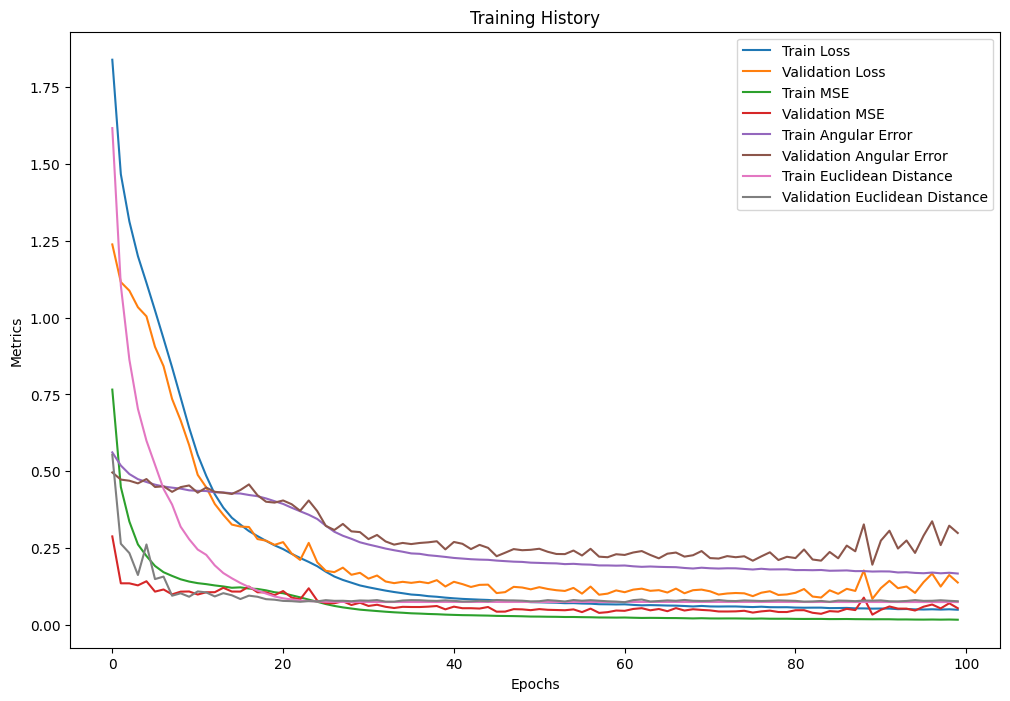

In [199]:
#FCN with 1D Convolution using CUSTOM LOSS

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout, Conv1D, Flatten, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ensure GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Custom Loss Function (as defined before)
def custom_loss(y_true, y_pred):
    coords_true = y_true[:, :6]
    coords_pred = y_pred[:, :6]
    rotations_true = y_true[:, 6:]
    rotations_pred = y_pred[:, 6:]

    coords_loss = tf.reduce_mean(tf.square(coords_true - coords_pred))
    rotations_loss = tf.reduce_mean(tf.square(tf.sin(rotations_true - rotations_pred)))

    total_loss = coords_loss + rotations_loss
    return total_loss

# Custom Metrics (as defined before)
def custom_angular_error(y_true, y_pred):
    rotations_true = y_true[:, 6:] 
    rotations_pred = y_pred[:, 6:]
    angular_error = tf.reduce_mean(tf.abs(tf.sin(rotations_true - rotations_pred)))
    return angular_error

def custom_euclidean_distance(y_true, y_pred):
    coords_true = y_true[:, :6] 
    coords_pred = y_pred[:, :6]
    euclidean_distance = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(coords_true - coords_pred), axis=-1)))
    return euclidean_distance

# Build the Model with 1D Convolution and FCN
def build_model_with_conv1d_and_fcn(input_shape):
    input_layer = Input(shape=(input_shape,))
    
    # Reshape the input into (None, 3, 768)
    reshaped_input = Reshape((3, 768))(input_layer)
    
    # Define a shared Conv1D layer to reduce each 768-dimensional vector to 256
    conv1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')
    conv2 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')
    conv3 = Conv1D(filters=1, kernel_size=3, padding='same', activation='relu')
    
    # Apply Conv1D to each of the three 768-dimensional vectors
    conv_output1 = conv3(conv2(conv1(reshaped_input[:, 0:1, :])))
    conv_output2 = conv3(conv2(conv1(reshaped_input[:, 1:2, :])))
    conv_output3 = conv3(conv2(conv1(reshaped_input[:, 2:3, :])))

    # Concatenate the outputs back into a single 768-dimensional vector
    concatenated_output = Concatenate(axis=-1)([Flatten()(conv_output1), Flatten()(conv_output2), Flatten()(conv_output3)])

    # Fully Connected Network (FCN) on the concatenated vector
    x = Dense(units=512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(concatenated_output)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.4)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    output_layer = Dense(9)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=custom_loss, 
                  metrics=['mse', 'mae', custom_angular_error, custom_euclidean_distance])
    return model


input_shape = X_train.shape[1]

# Build and compile the model
model = build_model_with_conv1d_and_fcn(input_shape=input_shape)

# Print model summary
print(model.summary())

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping], batch_size=16, verbose=1)

# Evaluate the model on the test set
test_loss, test_mse, test_mae, test_angular_error, test_euclidean_distance = model.evaluate(X_test, y_test, verbose=0)

# Print the evaluation metrics
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test Angular Error: {test_angular_error}")
print(f"Test Euclidean Distance: {test_euclidean_distance}")

# Plot the training history
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.plot(history.history['custom_angular_error'], label='Train Angular Error')
plt.plot(history.history['val_custom_angular_error'], label='Validation Angular Error')
plt.plot(history.history['custom_euclidean_distance'], label='Train Euclidean Distance')
plt.plot(history.history['val_custom_euclidean_distance'], label='Validation Euclidean Distance')
plt.legend()
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

# Save the history to a CSV file
history_df = pd.DataFrame(history.history)
history_file = os.path.join("experiments", "model_architecture_history_with_conv1d_fcn.csv")
history_df.to_csv(history_file, index=False)


---
# Image Stitching and Visualization using Random Input Test Hand Dataset

using GRU Model Sequence correction to order Input Features Correctly

---

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001006.jpg
Processing augmented set: 1_IMG0001006
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001006_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001006_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001006_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


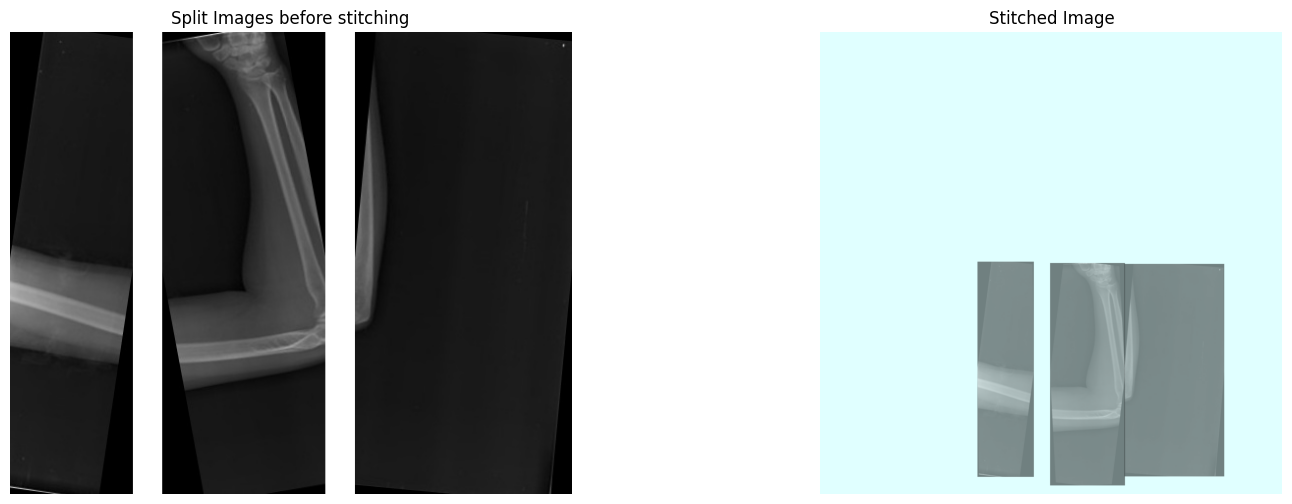

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002849.jpg
Processing augmented set: 1_IMG0002849
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002849_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002849_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002849_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


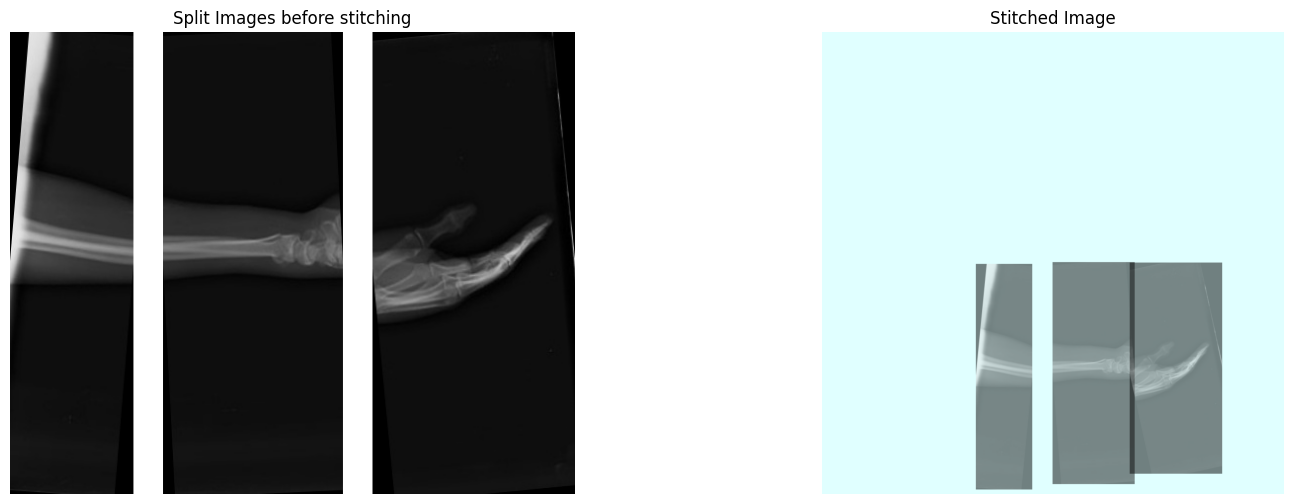

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001148.jpg
Processing augmented set: 1_IMG0001148
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001148_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001148_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001148_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


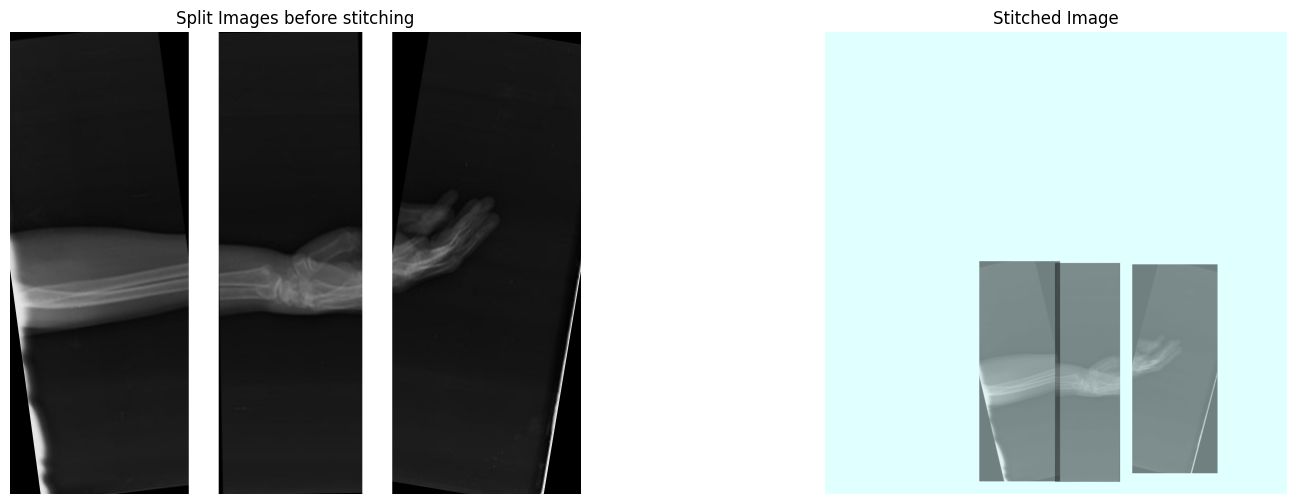

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002086.jpg
Processing augmented set: 1_IMG0002086
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002086_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002086_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002086_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


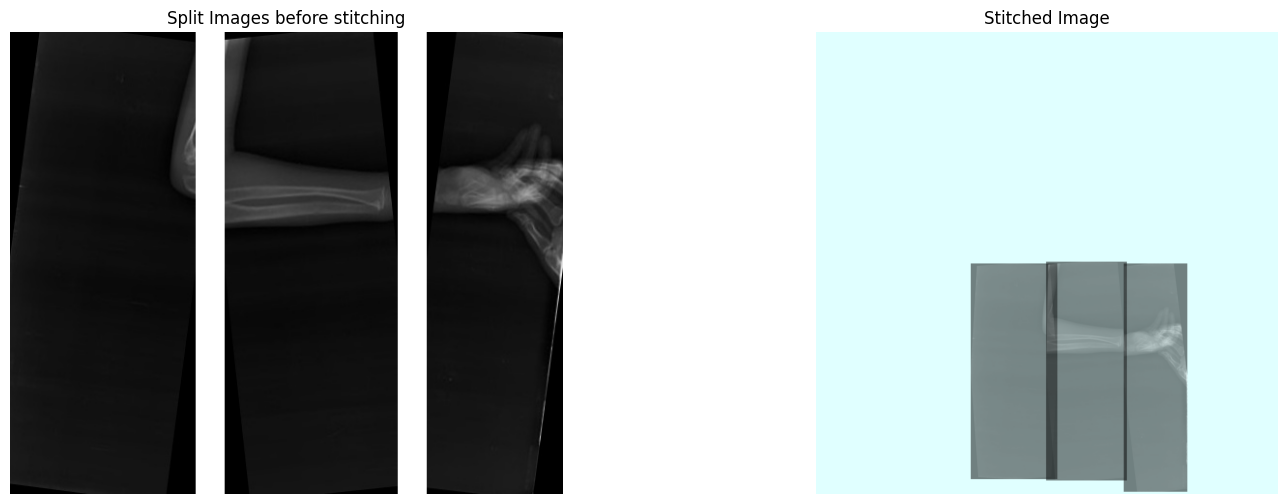

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0000337.jpg
Processing augmented set: 1_IMG0000337
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000337_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000337_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000337_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


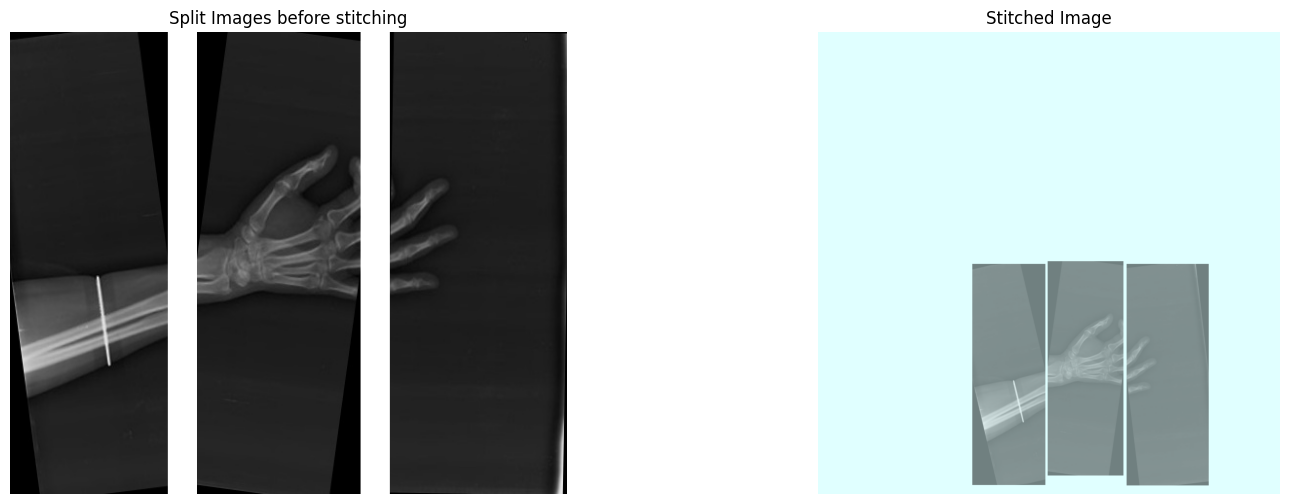

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001363.jpg
Processing augmented set: 1_IMG0001363
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001363_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001363_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001363_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


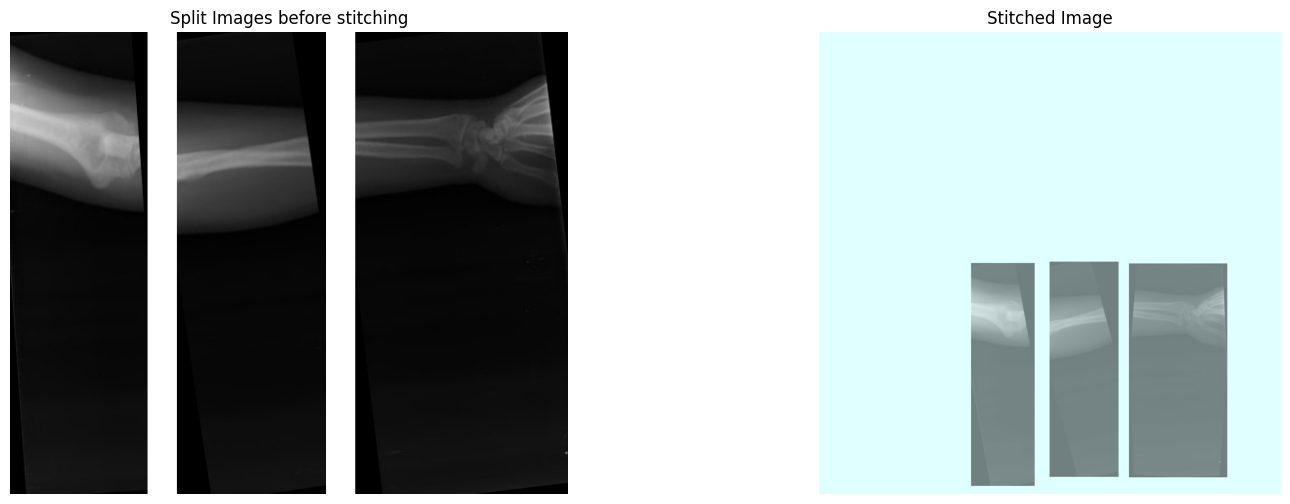

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001411.jpg
Processing augmented set: 1_IMG0001411
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001411_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001411_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001411_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


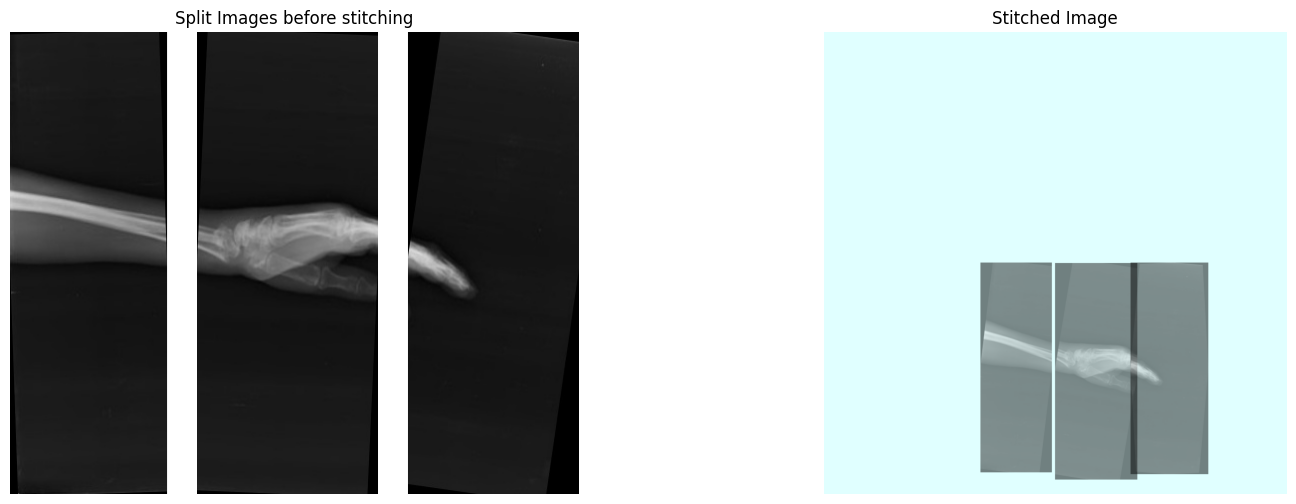

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0003012.jpg
Processing augmented set: 1_IMG0003012
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003012_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003012_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003012_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


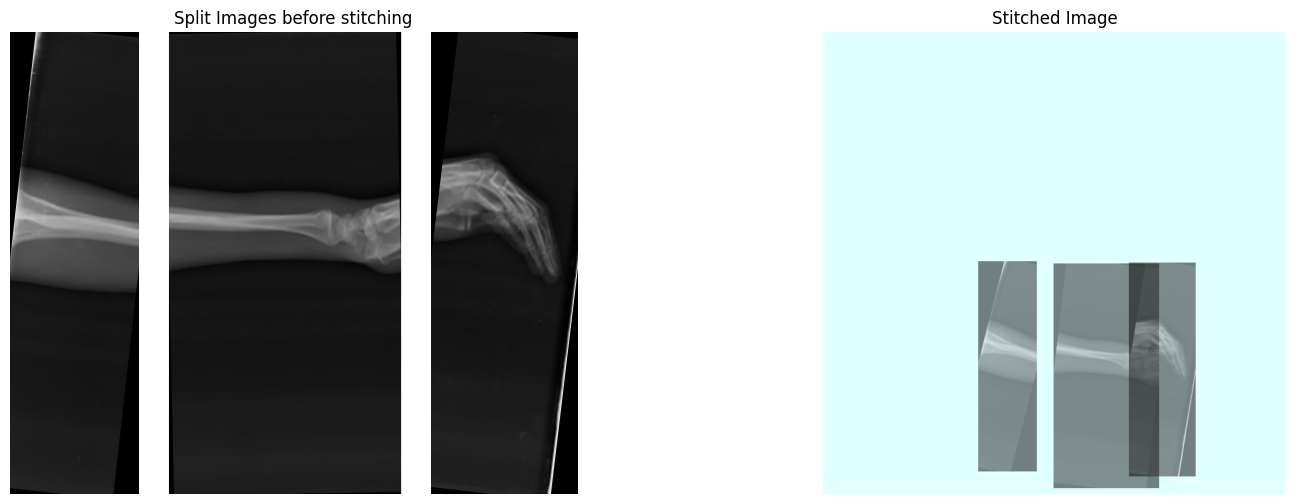

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002495.jpg
Processing augmented set: 1_IMG0002495
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002495_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002495_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002495_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


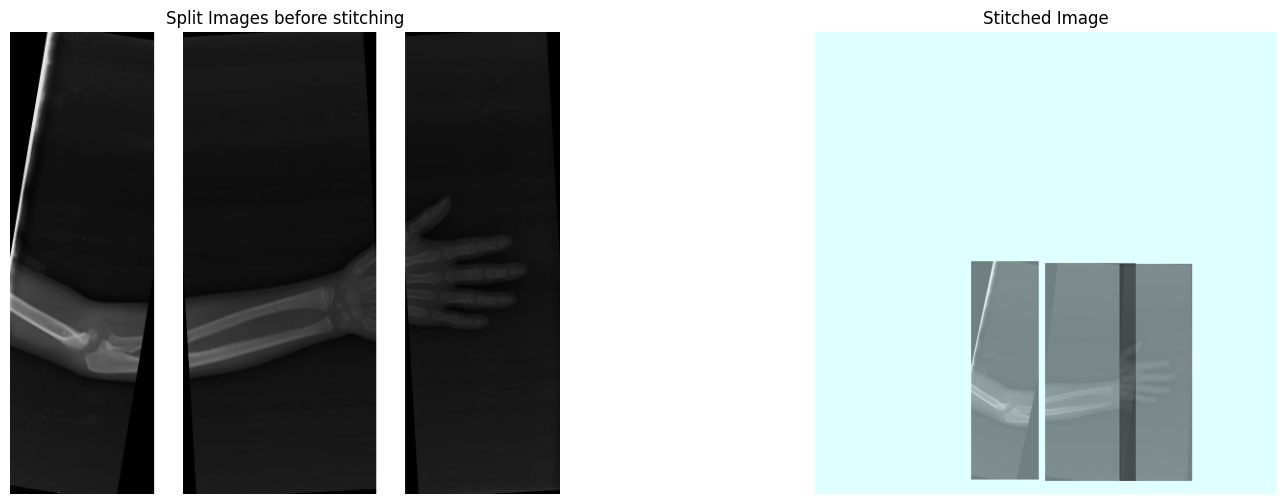

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001566.jpg
Processing augmented set: 1_IMG0001566
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001566_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001566_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001566_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


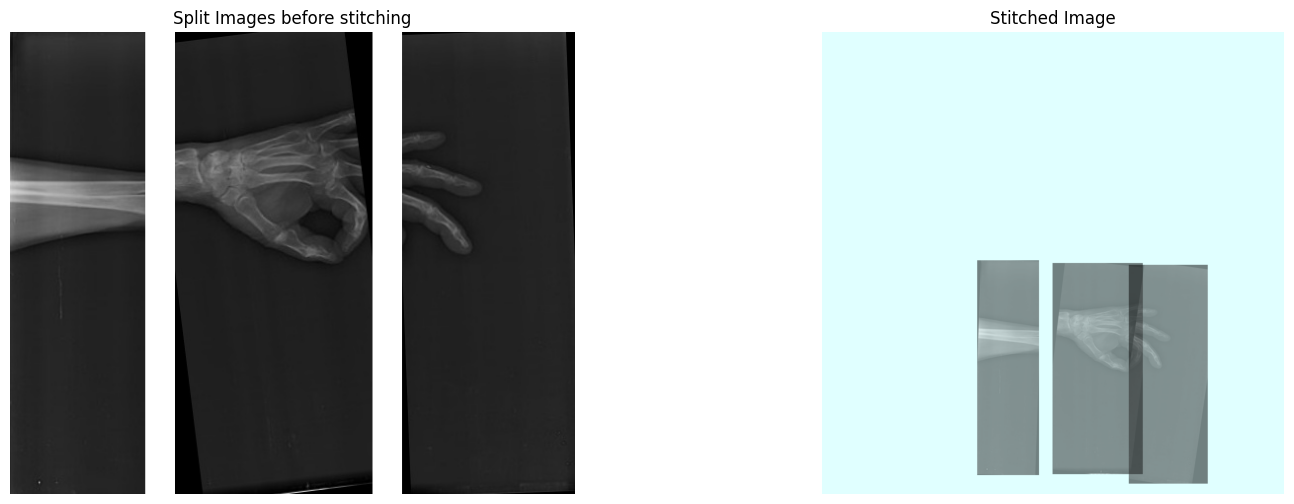

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0000122.jpg
Processing augmented set: 1_IMG0000122
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000122_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000122_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000122_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


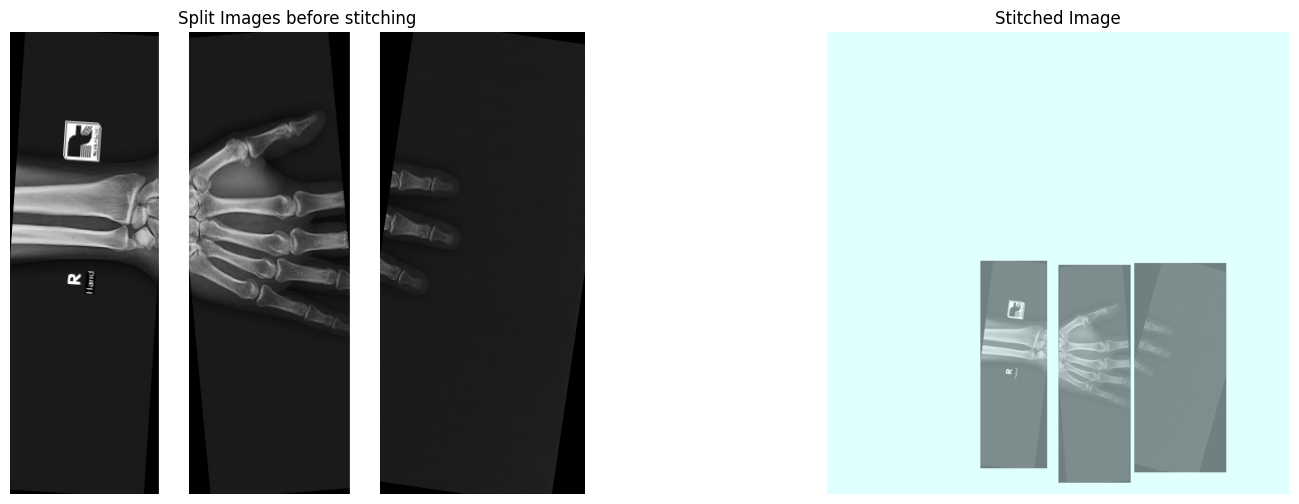

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0003952.jpg
Processing augmented set: 1_IMG0003952
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003952_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003952_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003952_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


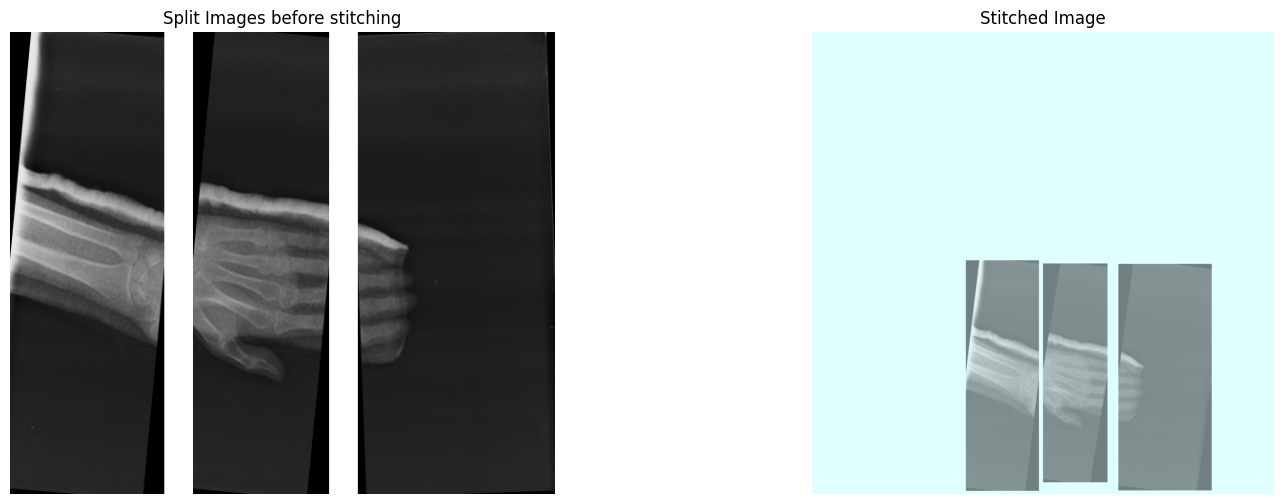

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0003712.jpg
Processing augmented set: 1_IMG0003712
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003712_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003712_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003712_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


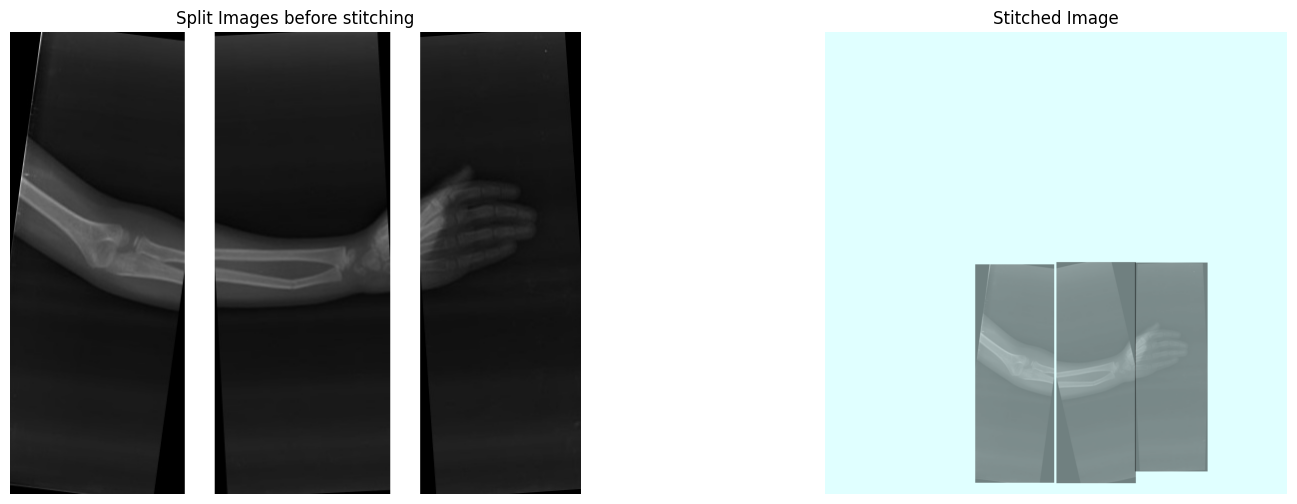

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0004337.jpg
Processing augmented set: 1_IMG0004337
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0004337_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0004337_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0004337_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


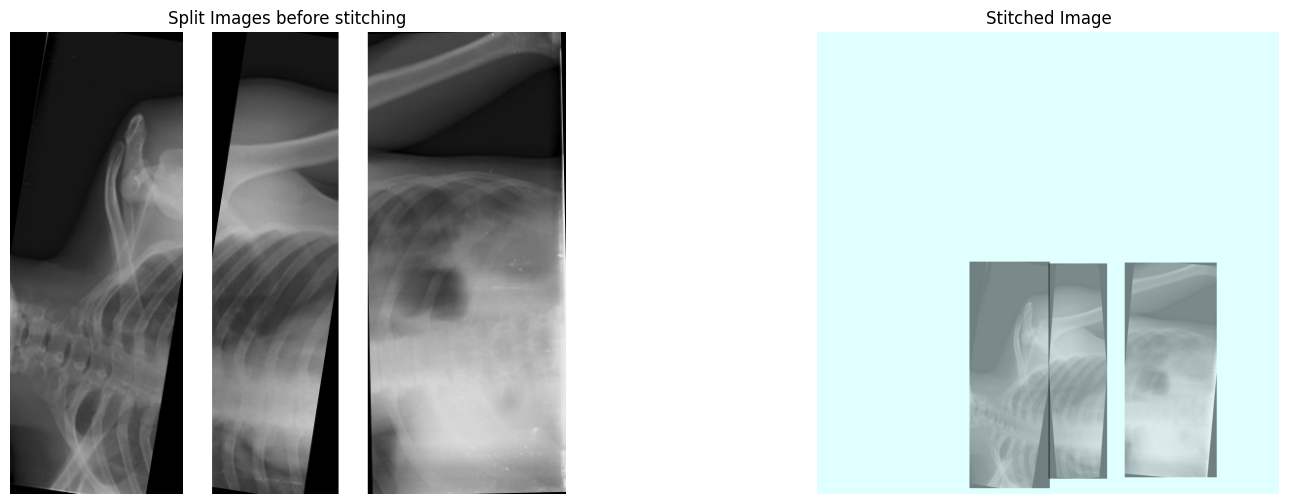

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0004295.jpg
Processing augmented set: 1_IMG0004295
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0004295_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0004295_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0004295_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


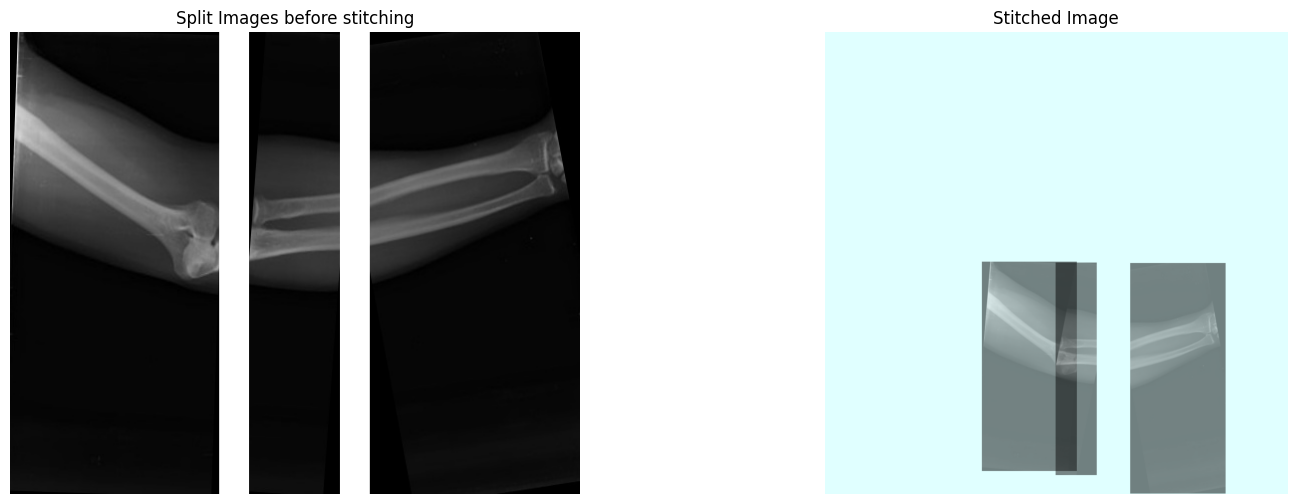

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001477.jpg
Processing augmented set: 1_IMG0001477
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001477_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001477_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001477_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


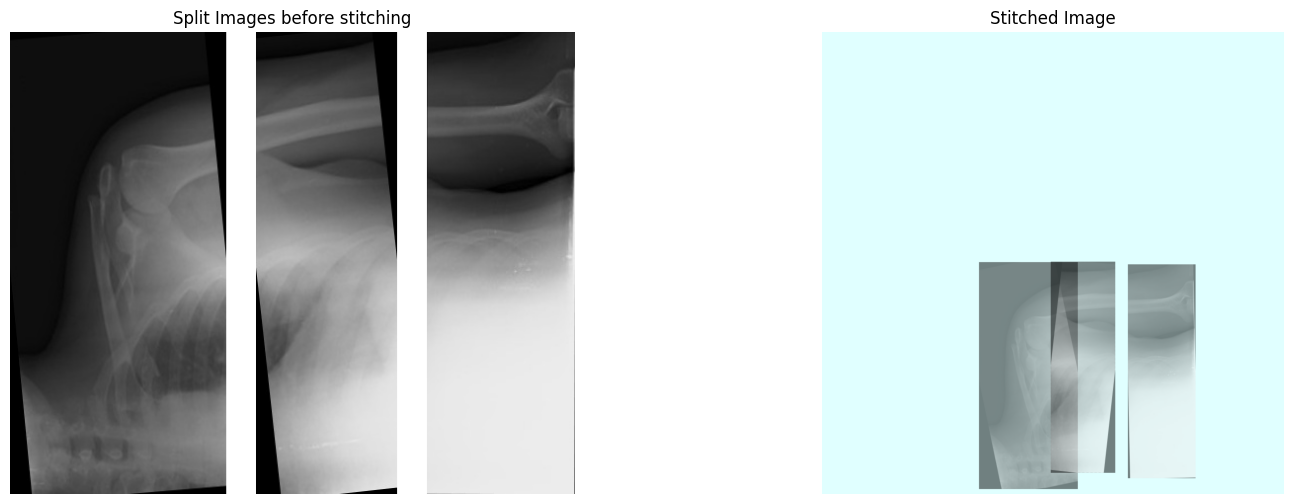

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001062.jpg
Processing augmented set: 1_IMG0001062
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001062_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001062_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001062_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


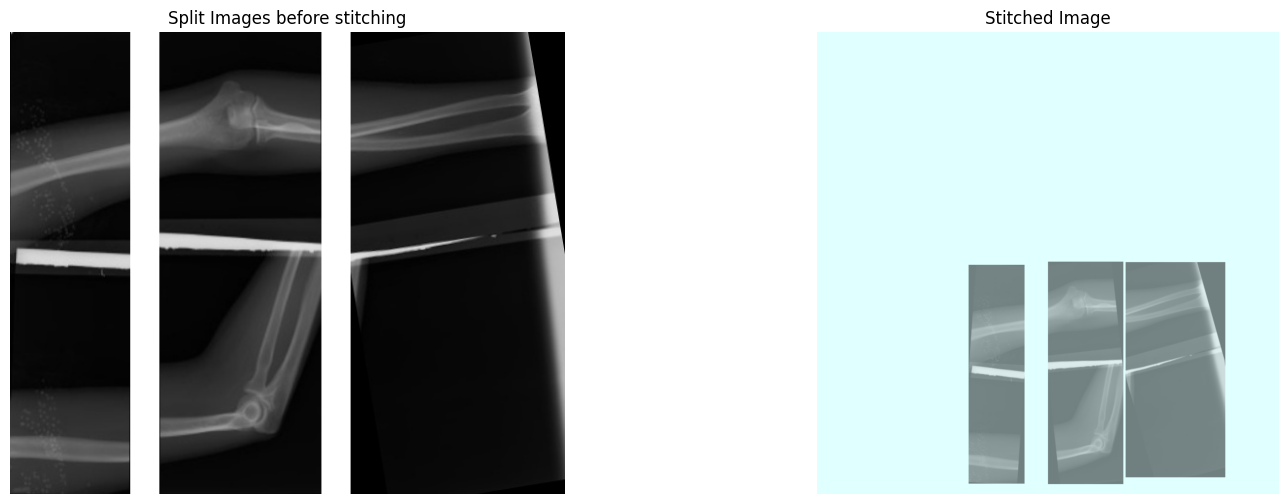

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001910.jpg
Processing augmented set: 1_IMG0001910
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001910_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001910_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001910_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


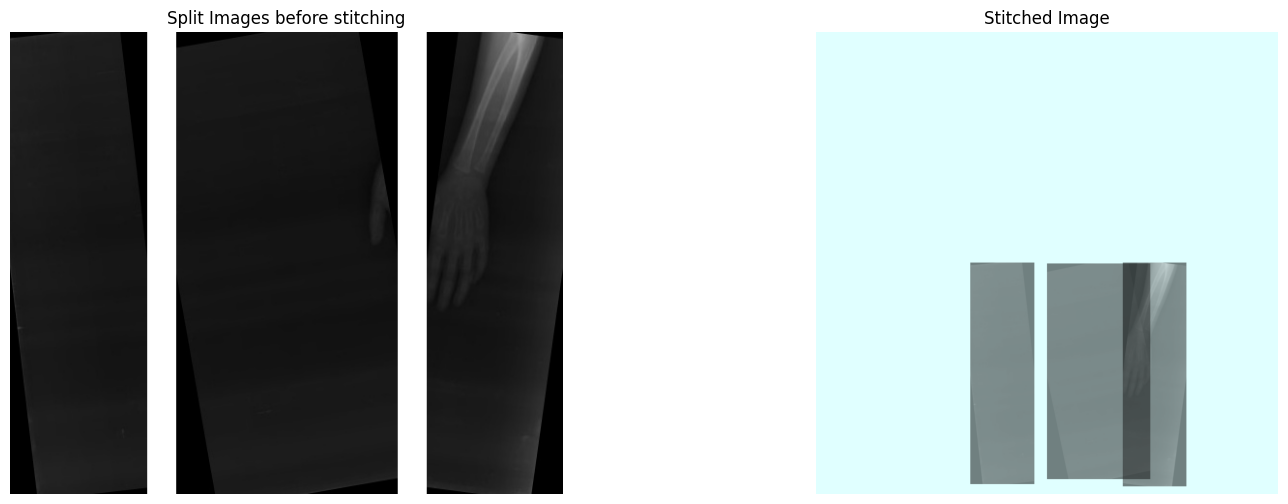

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002410.jpg
Processing augmented set: 1_IMG0002410
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002410_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002410_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002410_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


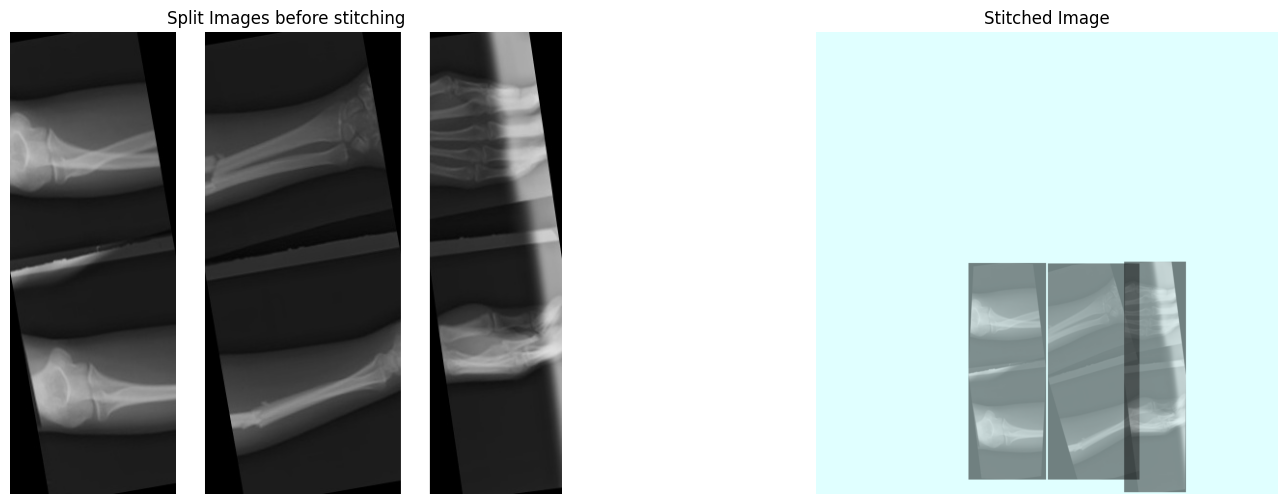

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001319.jpg
Processing augmented set: 1_IMG0001319
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001319_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001319_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001319_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


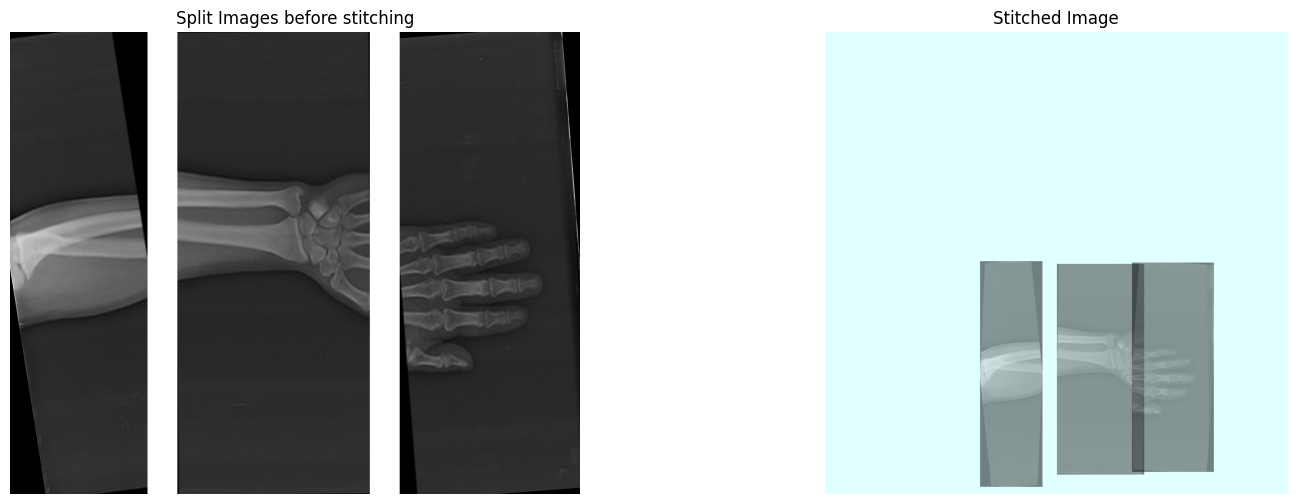

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0003283.jpg
Processing augmented set: 1_IMG0003283
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003283_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003283_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003283_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


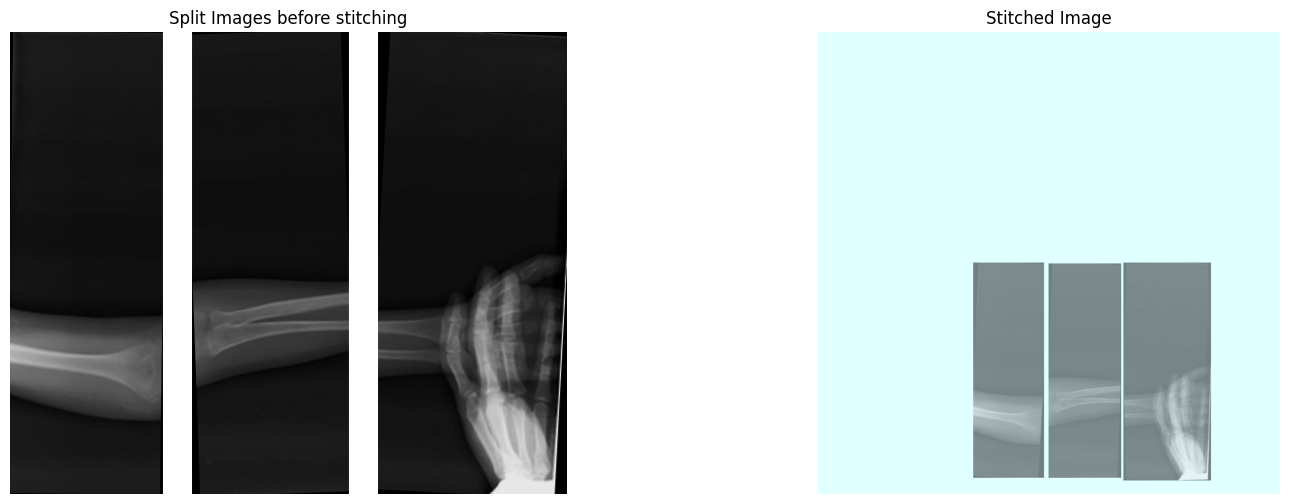

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0003679.jpg
Processing augmented set: 1_IMG0003679
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003679_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003679_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003679_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


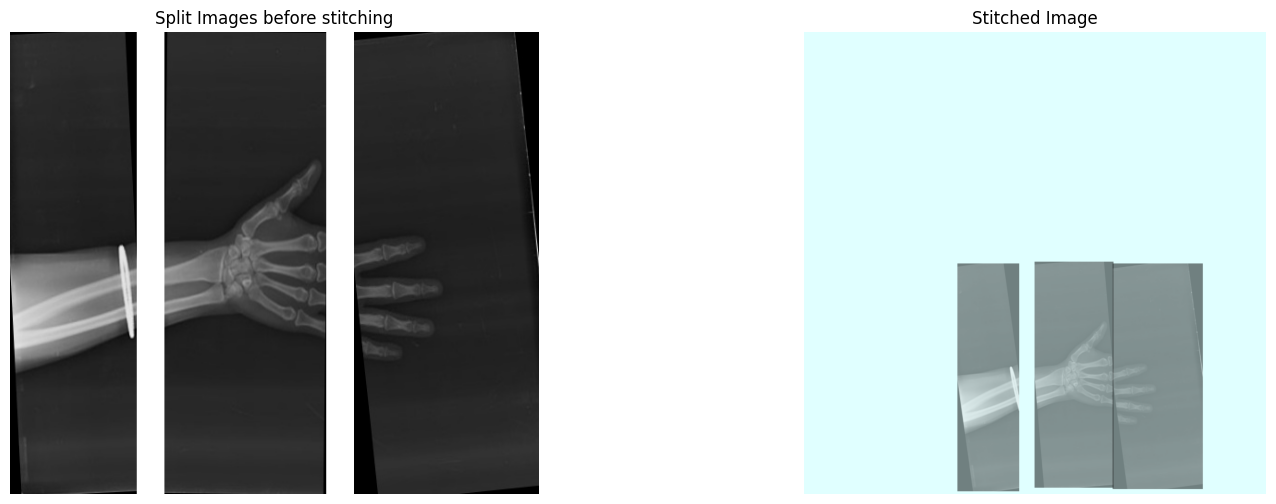

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0000012.jpg
Processing augmented set: 1_IMG0000012
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000012_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000012_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000012_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


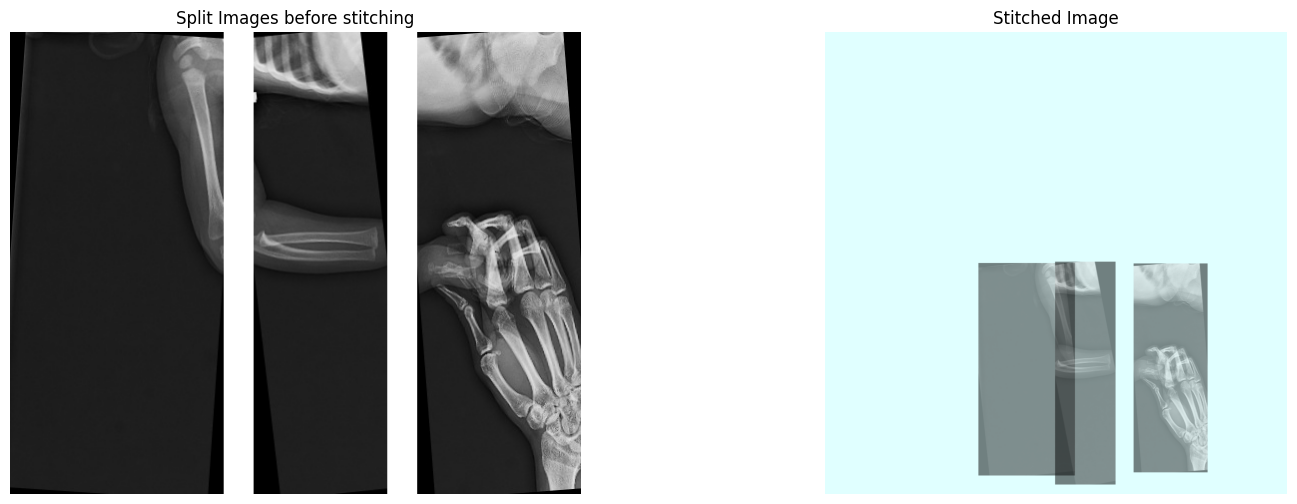

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002198.jpg
Processing augmented set: 1_IMG0002198
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002198_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002198_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002198_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


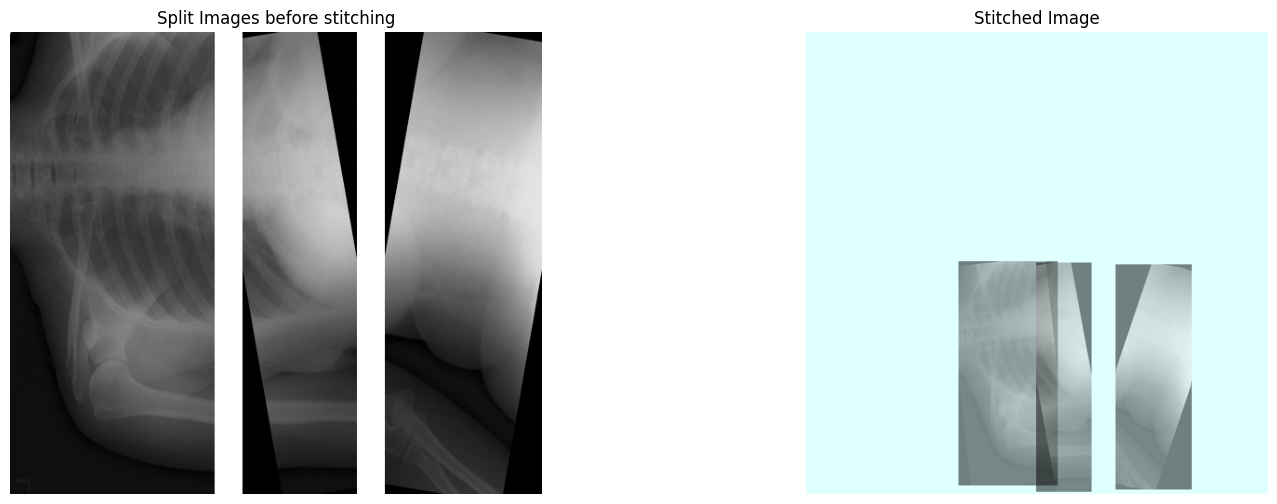

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0000604.jpg
Processing augmented set: 1_IMG0000604
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000604_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000604_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000604_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


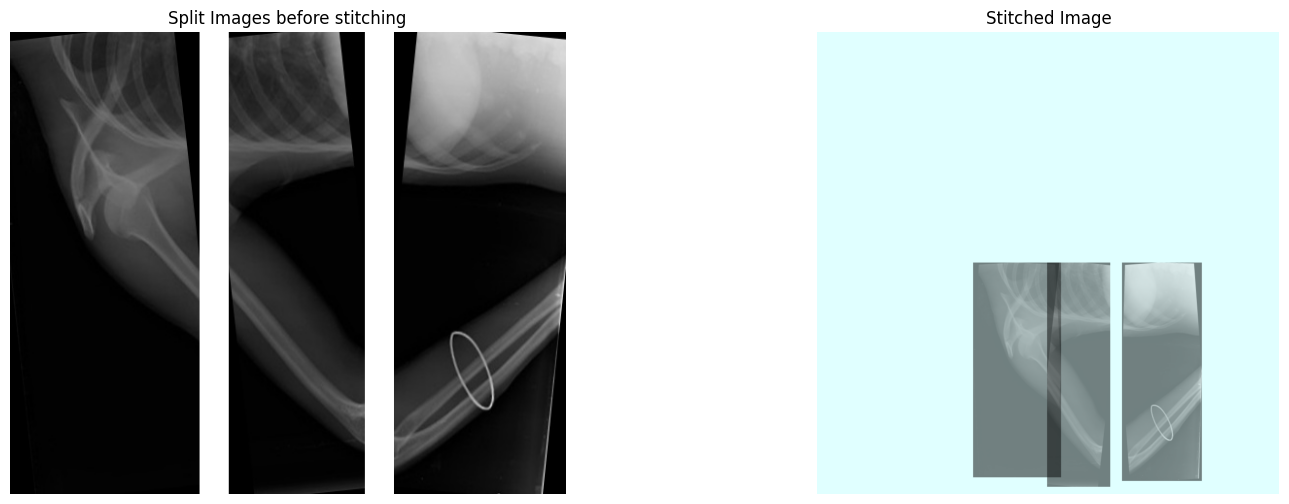

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0003133.jpg
Processing augmented set: 1_IMG0003133
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003133_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003133_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0003133_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


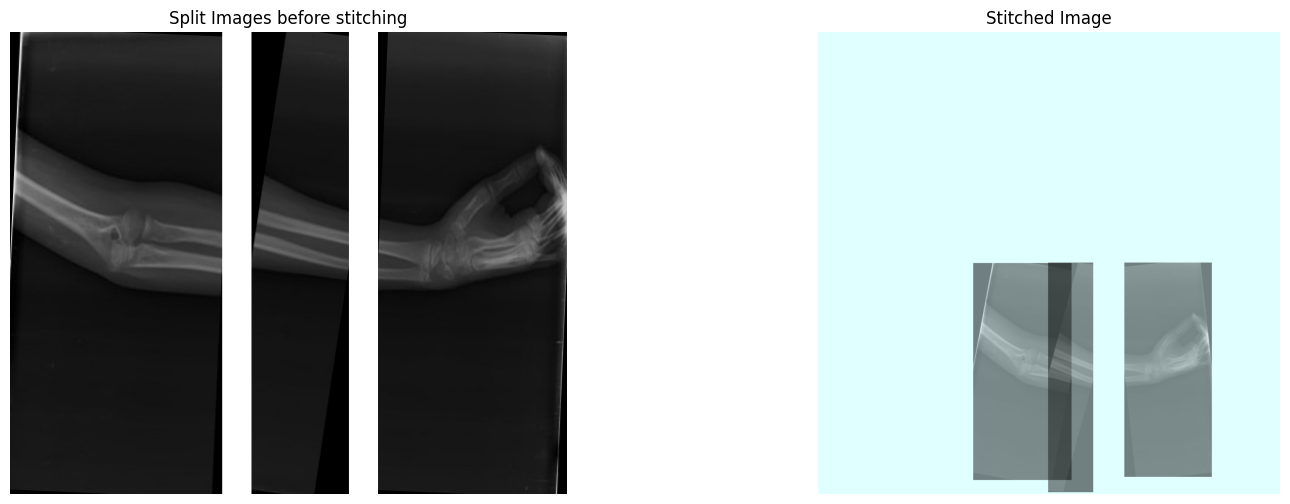

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0000611.jpg
Processing augmented set: 1_IMG0000611
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000611_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000611_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000611_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


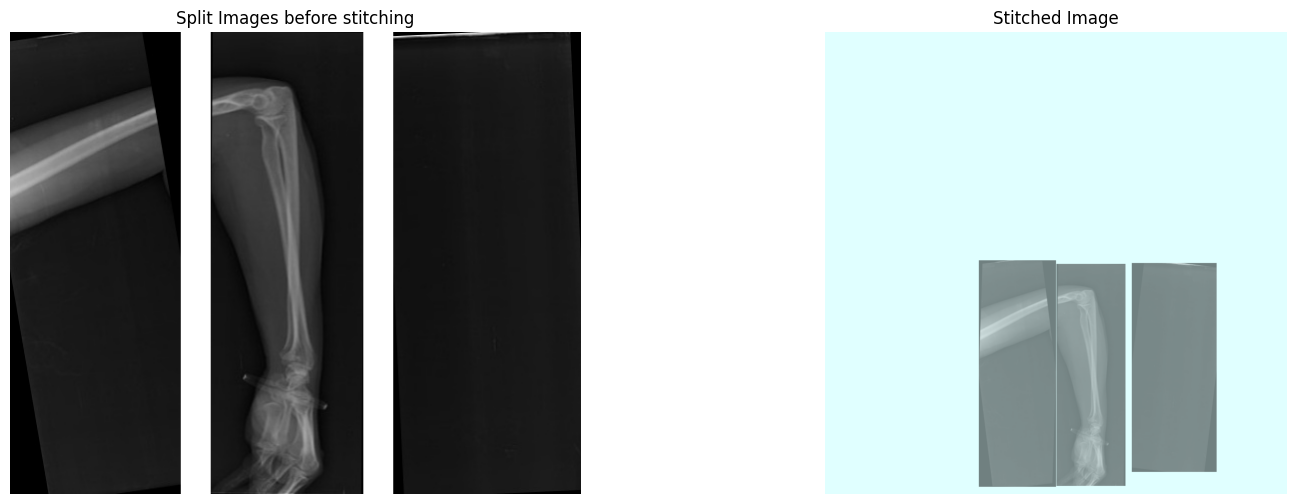

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001492.jpg
Processing augmented set: 1_IMG0001492
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001492_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001492_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001492_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


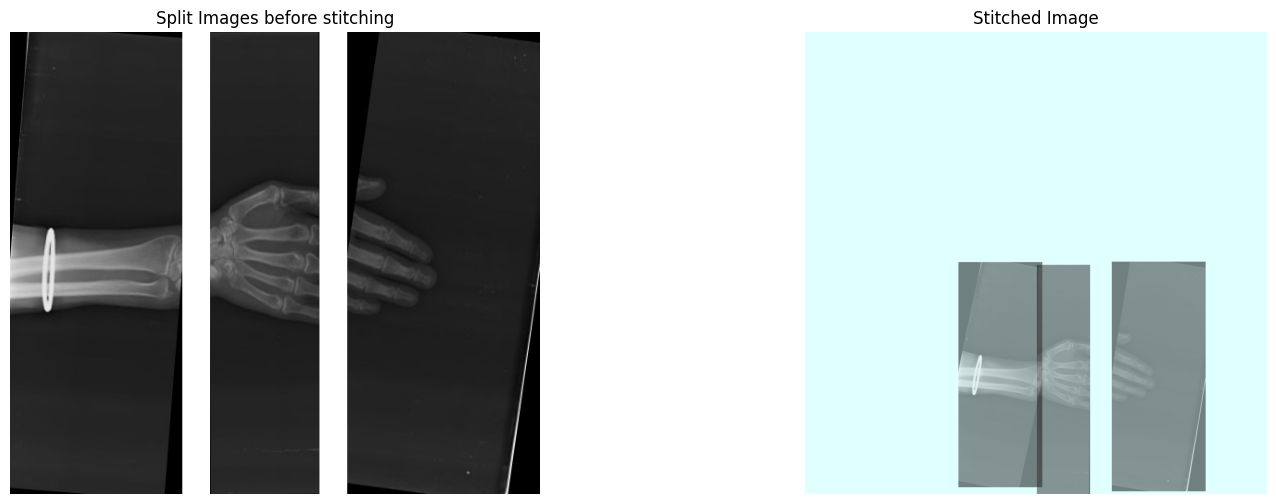

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0004201.jpg
Processing augmented set: 1_IMG0004201
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0004201_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0004201_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0004201_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


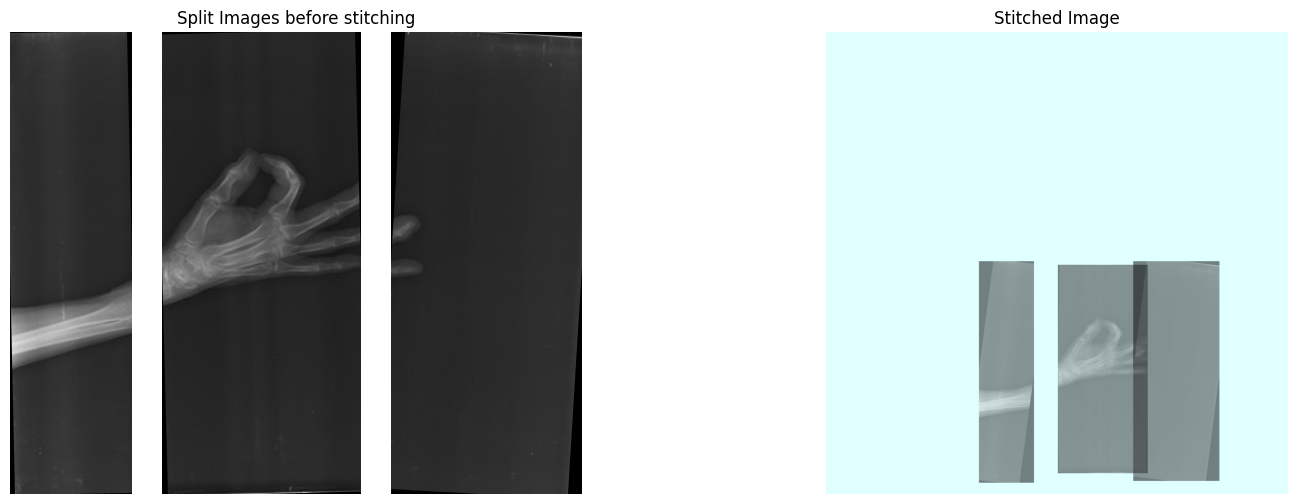

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001224.jpg
Processing augmented set: 1_IMG0001224
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001224_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001224_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001224_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


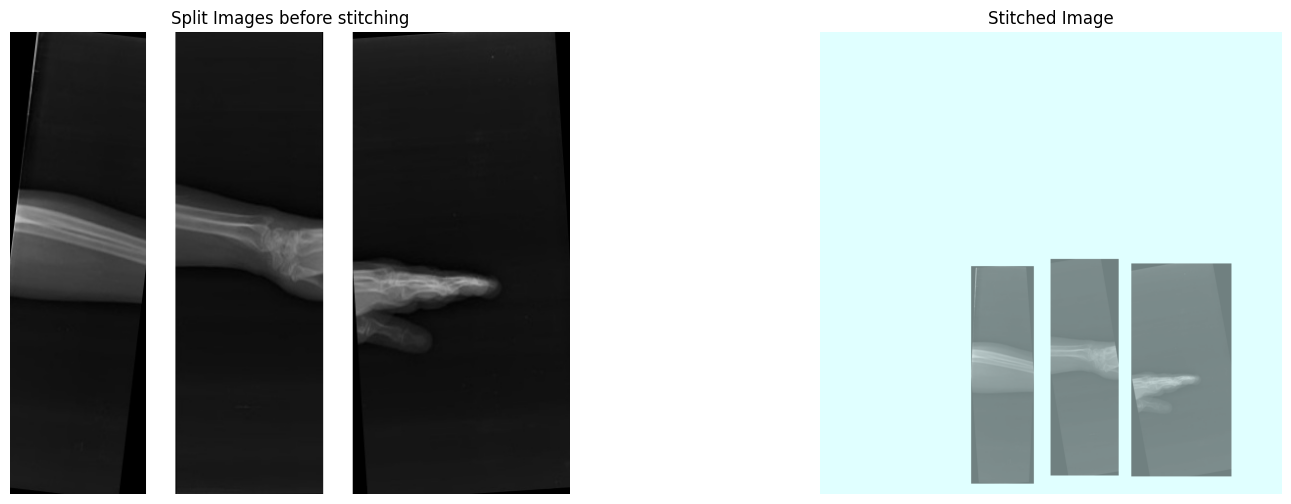

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002101.jpg
Processing augmented set: 1_IMG0002101
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002101_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002101_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002101_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


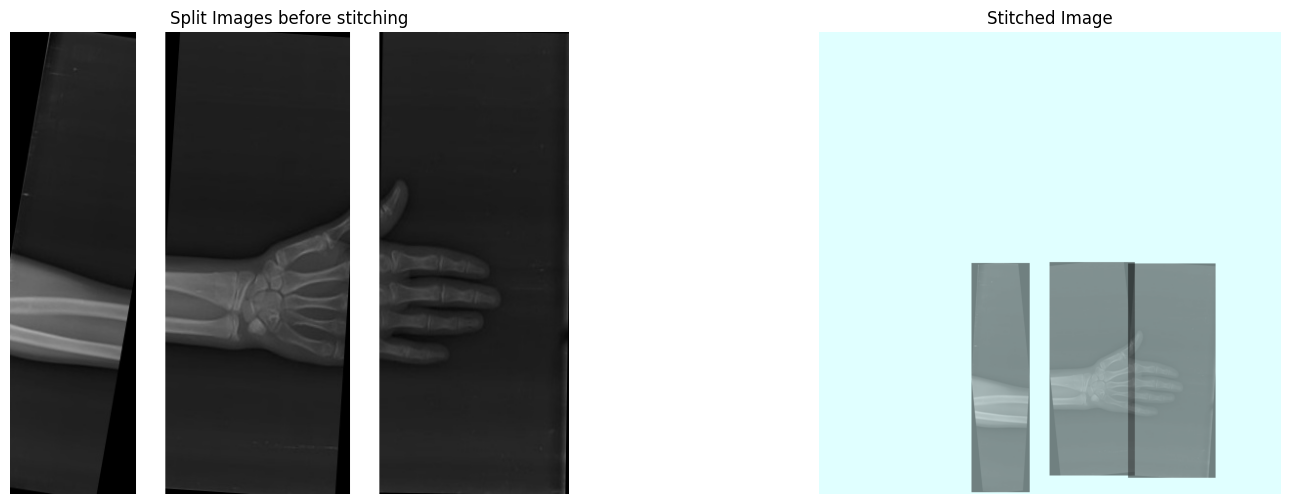

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002698.jpg
Processing augmented set: 1_IMG0002698
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002698_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002698_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002698_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


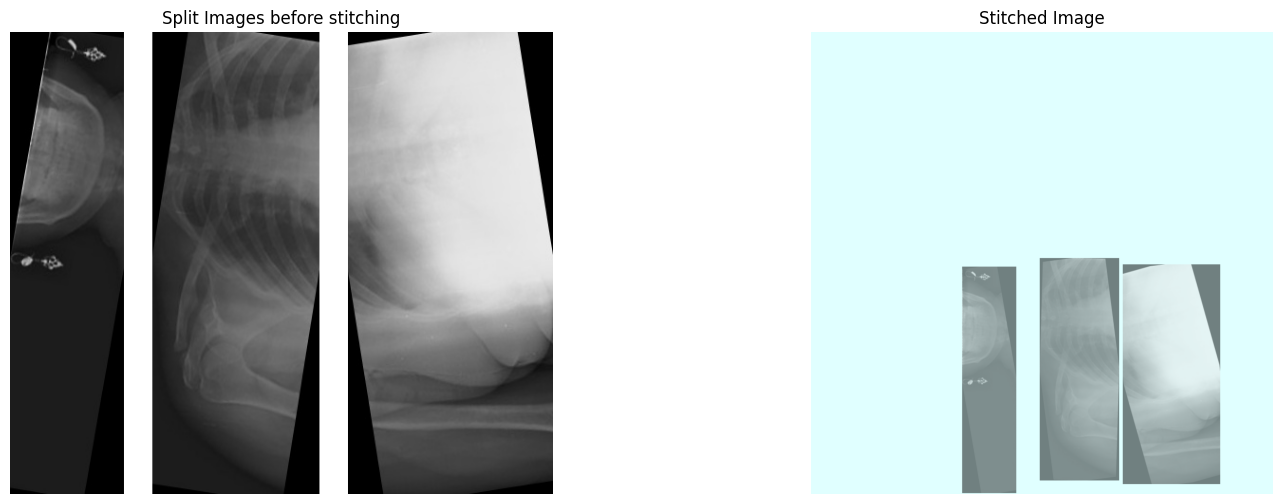

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0000529.jpg
Processing augmented set: 1_IMG0000529
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000529_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000529_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0000529_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


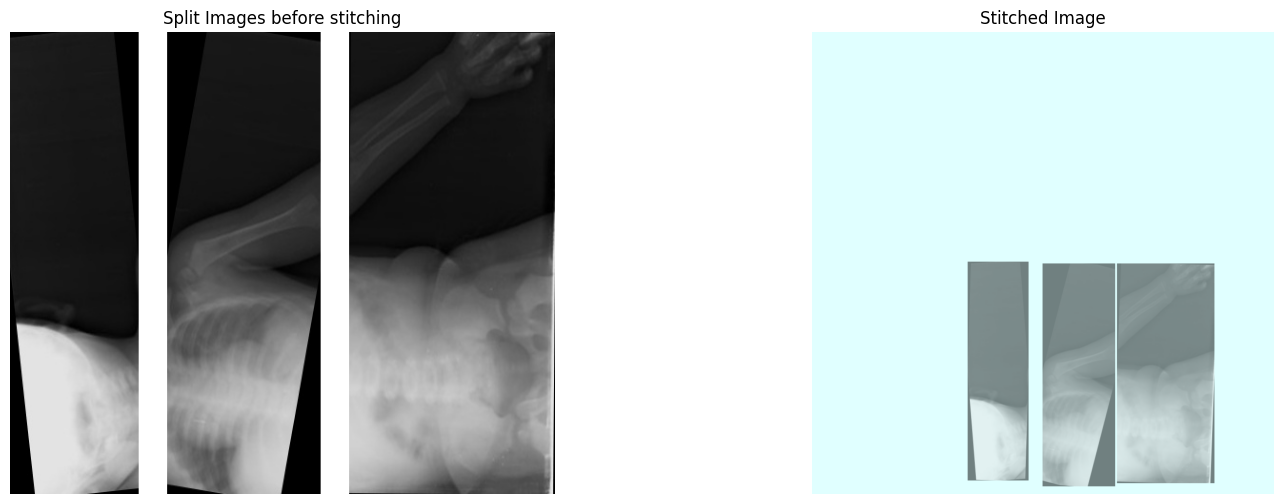

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0001343.jpg
Processing augmented set: 1_IMG0001343
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001343_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001343_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0001343_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


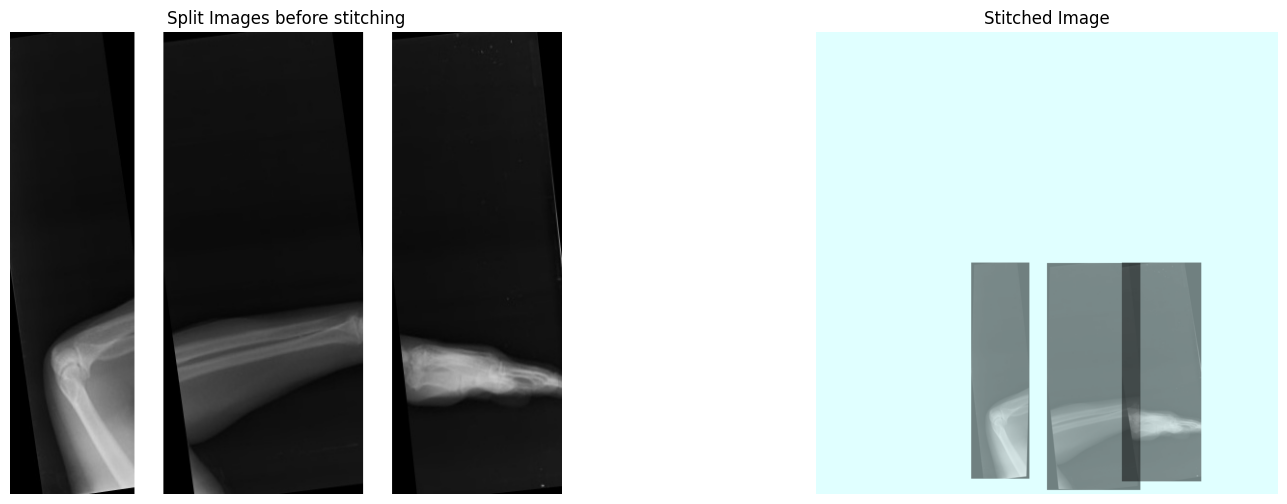

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002716.jpg
Processing augmented set: 1_IMG0002716
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002716_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002716_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002716_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


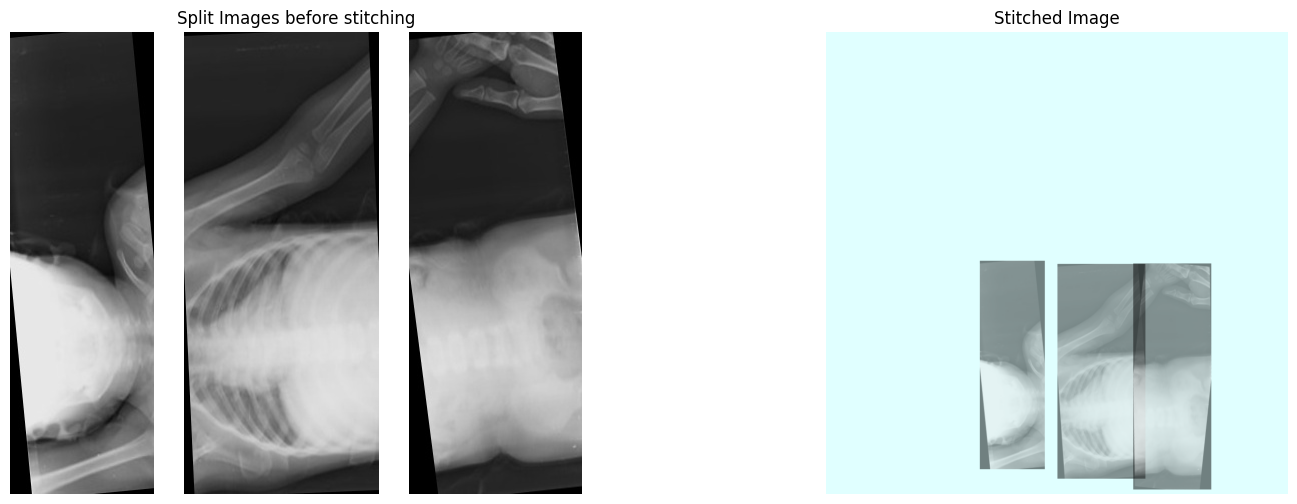

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002529.jpg
Processing augmented set: 1_IMG0002529
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002529_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002529_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002529_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


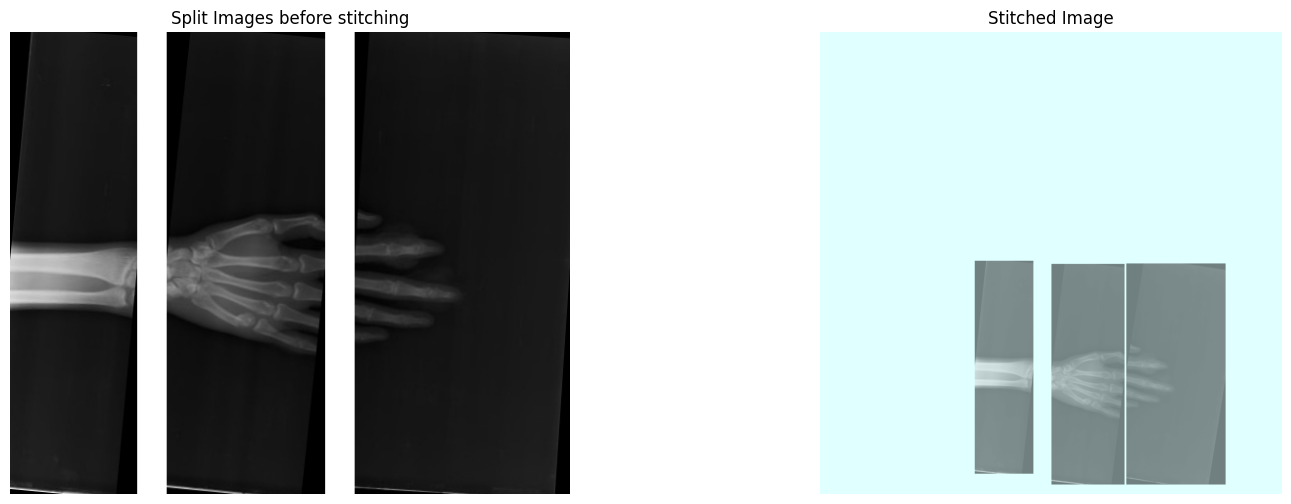

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002311.jpg
Processing augmented set: 1_IMG0002311
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002311_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002311_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002311_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


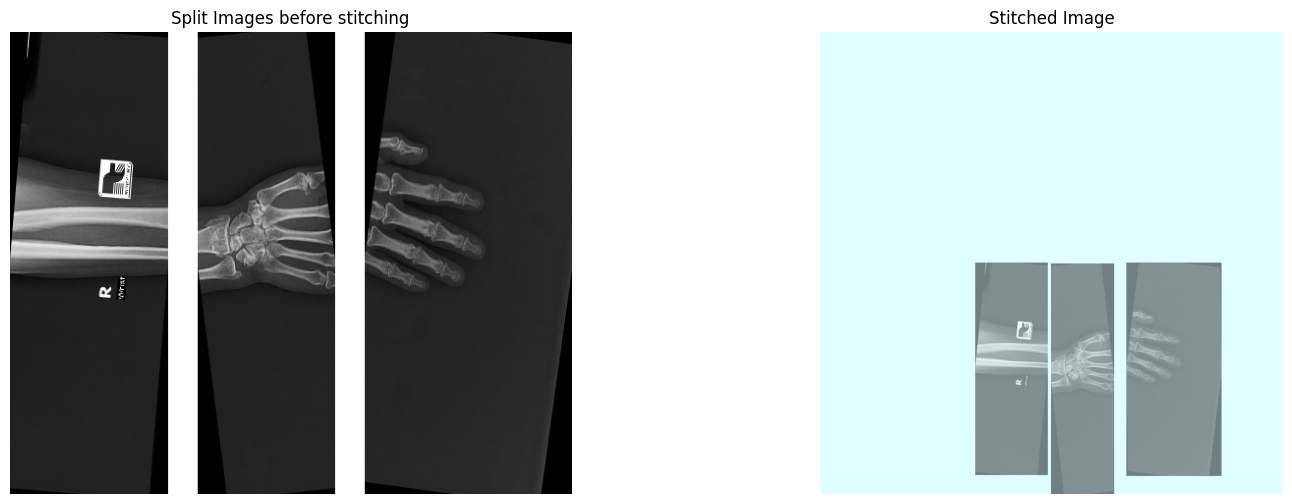

Trying to read original image from: /Users/rishabhdubey/Downloads/BothComplete/IMG0002066.jpg
Processing augmented set: 1_IMG0002066
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002066_1.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002066_2.jpg
Trying to read split image from: /Users/rishabhdubey/Downloads/Project/Additional_Synth_new_1_aug/1_IMG0002066_3.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


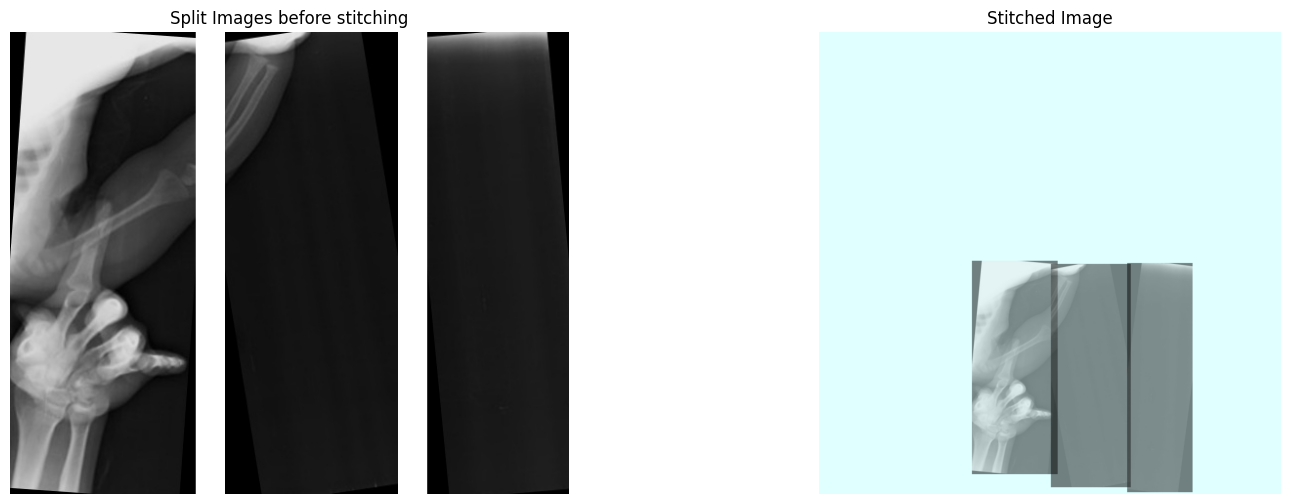

In [130]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def inverse_rotate_image(image, angle):
    height, width = image.shape[:2]
    center = (width // 2, height // 2)
    rotation_matrix = cv.getRotationMatrix2D(center, -angle, 1.0)  # Inverse rotation
    rotated_image = cv.warpAffine(image, rotation_matrix, (width, height), flags=cv.INTER_LINEAR)
    return rotated_image

def blend_images(base_image, overlay_image, x, y):
    """
    Blends overlay_image onto base_image at position (x, y).
    """
    h, w = overlay_image.shape[:2]
    
    # Ensure the placement is within the base image bounds
    if x < 0:
        overlay_image = overlay_image[:, -x:]
        x = 0
    if y < 0:
        overlay_image = overlay_image[-y:, :]
        y = 0
    if x + w > base_image.shape[1]:
        overlay_image = overlay_image[:, :base_image.shape[1] - x]
    if y + h > base_image.shape[0]:
        overlay_image = overlay_image[:base_image.shape[0] - y, :]
    
    h, w = overlay_image.shape[:2]

    # Blend the images in the overlapping area
    alpha = 0.5  # Blending factor
    base_image[y:y+h, x:x+w] = cv.addWeighted(base_image[y:y+h, x:x+w], alpha, overlay_image, alpha, 0)

def resize_images_to_min_height(images):
    """
    Resizes all images to the minimum height found among them.
    """
    min_height = min(img.shape[0] for img in images)
    resized_images = [cv.resize(img, (img.shape[1], min_height)) for img in images]
    return resized_images

def add_margin_between_images(images, margin=30, background_color=(255, 255, 255)):
    """
    Adds a margin between images when they are horizontally concatenated.
    
    Args:
    images: List of images to concatenate.
    margin: The size of the margin (in pixels) between each image.
    background_color: The color of the margin (default is white).

    Returns:
    A single image with the input images horizontally concatenated with margins in between.
    """
    if len(images) == 0:
        return None

    # Calculate the total width of the final image, including margins
    total_width = sum(img.shape[1] for img in images) + (len(images) - 1) * margin
    height = images[0].shape[0]
    
    # Create a blank canvas for the final image
    canvas = np.full((height, total_width, 3), background_color, dtype=np.uint8)

    # Paste images into the canvas with margins
    current_x = 0
    for img in images:
        canvas[:, current_x:current_x + img.shape[1]] = img
        current_x += img.shape[1] + margin
    
    return canvas

def create_stitched_image(augmented_filename, feature_vector, labels, original_folder, masked_synthetic_folder, max_nu_of_splits, model):
    # Extract base name by removing any prefix (e.g., "1_", "2_")
    # Split the filename to get the original image name
    base_name = '_'.join(augmented_filename.split('_')[1:])
    
    # Construct the path to the original image
    original_image_path = os.path.join(original_folder, base_name)
    print(f"Trying to read original image from: {original_image_path}")
    
    original_image = cv.imread(original_image_path)
    if original_image is None:
        print(f"Error: Could not read original image {base_name}")
        return

    # Only process the first augmented set ("1_imgname")
    augmented_base_name = f"1_{base_name.split('.')[0]}"
    print(f"Processing augmented set: {augmented_base_name}")

    # Get split images for this augmented set
    split_images = []
    for i in range(1, max_nu_of_splits + 1):
        split_image_path = os.path.join(masked_synthetic_folder, f"{augmented_base_name}_{i}.jpg")
        print(f"Trying to read split image from: {split_image_path}")

        if os.path.exists(split_image_path):
            split_image = cv.imread(split_image_path, cv.IMREAD_GRAYSCALE)
            if split_image is None:
                print(f"Error: Could not read split image {split_image_path}")
                continue
            split_images.append(split_image)
        else:
            print(f"Split image not found at path: {split_image_path}")
            break

    if len(split_images) < max_nu_of_splits:
        print(f"Error: Not enough split images for {augmented_base_name}")
        return

    # Predict coordinates and rotations
    predicted_values = model.predict(np.expand_dims(feature_vector, axis=0))[0]

    # Denormalize
    predicted_coordinates = predicted_values[:6] * 512
    predicted_rotations = predicted_values[6:] * 10

    # Calculate the average of predicted coordinates to adjust the canvas center
    avg_x = np.mean(predicted_coordinates[::2])
    avg_y = np.mean(predicted_coordinates[1::2])

    # Create a canvas of 1024x1024 with adjusted center and light yellow background
    canvas_size = 1024
    canvas_center_x = int(canvas_size // 2 - avg_x)
    canvas_center_y = int(canvas_size // 2 - avg_y)
    canvas = np.full((canvas_size, canvas_size, 3), (255, 255, 224), dtype=np.uint8)  # Light yellow background

    # Apply predicted transformations and stitch images onto the canvas
    for i in range(max_nu_of_splits):
        x = int(predicted_coordinates[2 * i]) + canvas_center_x
        y = int(predicted_coordinates[2 * i + 1]) + canvas_center_y
        angle = predicted_rotations[i]

        split_image = cv.cvtColor(split_images[i], cv.COLOR_GRAY2BGR)
        rotated_image = inverse_rotate_image(split_image, angle)

        blend_images(canvas, rotated_image, x, y)

    # Resize split images to the minimum height so they can be concatenated horizontally
    resized_split_images = resize_images_to_min_height(split_images)

    # Add a margin of 30 pixels between the split images
    non_overlapping_split_image = add_margin_between_images(
        [cv.cvtColor(img, cv.COLOR_GRAY2BGR) for img in resized_split_images], 
        margin=30, 
        background_color=(255, 255, 255)  # White margin
    )

    # Plot the split images on the left and the stitched image on the right
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))  # Increase the width for better visibility

    ax[0].imshow(cv.cvtColor(non_overlapping_split_image, cv.COLOR_BGR2RGB))
    ax[0].set_title("Split Images before stitching")
    ax[0].axis('off')

    ax[1].imshow(cv.cvtColor(canvas, cv.COLOR_BGR2RGB))
    ax[1].set_title(f"Stitched Image")
    ax[1].axis('off')

    plt.show()

    
for idx, row in test1_df.iterrows():
    img_filename = row['imagename']  
    feature_vector = row['feature_vector']
    labels = row['labels']
    create_stitched_image(img_filename, feature_vector, labels, original_folder, masked_synthetic_folder, max_nu_of_splits, model)



---
# Structural Infrerence - Graphs

---
Codes tried to Infer the Preffered Models for the task

---

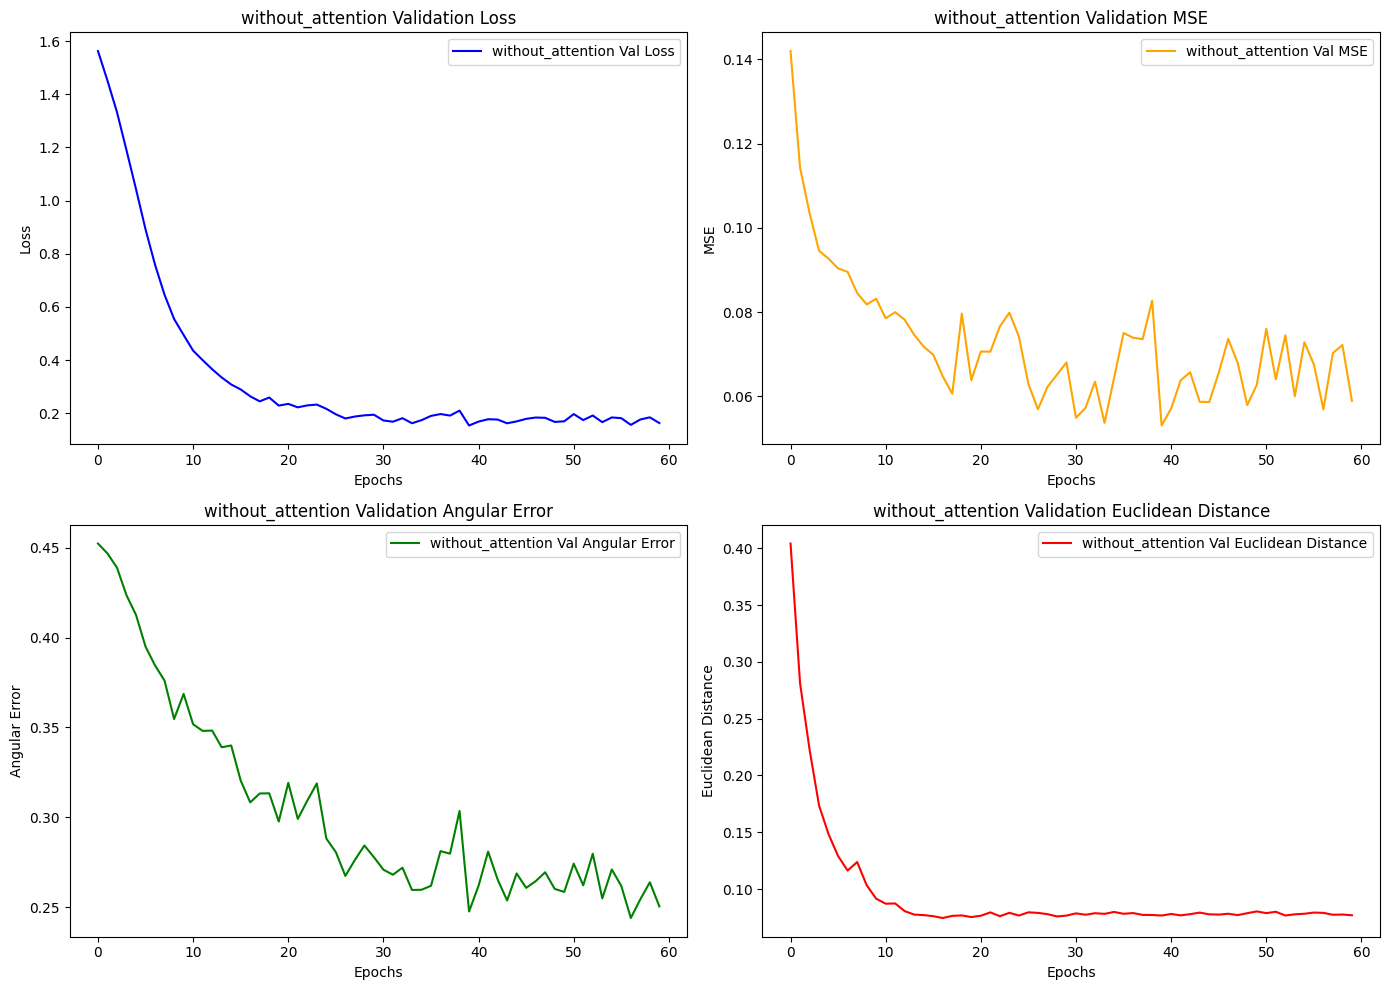

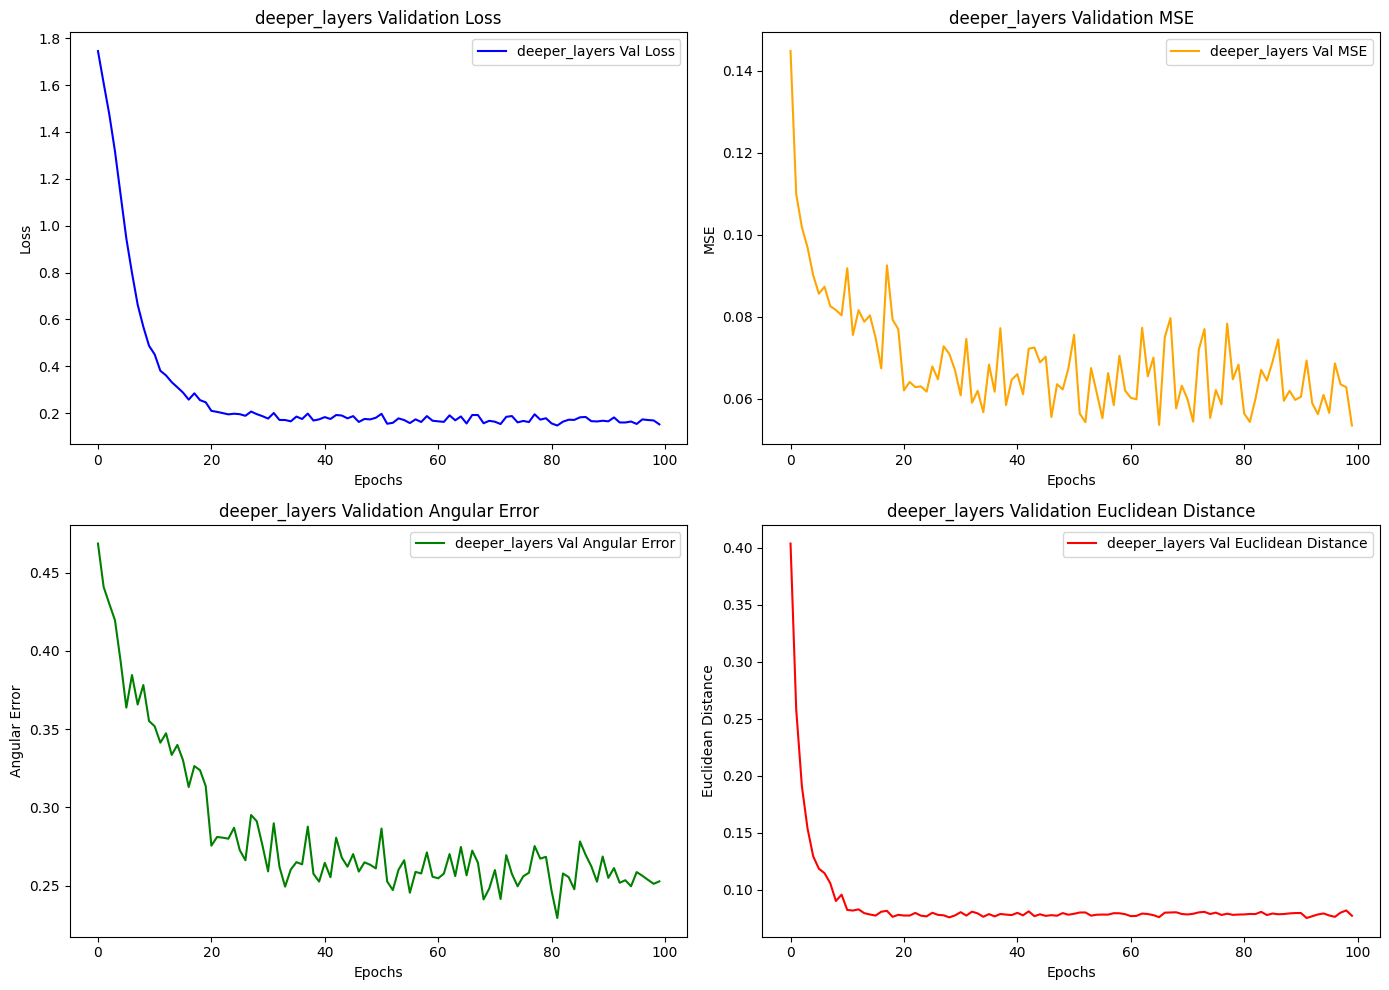

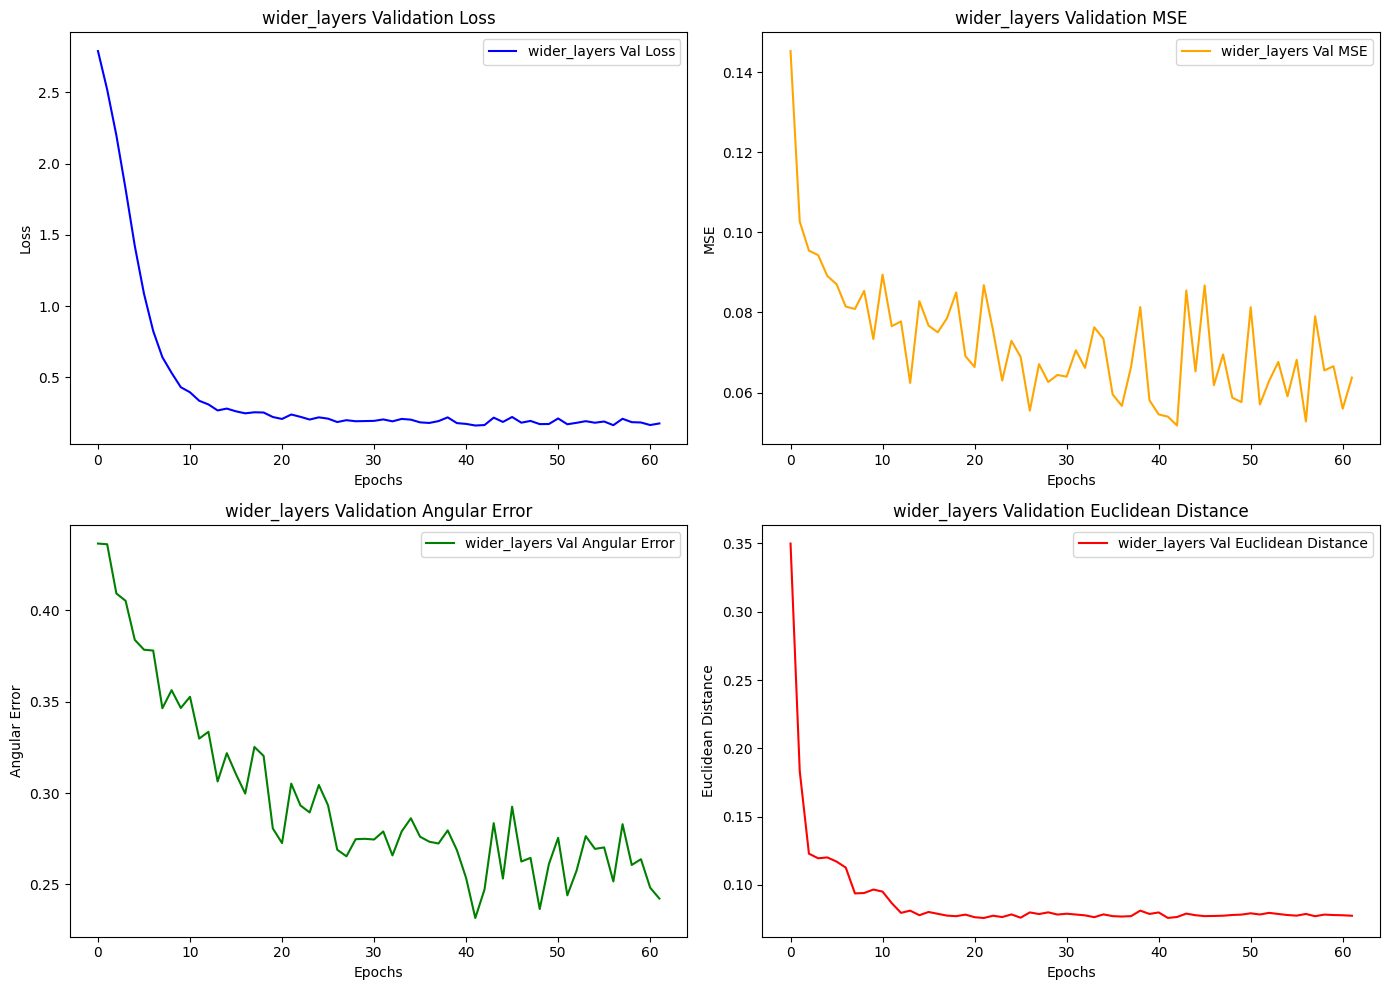

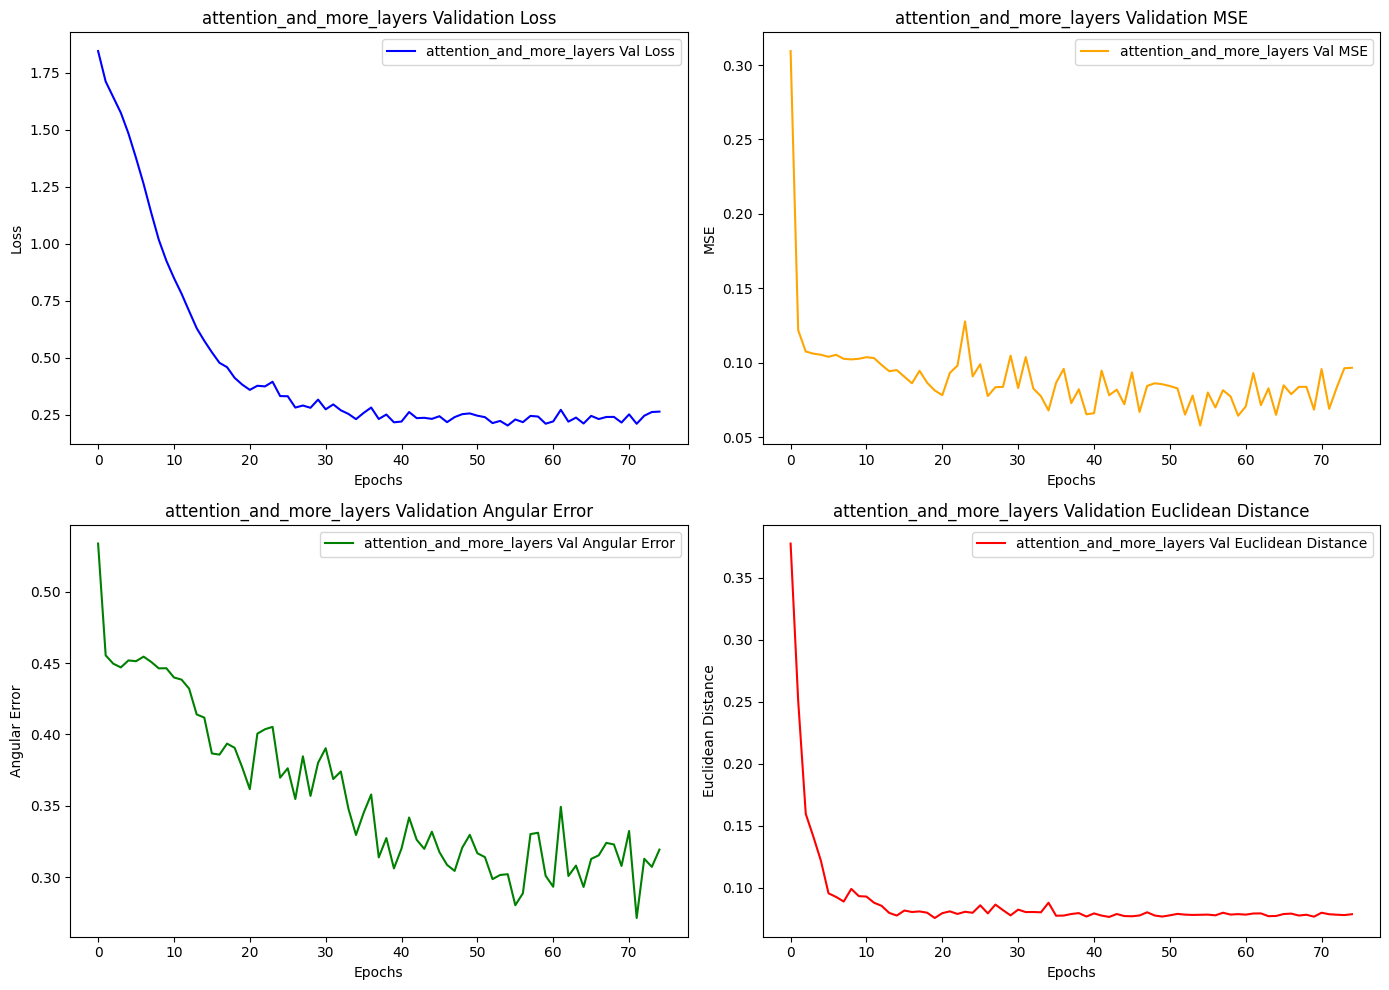

In [282]:
import matplotlib.pyplot as plt

architectures = ['without_attention', 'deeper_layers', 'wider_layers', 'attention_and_more_layers']

# Plot each architecture's metrics separately
for name in architectures:
    history = histories[name]
    
    plt.figure(figsize=(14, 10))
    

    plt.subplot(2, 2, 1)
    plt.plot(history['val_loss'], label=f'{name} Val Loss', color='blue')
    plt.title(f'{name} Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')


    plt.subplot(2, 2, 2)
    plt.plot(history['val_mse'], label=f'{name} Val MSE', color='orange')
    plt.title(f'{name} Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend(loc='upper right')


    plt.subplot(2, 2, 3)
    plt.plot(history['val_custom_angular_error'], label=f'{name} Val Angular Error', color='green')
    plt.title(f'{name} Validation Angular Error')
    plt.xlabel('Epochs')
    plt.ylabel('Angular Error')
    plt.legend(loc='upper right')


    plt.subplot(2, 2, 4)
    plt.plot(history['val_custom_euclidean_distance'], label=f'{name} Val Euclidean Distance', color='red')
    plt.title(f'{name} Validation Euclidean Distance')
    plt.xlabel('Epochs')
    plt.ylabel('Euclidean Distance')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


You must install pydot (`pip install pydot`) for `plot_model` to work.


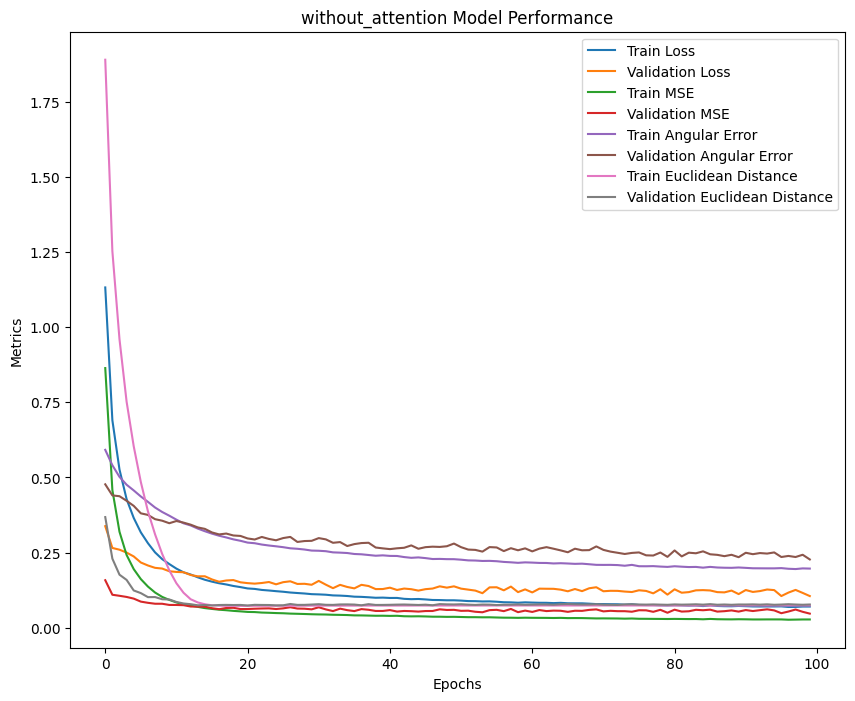

You must install pydot (`pip install pydot`) for `plot_model` to work.


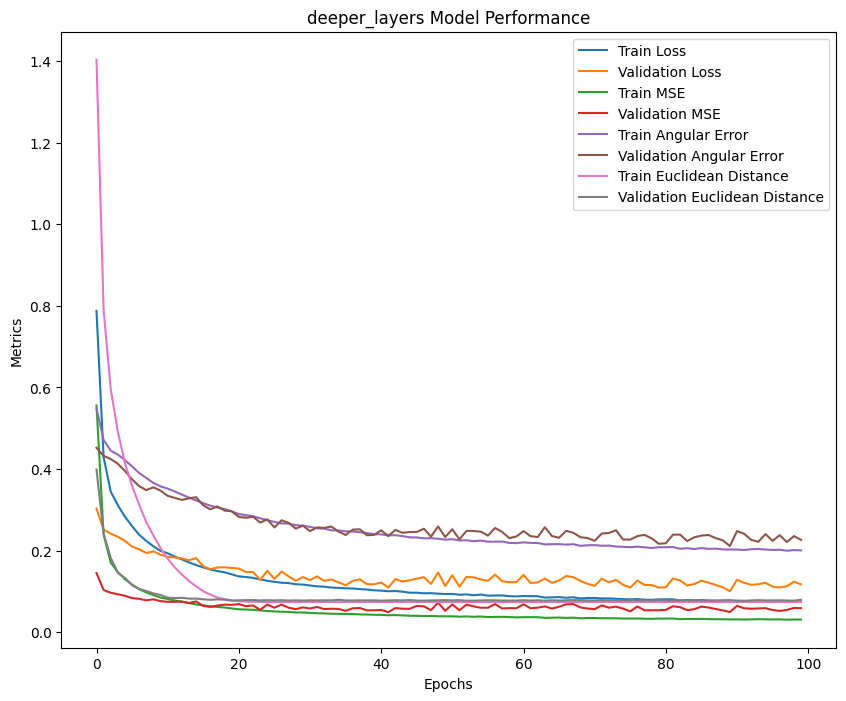

You must install pydot (`pip install pydot`) for `plot_model` to work.


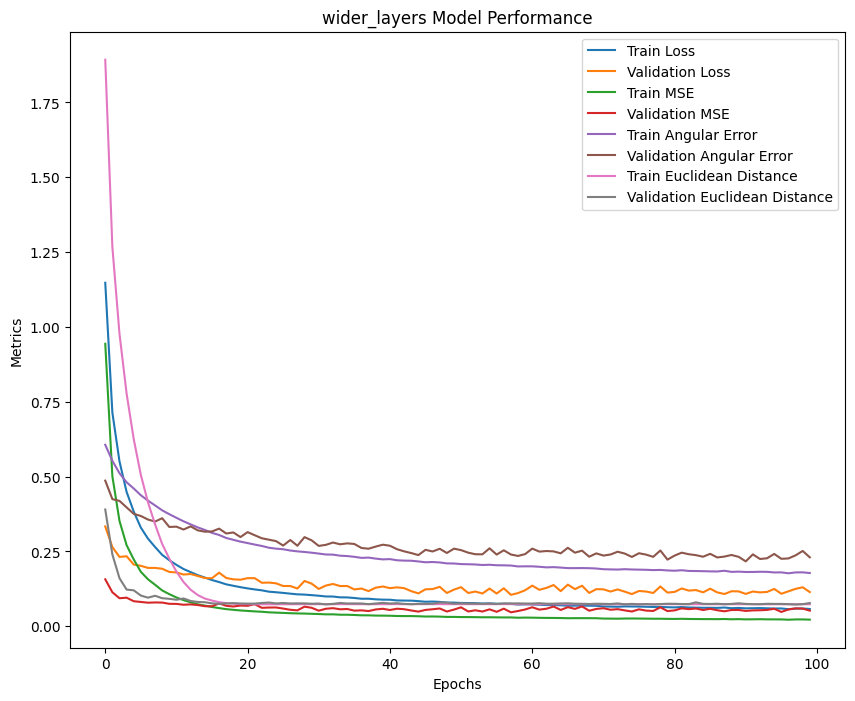

You must install pydot (`pip install pydot`) for `plot_model` to work.


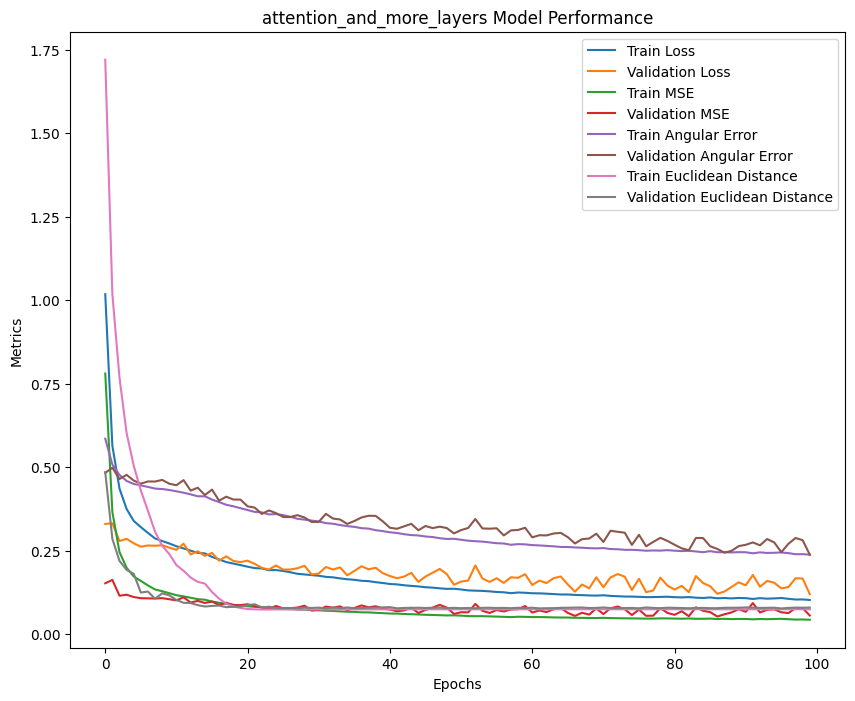

In [288]:
architectures = {
    'without_attention': model_without_attention,
    'deeper_layers': model_deeper_layers,
    'wider_layers': model_wider_layers,
    'attention_and_more_layers': model_attention_and_more_layers,
}
import os
import tensorflow.keras.utils as utils
import matplotlib.pyplot as plt

# Directory to save architecture diagrams
arch_dir = "model_architectures"
os.makedirs(arch_dir, exist_ok=True)


for name, model in architectures.items():

    arch_path = os.path.join(arch_dir, f'{name}_architecture.png')
    utils.plot_model(model, to_file=arch_path, show_shapes=True)
    
 
    plt.figure(figsize=(10, 8))
    plt.plot(histories[name]['loss'], label='Train Loss')
    plt.plot(histories[name]['val_loss'], label='Validation Loss')
    plt.plot(histories[name]['mse'], label='Train MSE')
    plt.plot(histories[name]['val_mse'], label='Validation MSE')
    plt.plot(histories[name]['custom_angular_error'], label='Train Angular Error')
    plt.plot(histories[name]['val_custom_angular_error'], label='Validation Angular Error')
    plt.plot(histories[name]['custom_euclidean_distance'], label='Train Euclidean Distance')
    plt.plot(histories[name]['val_custom_euclidean_distance'], label='Validation Euclidean Distance')
    plt.title(f'{name} Model Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()


In [289]:

# 1. Without Attention
model_without_attention = build_model_without_attention()
history_without_attention = model_without_attention.fit(X_train, y_train, 
                                                        validation_data=(X_val, y_val), 
                                                        epochs=500, batch_size=16).history

# 2. Deeper Layers
model_deeper_layers = build_model_deeper_layers()
history_deeper_layers = model_deeper_layers.fit(X_train, y_train, 
                                                validation_data=(X_val, y_val), 
                                                epochs=500, batch_size=16).history

# 3. Wider Layers
model_wider_layers = build_model_wider_layers()
history_wider_layers = model_wider_layers.fit(X_train, y_train, 
                                              validation_data=(X_val, y_val), 
                                              epochs=500, batch_size=16).history

# 4. Attention and More Layers
model_attention_and_more_layers = build_model_attention_and_more_layers()
history_attention_and_more_layers = model_attention_and_more_layers.fit(X_train, y_train, 
                                                                        validation_data=(X_val, y_val), 
                                                                        epochs=100, batch_size=16).history

histories = {
    'without_attention': history_without_attention,
    'deeper_layers': history_deeper_layers,
    'wider_layers': history_wider_layers,
    'attention_and_more_layers': history_attention_and_more_layers,
}


Epoch 1/500
912/912 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - custom_angular_error: 0.6062 - custom_euclidean_distance: 2.1326 - loss: 1.3242 - mae: 0.7955 - mse: 1.0404 - val_custom_angular_error: 0.4705 - val_custom_euclidean_distance: 0.4163 - val_loss: 0.3274 - val_mae: 0.2743 - val_mse: 0.1508
Epoch 2/500
912/912 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - custom_angular_error: 0.5527 - custom_euclidean_distance: 1.2960 - loss: 0.7245 - mae: 0.5369 - mse: 0.4983 - val_custom_angular_error: 0.4348 - val_custom_euclidean_distance: 0.2627 - val_loss: 0.2776 - val_mae: 0.2218 - val_mse: 0.1201
Epoch 3/500
912/912 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - custom_angular_error: 0.5102 - custom_euclidean_distance: 0.9572 - loss: 0.5341 - mae: 0.4263 - mse: 0.3323 - val_custom_angular_error: 0.4208 - val_custom_euclidean_distance: 0.1853 - val_loss: 0.2485 - val_mae: 0.1939 - val_mse: 0.1012
Epoch 4/500
912/912 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - custom_angular_error: 0.4824 - custom_euclidean_distance: 0.7517 -

In [290]:
# Define the list of architectures and their corresponding models
architectures = {
    'without_attention': model_without_attention,
    'deeper_layers': model_deeper_layers,
    'wider_layers': model_wider_layers,
    'attention_and_more_layers': model_attention_and_more_layers,
}


You must install pydot (`pip install pydot`) for `plot_model` to work.


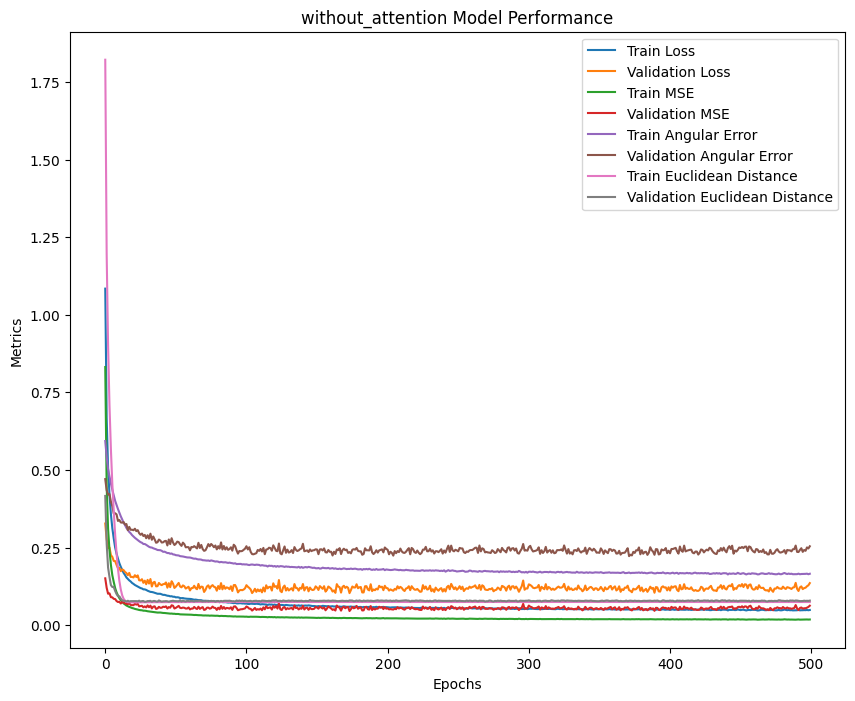

You must install pydot (`pip install pydot`) for `plot_model` to work.


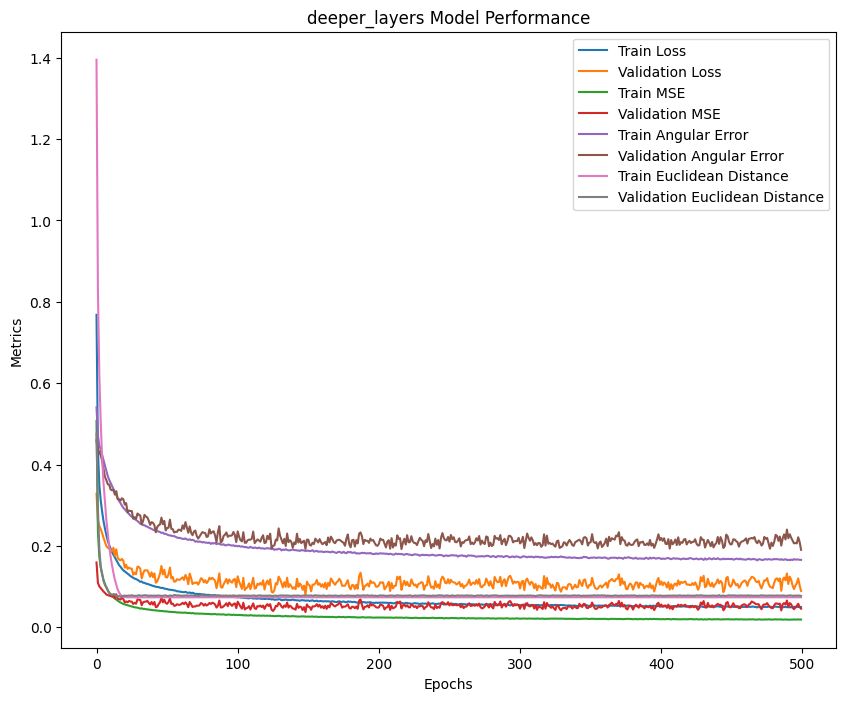

You must install pydot (`pip install pydot`) for `plot_model` to work.


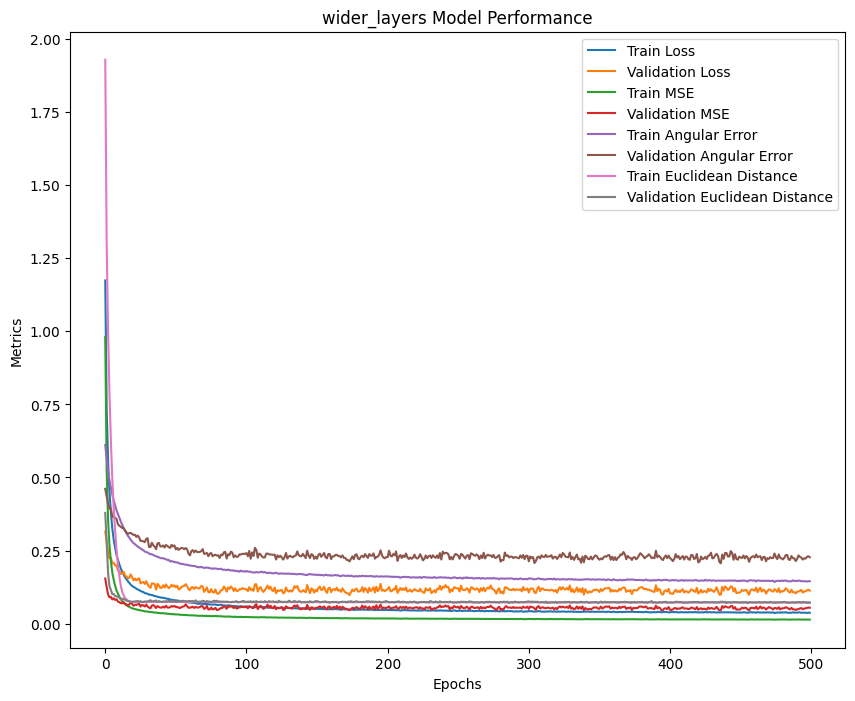

You must install pydot (`pip install pydot`) for `plot_model` to work.


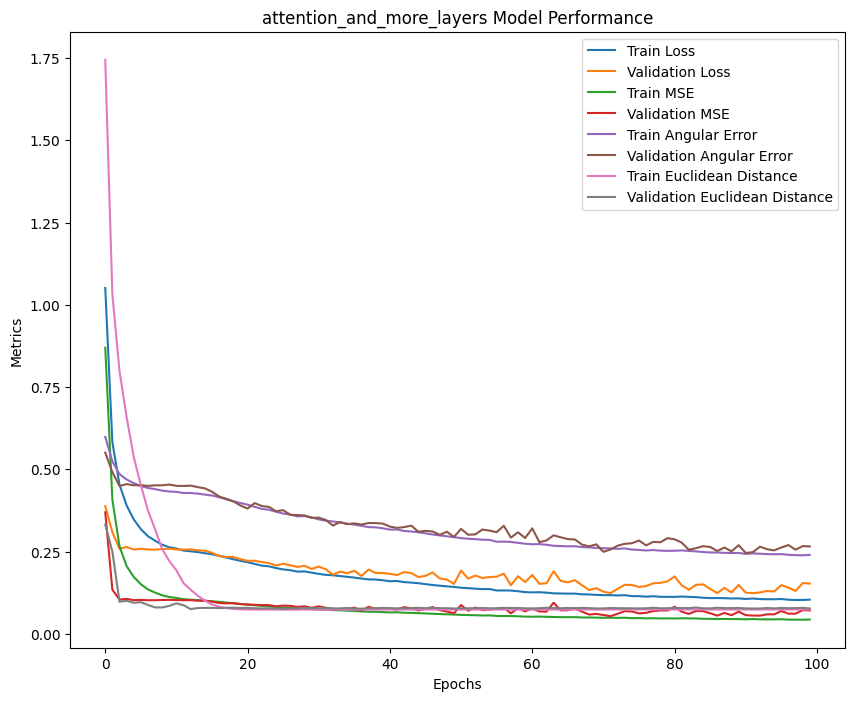

In [291]:
import os
import tensorflow.keras.utils as utils
import matplotlib.pyplot as plt

# Directory to save architecture diagrams
arch_dir = "model_architectures"
os.makedirs(arch_dir, exist_ok=True)

# Plot each architecture's metrics and save the architecture diagram
for name, model in architectures.items():
    # Save the architecture plot
    arch_path = os.path.join(arch_dir, f'{name}_architecture.png')
    utils.plot_model(model, to_file=arch_path, show_shapes=True)
    
    # Plot the training history
    plt.figure(figsize=(10, 8))
    plt.plot(histories[name]['loss'], label='Train Loss')
    plt.plot(histories[name]['val_loss'], label='Validation Loss')
    plt.plot(histories[name]['mse'], label='Train MSE')
    plt.plot(histories[name]['val_mse'], label='Validation MSE')
    plt.plot(histories[name]['custom_angular_error'], label='Train Angular Error')
    plt.plot(histories[name]['val_custom_angular_error'], label='Validation Angular Error')
    plt.plot(histories[name]['custom_euclidean_distance'], label='Train Euclidean Distance')
    plt.plot(histories[name]['val_custom_euclidean_distance'], label='Validation Euclidean Distance')
    plt.title(f'{name} Model Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.show()


Num GPUs Available:  0
Epoch 1/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.5239 - mae: 0.7905 - mse: 1.0278 - val_loss: 0.6227 - val_mae: 0.2696 - val_mse: 0.1364 - learning_rate: 1.0000e-04
Epoch 2/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.9384 - mae: 0.5247 - mse: 0.4570 - val_loss: 0.5743 - val_mae: 0.2270 - val_mse: 0.1099 - learning_rate: 1.0000e-04
Epoch 3/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7771 - mae: 0.4347 - mse: 0.3199 - val_loss: 0.5369 - val_mae: 0.2053 - val_mse: 0.1043 - learning_rate: 1.0000e-04
Epoch 4/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6614 - mae: 0.3698 - mse: 0.2386 - val_loss: 0.4917 - val_mae: 0.1945 - val_mse: 0.1013 - learning_rate: 1.0000e-04
Epoch 5/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5664 - mae: 0.3225 - mse: 0.1885 - val_loss: 0.4349 - val_mae: 0.1858 - val_mse: 0.0967 - learning_rate: 1.0000e-04
Epoch 6/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4756 - mae: 0.2808 

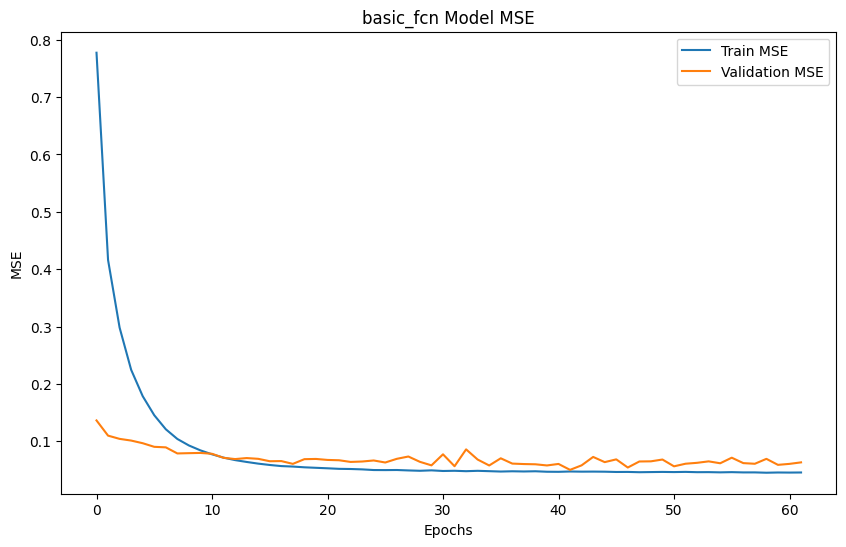

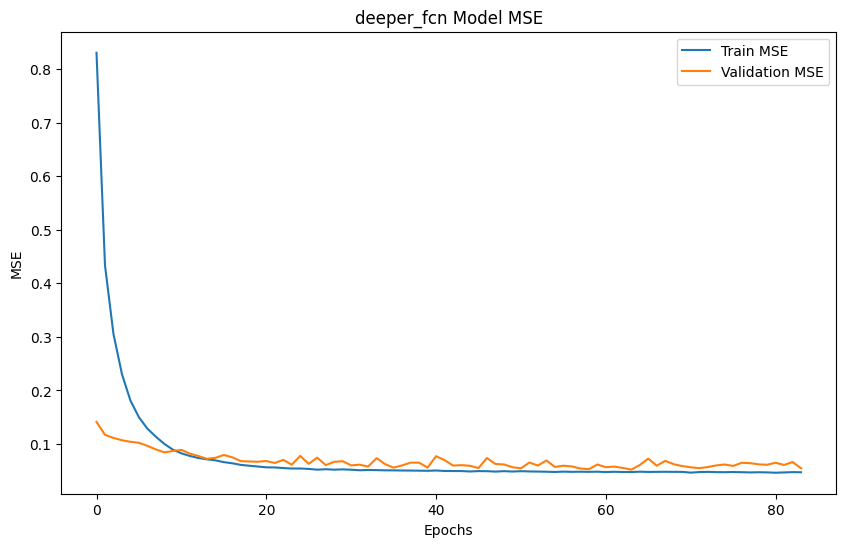

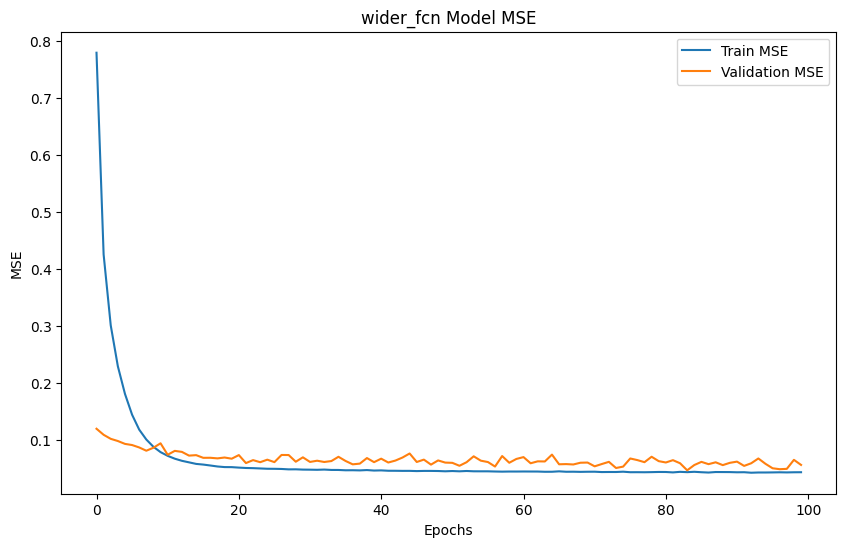

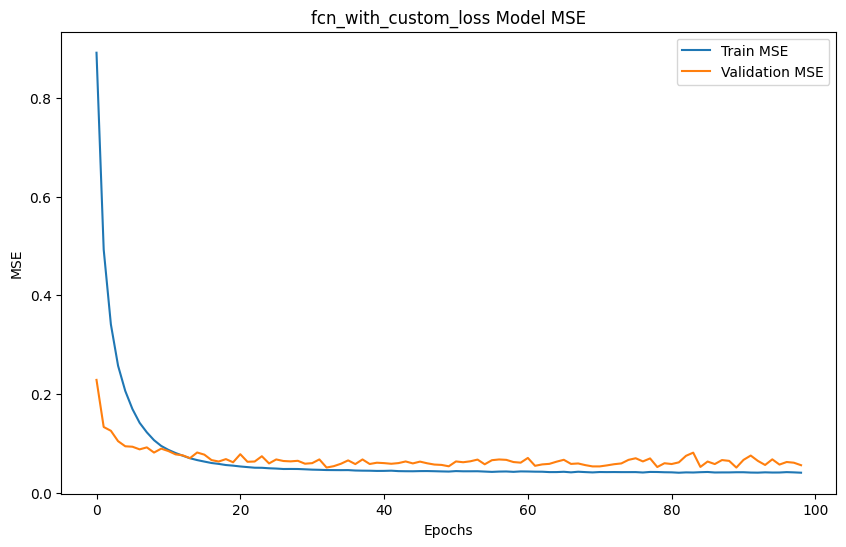

basic_fcn Test MSE: 0.07224413752555847
deeper_fcn Test MSE: 0.06635215133428574
wider_fcn Test MSE: 0.0620969794690609
fcn_with_custom_loss Test MSE: 0.06996291875839233


In [294]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

experiment_dir = "experiments"
os.makedirs(experiment_dir, exist_ok=True)
history_file = os.path.join(experiment_dir, 'model_architecture_history.csv')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

def build_fcn_model(input_shape, num_layers=3, units_per_layer=128, dropout_rate=0.3):
    input_layer = Input(shape=(input_shape,))
    x = input_layer

    for _ in range(num_layers):
        x = Dense(units=units_per_layer, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Dropout(dropout_rate)(x)

    output_layer = Dense(9)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Custom loss function
def custom_loss(y_true, y_pred):
    coords_true = y_true[:, :6] 
    coords_pred = y_pred[:, :6]
    rotations_true = y_true[:, 6:]
    rotations_pred = y_pred[:, 6:]

    coords_loss = tf.reduce_mean(tf.square(coords_true - coords_pred))
    rotations_loss = tf.reduce_mean(tf.square(tf.sin(rotations_true - rotations_pred)))

    total_loss = coords_loss + rotations_loss
    return total_loss

# Training and evaluation function
def train_and_evaluate_model(name, input_shape, X_train, y_train, X_val, y_val, X_test, y_test, num_layers=3, units_per_layer=128, dropout_rate=0.3, use_custom_loss=False):
    model = build_fcn_model(input_shape, num_layers=num_layers, units_per_layer=units_per_layer, dropout_rate=dropout_rate)
    loss_function = custom_loss if use_custom_loss else 'mse'
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss=loss_function, 
                  metrics=['mse', 'mae'])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                        callbacks=[reduce_lr, early_stopping], batch_size=16, verbose=1)

    test_loss, test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)

    history_df = pd.DataFrame(history.history)
    history_df['model_name'] = name
    history_df['num_layers'] = num_layers
    history_df['units_per_layer'] = units_per_layer
    history_df['dropout_rate'] = dropout_rate
    history_df['use_custom_loss'] = use_custom_loss
    history_df['test_mse'] = test_mse
    history_df.to_csv(history_file, mode='a', header=not os.path.exists(history_file), index=False)

    return model, history_df, test_mse

# different architecture configurations
architectures = [
    {'name': 'basic_fcn', 'num_layers': 3, 'units_per_layer': 128, 'dropout_rate': 0.3, 'use_custom_loss': False},
    {'name': 'deeper_fcn', 'num_layers': 5, 'units_per_layer': 128, 'dropout_rate': 0.3, 'use_custom_loss': False},
    {'name': 'wider_fcn', 'num_layers': 3, 'units_per_layer': 256, 'dropout_rate': 0.3, 'use_custom_loss': False},
    {'name': 'fcn_with_custom_loss', 'num_layers': 3, 'units_per_layer': 128, 'dropout_rate': 0.3, 'use_custom_loss': True},

]

input_shape = X_train.shape[1]
histories = []
mse_results = {}

# Train and evaluate models for each architecture
for config in architectures:
    model, history_df, test_mse = train_and_evaluate_model(
        name=config['name'],
        input_shape=input_shape,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        num_layers=config['num_layers'],
        units_per_layer=config['units_per_layer'],
        dropout_rate=config['dropout_rate'],
        use_custom_loss=config['use_custom_loss']
    )
    
    histories.append(history_df)
    mse_results[config['name']] = test_mse

# Plot results
for history in histories:
    plt.figure(figsize=(10, 6))
    plt.plot(history['mse'], label='Train MSE')
    plt.plot(history['val_mse'], label='Validation MSE')
    plt.title(f"{history['model_name'].iloc[0]} Model MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()

# Display the MSE results for different architectures
for name, mse in mse_results.items():
    print(f"{name} Test MSE: {mse}")



Num GPUs Available:  0
Input shape to SelfAttentionWithPositionalEncoding: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of q: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of k: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of v: (None, 1, 512), dtype: <dtype: 'float32'>
pos dtype: <dtype: 'float32'>, i dtype: <dtype: 'float32'>, d_model: Tensor("strided_slice_1:0", shape=(), dtype=int32)
angle_rates dtype: <dtype: 'float32'>
Positional encoding shape: (1, 1, 512), dtype: <dtype: 'float32'>


Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_36 (InputLayer)     │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_103 (LeakyReLU)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer_7             │ (None, 1, 512)         │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_with_positional… │ (None, 1, 512)         │     1,048,576 │
│ (SelfAttentionWithPositionalEn… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_129 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_104 (LeakyReLU)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_130 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_105         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_105 (LeakyReLU)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_106         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_106 (LeakyReLU)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,499,081 (9.53 MB)

 Trainable params: 2,496,521 (9.52 MB)

 Non-trainable params: 2,560 (10.00 KB)

None
Epoch 1/100
Input shape to SelfAttentionWithPositionalEncoding: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of q: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of k: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of v: (None, 1, 512), dtype: <dtype: 'float32'>
pos dtype: <dtype: 'float32'>, i dtype: <dtype: 'float32'>, d_model: Tensor("functional_51_1/self_attention_with_positional_encoding_10_1/strided_slice_1:0", shape=(), dtype=int32)
angle_rates dtype: <dtype: 'float32'>
Positional encoding shape: (1, 1, 512), dtype: <dtype: 'float32'>
Input shape to SelfAttentionWithPositionalEncoding: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of q: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of k: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of v: (None, 1, 512), dtype: <dtype: 'float32'>
pos dtype: <dtype: 'float32'>, i dtype: <dtype: 'float32'>, d_model: Tensor("functional_51_1/self_attention_with_positional_encoding_10_1/strided_slice_1:0", shape=(), dtype=int32)
angle

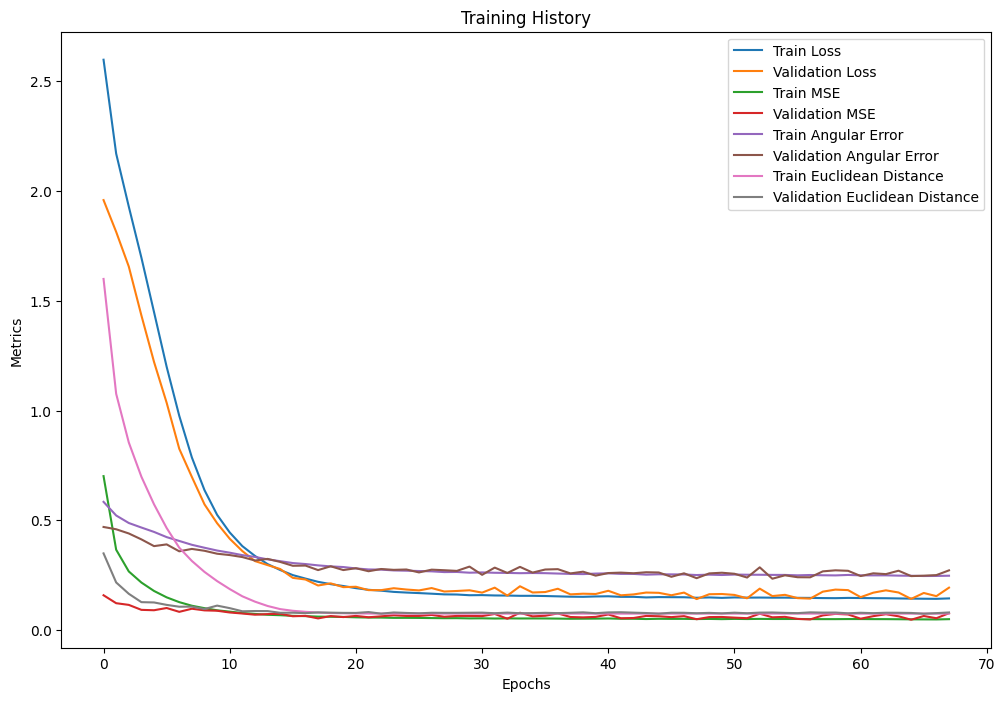

In [313]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout, Flatten, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Softmax
import os
import pandas as pd
import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

class SelfAttentionWithPositionalEncoding(Layer):
    def __init__(self, units):
        super(SelfAttentionWithPositionalEncoding, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.Wq = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wk = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wv = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wo = self.add_weight(shape=(self.units, input_shape[-1]),
                                  initializer='random_normal',
                                  trainable=True)

    def call(self, inputs):
        print(f"Input shape to SelfAttentionWithPositionalEncoding: {inputs.shape}, dtype: {inputs.dtype}")
        
        q = tf.matmul(inputs, self.Wq)
        k = tf.matmul(inputs, self.Wk)
        v = tf.matmul(inputs, self.Wv)

        print(f"Shape of q: {q.shape}, dtype: {q.dtype}")
        print(f"Shape of k: {k.shape}, dtype: {k.dtype}")
        print(f"Shape of v: {v.shape}, dtype: {v.dtype}")

        # Ensure that the positional encoding matches the data type of q and k
        pos_encoding = tf.cast(self.positional_encoding(tf.shape(inputs)[1], tf.shape(inputs)[2]), dtype=q.dtype)
        print(f"Positional encoding shape: {pos_encoding.shape}, dtype: {pos_encoding.dtype}")

        q += pos_encoding
        k += pos_encoding

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = Softmax()(attention_scores)

        attention_output = tf.matmul(attention_scores, v)
        output = tf.matmul(attention_output, self.Wo)

        return output + inputs  # Add residual connection

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                     tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                     d_model)
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return pos_encoding

    def get_angles(self, pos, i, d_model):
        print(f"pos dtype: {pos.dtype}, i dtype: {i.dtype}, d_model: {d_model}")
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        print(f"angle_rates dtype: {angle_rates.dtype}")
        return pos * angle_rates

# Custom Layer for Expanding Dimensions
class ExpandDimsLayer(Layer):
    def __init__(self, axis):
        super(ExpandDimsLayer, self).__init__()
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

# Custom Loss Function
def custom_loss(y_true, y_pred):
    coords_true = y_true[:, :6]
    coords_pred = y_pred[:, :6]
    rotations_true = y_true[:, 6:]
    rotations_pred = y_pred[:, 6:]

    coords_loss = tf.reduce_mean(tf.square(coords_true - coords_pred))
    rotations_loss = tf.reduce_mean(tf.square(tf.sin(rotations_true - rotations_pred)))

    total_loss = coords_loss + rotations_loss
    return total_loss

# Custom Metrics
def custom_angular_error(y_true, y_pred):
    rotations_true = y_true[:, 6:] 
    rotations_pred = y_pred[:, 6:]
    angular_error = tf.reduce_mean(tf.abs(tf.sin(rotations_true - rotations_pred)))
    return angular_error

def custom_euclidean_distance(y_true, y_pred):
    coords_true = y_true[:, :6] 
    coords_pred = y_pred[:, :6]
    euclidean_distance = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(coords_true - coords_pred), axis=-1)))
    return euclidean_distance

def build_model_with_attention_and_positional_encoding(input_shape):
    input_layer = Input(shape=(input_shape,))
    x = Dense(units=512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)

    x = ExpandDimsLayer(axis=1)(x)  # Add sequence dimension using custom layer
    attention_output = SelfAttentionWithPositionalEncoding(units=512)(x)

    x = Flatten()(attention_output)  # Flattening the output to match (None, 512)
    
    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.4)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    output_layer = Dense(9)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=custom_loss, 
                  metrics=['mse', 'mae', custom_angular_error, custom_euclidean_distance])
    return model

input_shape = X_train.shape[1]

# Build and compile the model
model = build_model_with_attention_and_positional_encoding(input_shape=input_shape)

print(model.summary())

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping], batch_size=16, verbose=1)

# Evaluate the model on test set
test_loss, test_mse, test_mae, test_angular_error, test_euclidean_distance = model.evaluate(X_test, y_test, verbose=0)

# Print the evaluation metrics
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test Angular Error: {test_angular_error}")
print(f"Test Euclidean Distance: {test_euclidean_distance}")

# Plot hist
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.plot(history.history['custom_angular_error'], label='Train Angular Error')
plt.plot(history.history['val_custom_angular_error'], label='Validation Angular Error')
plt.plot(history.history['custom_euclidean_distance'], label='Train Euclidean Distance')
plt.plot(history.history['val_custom_euclidean_distance'], label='Validation Euclidean Distance')
plt.legend()
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

history_df = pd.DataFrame(history.history)
history_file = os.path.join("experiments", "model_architecture_history_with_attention_positional_encoding.csv")
history_df.to_csv(history_file, index=False)


Num GPUs Available:  0


Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 2304)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3, 768)    │          0 │ input_layer_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 1, 768)    │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 1, 768)    │          0 │ reshape[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 1, 768)    │          0 │ reshape[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1, 64)     │    147,520 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1, 32)     │      6,176 │ conv1d[0][0],     │
│                     │                   │            │ conv1d[1][0],     │
│                     │                   │            │ conv1d[2][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1, 1)      │         97 │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_1[1][0],   │
│                     │                   │            │ conv1d_1[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 1)         │          0 │ conv1d_2[1][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 1)         │          0 │ conv1d_2[2][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3)         │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_133 (Dense)   │ (None, 512)       │      2,048 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_133[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_107     │ (None, 512)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_107         │ (None, 512)       │          0 │ leaky_re_lu_107[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 256)       │    131,328 │ dropout_107[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_134[0][0] 

 Total params: 426,186 (1.63 MB)

 Trainable params: 423,626 (1.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

None
Epoch 1/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - custom_angular_error: 0.5996 - custom_euclidean_distance: 1.9513 - loss: 2.0707 - mae: 0.7676 - mse: 1.0370 - val_custom_angular_error: 0.4583 - val_custom_euclidean_distance: 0.3214 - val_loss: 1.1351 - val_mae: 0.2441 - val_mse: 0.1344 - learning_rate: 1.0000e-04
Epoch 2/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - custom_angular_error: 0.5427 - custom_euclidean_distance: 1.1685 - loss: 1.4872 - mae: 0.5015 - mse: 0.4503 - val_custom_angular_error: 0.4582 - val_custom_euclidean_distance: 0.2149 - val_loss: 1.0758 - val_mae: 0.2136 - val_mse: 0.1153 - learning_rate: 1.0000e-04
Epoch 3/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - custom_angular_error: 0.5051 - custom_euclidean_distance: 0.9314 - loss: 1.3136 - mae: 0.4153 - mse: 0.3144 - val_custom_angular_error: 0.4579 - val_custom_euclidean_distance: 0.1652 - val_loss: 1.0262 - val_mae: 0.1998 - val_mse: 0.1088 - learning_rate: 1.0000e-04
Epoch 4/100
912/912 ━━━━━━━━━━━━

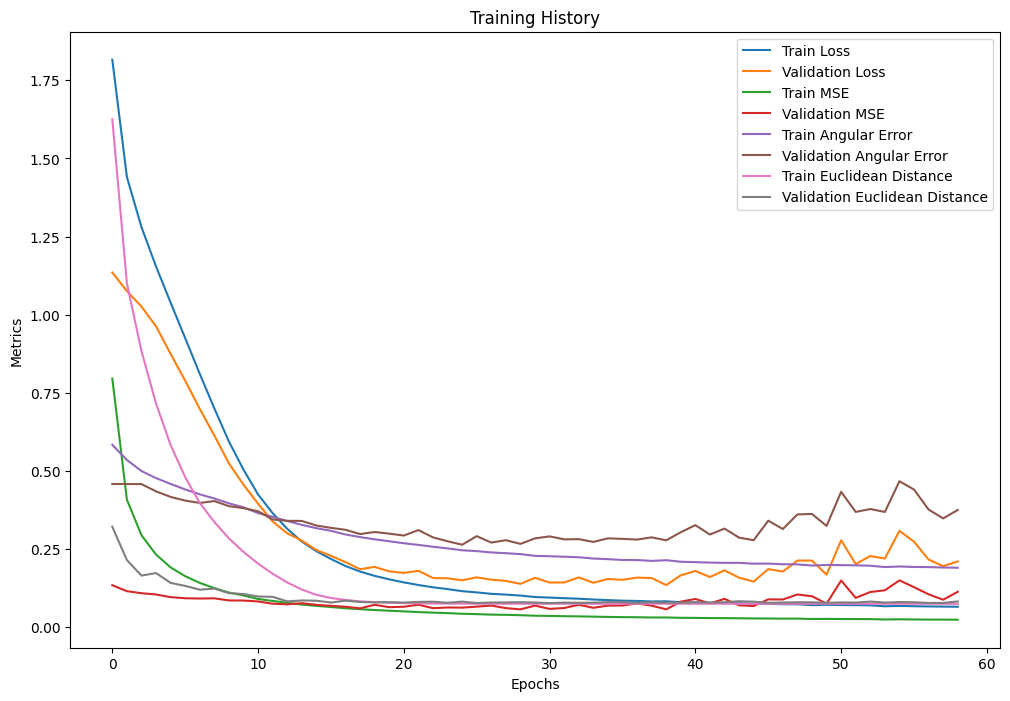

In [314]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout, Conv1D, Flatten, Reshape, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import pandas as pd
import matplotlib.pyplot as plt

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def custom_loss(y_true, y_pred):
    coords_true = y_true[:, :6]
    coords_pred = y_pred[:, :6]
    rotations_true = y_true[:, 6:]
    rotations_pred = y_pred[:, 6:]

    coords_loss = tf.reduce_mean(tf.square(coords_true - coords_pred))
    rotations_loss = tf.reduce_mean(tf.square(tf.sin(rotations_true - rotations_pred)))

    total_loss = coords_loss + rotations_loss
    return total_loss

def custom_angular_error(y_true, y_pred):
    rotations_true = y_true[:, 6:] 
    rotations_pred = y_pred[:, 6:]
    angular_error = tf.reduce_mean(tf.abs(tf.sin(rotations_true - rotations_pred)))
    return angular_error

def custom_euclidean_distance(y_true, y_pred):
    coords_true = y_true[:, :6] 
    coords_pred = y_pred[:, :6]
    euclidean_distance = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(coords_true - coords_pred), axis=-1)))
    return euclidean_distance

# Build the Model with 1D Convolution and FCN
def build_model_with_conv1d_and_fcn(input_shape):
    input_layer = Input(shape=(input_shape,))
    
    # Reshape the input into (None, 3, 768)
    reshaped_input = Reshape((3, 768))(input_layer)
    
    # Define a shared Conv1D layer to reduce each 768-dimensional vector to 256
    conv1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')
    conv2 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')
    conv3 = Conv1D(filters=1, kernel_size=3, padding='same', activation='relu')
    
    # Apply Conv1D to each of the three 768-dimensional vectors
    conv_output1 = conv3(conv2(conv1(reshaped_input[:, 0:1, :])))
    conv_output2 = conv3(conv2(conv1(reshaped_input[:, 1:2, :])))
    conv_output3 = conv3(conv2(conv1(reshaped_input[:, 2:3, :])))

    # Concatenate the outputs back into a single 768-dimensional vector
    concatenated_output = Concatenate(axis=-1)([Flatten()(conv_output1), Flatten()(conv_output2), Flatten()(conv_output3)])

    # Fully Connected Network (FCN) on the concatenated vector
    x = Dense(units=512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(concatenated_output)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.4)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    output_layer = Dense(9)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=custom_loss, 
                  metrics=['mse', 'mae', custom_angular_error, custom_euclidean_distance])
    return model

input_shape = X_train.shape[1]

# Build and compile the model
model = build_model_with_conv1d_and_fcn(input_shape=input_shape)

# Print model summary
print(model.summary())

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping], batch_size=16, verbose=1)

# Evaluate the model on the test set
test_loss, test_mse, test_mae, test_angular_error, test_euclidean_distance = model.evaluate(X_test, y_test, verbose=0)

# Print the evaluation metrics
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test Angular Error: {test_angular_error}")
print(f"Test Euclidean Distance: {test_euclidean_distance}")

# Plot the training history
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.plot(history.history['custom_angular_error'], label='Train Angular Error')
plt.plot(history.history['val_custom_angular_error'], label='Validation Angular Error')
plt.plot(history.history['custom_euclidean_distance'], label='Train Euclidean Distance')
plt.plot(history.history['val_custom_euclidean_distance'], label='Validation Euclidean Distance')
plt.legend()
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

# Save the history to a CSV file
history_df = pd.DataFrame(history.history)
history_file = os.path.join("experiments", "model_architecture_history_with_conv1d_fcn.csv")
history_df.to_csv(history_file, index=False)


Num GPUs Available:  0
Input shape to SelfAttentionWithPositionalEncoding: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of q: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of k: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of v: (None, 1, 512), dtype: <dtype: 'float32'>
pos dtype: <dtype: 'float32'>, i dtype: <dtype: 'float32'>, d_model: Tensor("strided_slice_1:0", shape=(), dtype=int32)
angle_rates dtype: <dtype: 'float32'>
Positional encoding shape: (1, 1, 512), dtype: <dtype: 'float32'>


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer_2             │ (None, 1, 512)         │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_with_positional… │ (None, 1, 512)         │     1,048,576 │
│ (SelfAttentionWithPositionalEn… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,499,081 (9.53 MB)

 Trainable params: 2,496,521 (9.52 MB)

 Non-trainable params: 2,560 (10.00 KB)

None
Epoch 1/80
Input shape to SelfAttentionWithPositionalEncoding: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of q: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of k: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of v: (None, 1, 512), dtype: <dtype: 'float32'>
pos dtype: <dtype: 'float32'>, i dtype: <dtype: 'float32'>, d_model: Tensor("functional_7_1/self_attention_with_positional_encoding_2_1/strided_slice_1:0", shape=(), dtype=int32)
angle_rates dtype: <dtype: 'float32'>
Positional encoding shape: (1, 1, 512), dtype: <dtype: 'float32'>
Input shape to SelfAttentionWithPositionalEncoding: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of q: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of k: (None, 1, 512), dtype: <dtype: 'float32'>
Shape of v: (None, 1, 512), dtype: <dtype: 'float32'>
pos dtype: <dtype: 'float32'>, i dtype: <dtype: 'float32'>, d_model: Tensor("functional_7_1/self_attention_with_positional_encoding_2_1/strided_slice_1:0", shape=(), dtype=int32)
angle_rate

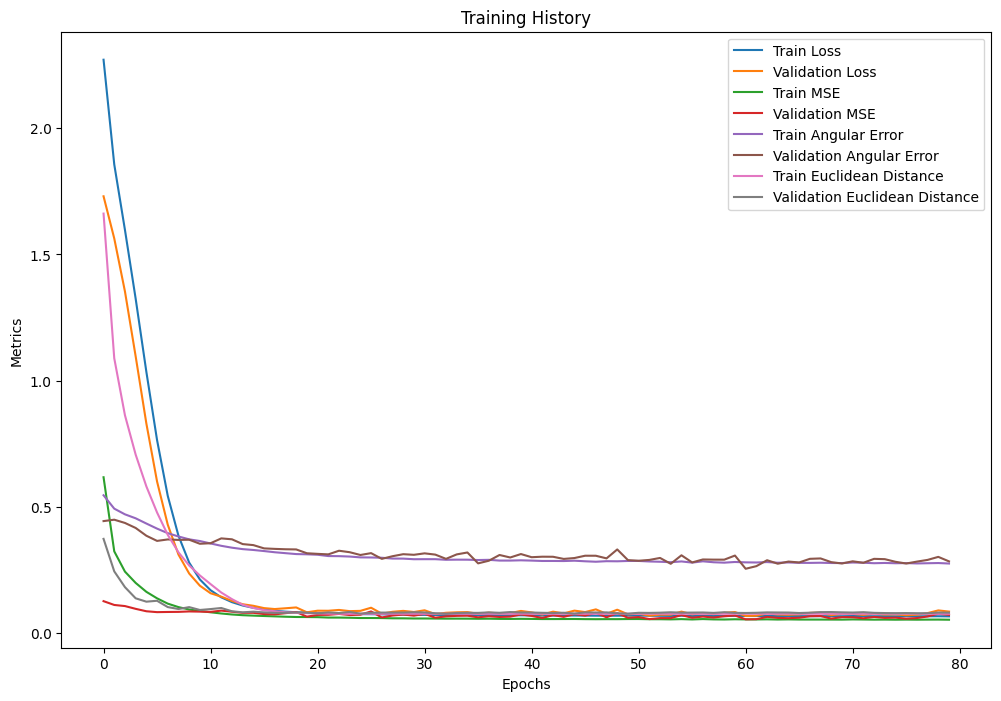

In [169]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout, Flatten, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Softmax
import os
import pandas as pd
import matplotlib.pyplot as plt

# Ensure GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Define the Self-Attention with Positional Encoding Layer
class SelfAttentionWithPositionalEncoding(Layer):
    def __init__(self, units):
        super(SelfAttentionWithPositionalEncoding, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.Wq = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wk = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wv = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wo = self.add_weight(shape=(self.units, input_shape[-1]),
                                  initializer='random_normal',
                                  trainable=True)

    def call(self, inputs):
        print(f"Input shape to SelfAttentionWithPositionalEncoding: {inputs.shape}, dtype: {inputs.dtype}")
        
        q = tf.matmul(inputs, self.Wq)
        k = tf.matmul(inputs, self.Wk)
        v = tf.matmul(inputs, self.Wv)

        print(f"Shape of q: {q.shape}, dtype: {q.dtype}")
        print(f"Shape of k: {k.shape}, dtype: {k.dtype}")
        print(f"Shape of v: {v.shape}, dtype: {v.dtype}")

        # Ensure that the positional encoding matches the data type of q and k
        pos_encoding = tf.cast(self.positional_encoding(tf.shape(inputs)[1], tf.shape(inputs)[2]), dtype=q.dtype)
        print(f"Positional encoding shape: {pos_encoding.shape}, dtype: {pos_encoding.dtype}")

        q += pos_encoding
        k += pos_encoding

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = Softmax()(attention_scores)

        attention_output = tf.matmul(attention_scores, v)
        output = tf.matmul(attention_output, self.Wo)

        return output + inputs  # Add residual connection

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                     tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                     d_model)
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return pos_encoding

    def get_angles(self, pos, i, d_model):
        print(f"pos dtype: {pos.dtype}, i dtype: {i.dtype}, d_model: {d_model}")
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        print(f"angle_rates dtype: {angle_rates.dtype}")
        return pos * angle_rates

# Custom Layer for Expanding Dimensions
class ExpandDimsLayer(Layer):
    def __init__(self, axis):
        super(ExpandDimsLayer, self).__init__()
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

# Custom Loss Function
def custom_loss(y_true, y_pred):
    coords_true = y_true[:, :6]
    coords_pred = y_pred[:, :6]
    rotations_true = y_true[:, 6:]
    rotations_pred = y_pred[:, 6:]

    coords_loss = tf.reduce_mean(tf.square(coords_true - coords_pred))
    rotations_loss = tf.reduce_mean(tf.square(tf.sin(rotations_true - rotations_pred)))

    total_loss = coords_loss + rotations_loss
    return total_loss

# Custom Metrics
def custom_angular_error(y_true, y_pred):
    rotations_true = y_true[:, 6:] 
    rotations_pred = y_pred[:, 6:]
    angular_error = tf.reduce_mean(tf.abs(tf.sin(rotations_true - rotations_pred)))
    return angular_error

def custom_euclidean_distance(y_true, y_pred):
    coords_true = y_true[:, :6] 
    coords_pred = y_pred[:, :6]
    euclidean_distance = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(coords_true - coords_pred), axis=-1)))
    return euclidean_distance

# Build the Model with Attention and Positional Encoding
def build_model_with_attention_and_positional_encoding(input_shape):
    input_layer = Input(shape=(input_shape,))
    x = Dense(units=512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)

    x = ExpandDimsLayer(axis=1)(x)  # Add sequence dimension using custom layer
    attention_output = SelfAttentionWithPositionalEncoding(units=512)(x)

    x = Flatten()(attention_output)  # Flattening the output to match (None, 512)
    
    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.4)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    output_layer = Dense(9)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='mse', 
                  metrics=['mse', 'mae', custom_angular_error, custom_euclidean_distance])
    return model

input_shape = X_train.shape[1]

# Build and compile the model
model = build_model_with_attention_and_positional_encoding(input_shape=input_shape)

# Print model summary
print(model.summary())

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=80, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping], batch_size=16, verbose=1)

# Evaluate the model on the test set
test_loss, test_mse, test_mae, test_angular_error, test_euclidean_distance = model.evaluate(X_test, y_test, verbose=0)

# Print the evaluation metrics
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test Angular Error: {test_angular_error}")
print(f"Test Euclidean Distance: {test_euclidean_distance}")

# Plot the training history
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.plot(history.history['custom_angular_error'], label='Train Angular Error')
plt.plot(history.history['val_custom_angular_error'], label='Validation Angular Error')
plt.plot(history.history['custom_euclidean_distance'], label='Train Euclidean Distance')
plt.plot(history.history['val_custom_euclidean_distance'], label='Validation Euclidean Distance')
plt.legend()
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

# Save the history to a CSV file
history_df = pd.DataFrame(history.history)
history_file = os.path.join("experiments", "model_architecture_history_with_attention_positional_encoding.csv")
history_df.to_csv(history_file, index=False)


Num GPUs Available:  0


Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_39 (InputLayer)     │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 3, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 3, 64)          │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 3, 1)           │            97 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_112 (LeakyReLU)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer_8             │ (None, 1, 512)         │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_11               │ (None, 1, 512)         │     1,048,576 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_140 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_113 (LeakyReLU)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_141 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_114 (LeakyReLU)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_142 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,474,762 (5.63 MB)

 Trainable params: 1,472,202 (5.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

None
Epoch 1/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 1.7407 - mae: 0.7034 - mse: 0.8873 - val_loss: 0.9390 - val_mae: 0.2114 - val_mse: 0.1095 - learning_rate: 1.0000e-04
Epoch 2/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 1.1641 - mae: 0.4299 - mse: 0.3461 - val_loss: 0.8861 - val_mae: 0.1996 - val_mse: 0.1090 - learning_rate: 1.0000e-04
Epoch 3/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 1.0212 - mae: 0.3726 - mse: 0.2614 - val_loss: 0.8099 - val_mae: 0.1913 - val_mse: 0.1093 - learning_rate: 1.0000e-04
Epoch 4/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.8938 - mae: 0.3352 - mse: 0.2168 - val_loss: 0.7045 - val_mae: 0.1849 - val_mse: 0.1049 - learning_rate: 1.0000e-04
Epoch 5/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.7596 - mae: 0.3026 - mse: 0.1890 - val_loss: 0.5868 - val_mae: 0.1953 - val_mse: 0.1066 - learning_rate: 1.0000e-04
Epoch 6/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.6201 - mae: 0.2895 - mse: 0.1

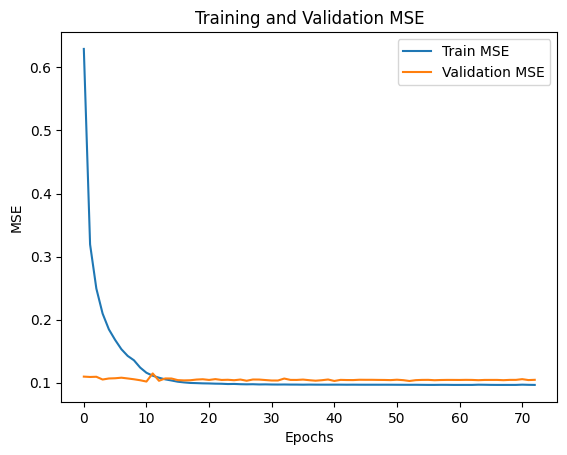

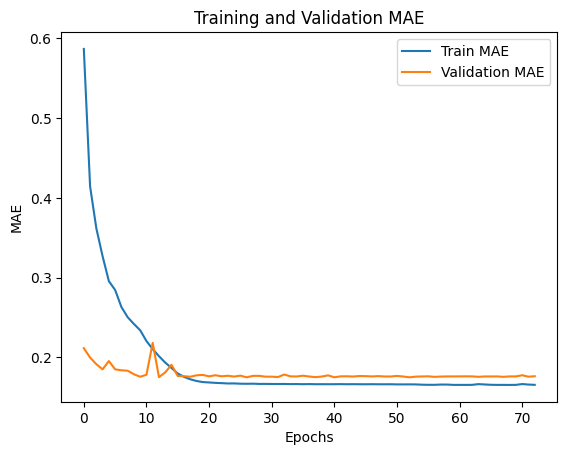

In [316]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, BatchNormalization, LeakyReLU, Dropout, Reshape, Layer, Softmax, Add, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Ensure GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Create the directory for saving experiment results
experiment_dir = "experiments"
os.makedirs(experiment_dir, exist_ok=True)
history_file = os.path.join(experiment_dir, 'model_with_attention_history.csv')

# Custom layer to expand dimensions
class ExpandDimsLayer(Layer):
    def __init__(self, axis):
        super(ExpandDimsLayer, self).__init__()
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

# Define the Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.Wq = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wk = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wv = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wo = self.add_weight(shape=(self.units, input_shape[-1]),
                                  initializer='random_normal',
                                  trainable=True)

    def call(self, inputs):
        q = tf.matmul(inputs, self.Wq)
        k = tf.matmul(inputs, self.Wk)
        v = tf.matmul(inputs, self.Wv)

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = Softmax()(attention_scores)

        attention_output = tf.matmul(attention_scores, v)
        output = tf.matmul(attention_output, self.Wo)

        return output + inputs  # Add residual connection

# Function to build the model with Conv1D, Self-Attention, and FCN layers
def build_model_with_attention(input_shape):
    # Input Layer
    input_layer = Input(shape=(input_shape,))
    
    # Reshape the input to apply Conv1D to each 768-dimensional feature vector separately
    reshaped_input = Reshape((3, 768))(input_layer)

    # 1D Convolutions to reduce dimensionality from 768 to 256
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(reshaped_input)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(filters=1, kernel_size=3, padding='same', activation='relu')(x)

    # Flatten the output back to 1D (concatenating the 256-dimensional vectors from each of the 3 original vectors)
    x = Flatten()(x)

    # Fully Connected Layers
    x = Dense(units=512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)

    # Attention Layer with expanded dimensions
    x = ExpandDimsLayer(axis=1)(x)  # Add sequence dimension using custom layer
    attention_output = SelfAttention(units=512)(x)
    attention_output = Flatten()(attention_output)  # Flatten back to 1D after attention

    # Further Fully Connected Layers
    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention_output)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.4)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    # Output Layer
    output_layer = Dense(9)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='mse', 
                  metrics=['mse', 'mae'])
    return model

input_shape = X_train.shape[1]

# Build and compile the model
model = build_model_with_attention(input_shape=input_shape)

# Print model summary
print(model.summary())

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping], batch_size=16, verbose=1)

# Evaluate the model on the test set
test_loss, test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

# Save the history to the CSV
history_df = pd.DataFrame(history.history)
history_df['model_name'] = 'model_with_attention'
history_df['test_mse'] = test_mse
history_df['test_mae'] = test_mae
history_df.to_csv(history_file, mode='a', header=not os.path.exists(history_file), index=False)

# Plot the training history
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


Num GPUs Available:  0


Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)     │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 3, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 3, 64)          │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 3, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 3, 1)           │            97 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_116         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_116 (LeakyReLU)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer_9             │ (None, 1, 512)         │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_12               │ (None, 1, 512)         │     1,048,576 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_117 (LeakyReLU)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_146 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_118         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_118 (LeakyReLU)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_147 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,474,762 (5.63 MB)

 Trainable params: 1,472,202 (5.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

None
Epoch 1/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1.6701 - mae: 0.6884 - mse: 0.8144 - val_loss: 0.9493 - val_mae: 0.2302 - val_mse: 0.1202 - learning_rate: 1.0000e-04
Epoch 2/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 1.1506 - mae: 0.4340 - mse: 0.3342 - val_loss: 0.8817 - val_mae: 0.1965 - val_mse: 0.1096 - learning_rate: 1.0000e-04
Epoch 3/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 1.0028 - mae: 0.3656 - mse: 0.2491 - val_loss: 0.8036 - val_mae: 0.1946 - val_mse: 0.1115 - learning_rate: 1.0000e-04
Epoch 4/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.8708 - mae: 0.3244 - mse: 0.2026 - val_loss: 0.6989 - val_mae: 0.1919 - val_mse: 0.1071 - learning_rate: 1.0000e-04
Epoch 5/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.7351 - mae: 0.2913 - mse: 0.1707 - val_loss: 0.5876 - val_mae: 0.1913 - val_mse: 0.1074 - learning_rate: 1.0000e-04
Epoch 6/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.6015 - mae: 0.2682 - mse: 0.1

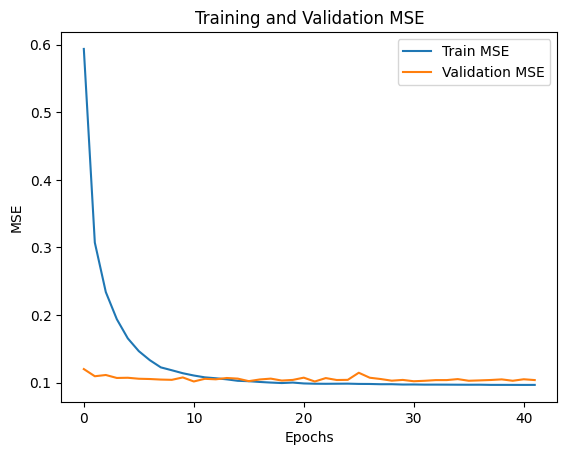

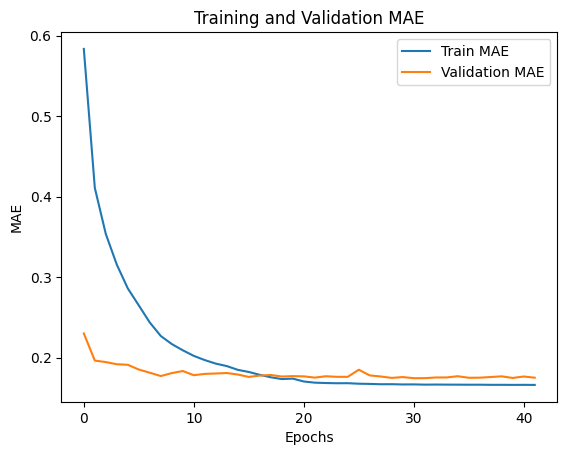

In [317]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, BatchNormalization, LeakyReLU, Dropout, Reshape, Layer, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Ensure GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Create the directory for saving experiment results
experiment_dir = "experiments"
os.makedirs(experiment_dir, exist_ok=True)
history_file = os.path.join(experiment_dir, 'model_with_attention_and_conv1d_history.csv')

# Custom layer to expand dimensions
class ExpandDimsLayer(Layer):
    def __init__(self, axis):
        super(ExpandDimsLayer, self).__init__()
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

# Define the Self-Attention Layer
class SelfAttention(Layer):
    def __init__(self, units):
        super(SelfAttention, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.Wq = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wk = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wv = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wo = self.add_weight(shape=(self.units, input_shape[-1]),
                                  initializer='random_normal',
                                  trainable=True)

    def call(self, inputs):
        q = tf.matmul(inputs, self.Wq)
        k = tf.matmul(inputs, self.Wk)
        v = tf.matmul(inputs, self.Wv)

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = Softmax()(attention_scores)

        attention_output = tf.matmul(attention_scores, v)
        output = tf.matmul(attention_output, self.Wo)

        return output + inputs  # Add residual connection

# Function to build the model with Conv1D, Self-Attention, and FCN layers
def build_model_with_attention_and_conv1d(input_shape):
    # Input Layer
    input_layer = Input(shape=(input_shape,))
    
    # Reshape the input to apply Conv1D to each 768-dimensional feature vector separately
    reshaped_input = Reshape((3, 768))(input_layer)

    # 1D Convolutions to reduce dimensionality from 768 to 256
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(reshaped_input)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(filters=1, kernel_size=3, padding='same', activation='relu')(x)

    # Flatten the output back to 1D (concatenating the 256-dimensional vectors from each of the 3 original vectors)
    x = Flatten()(x)

    # Fully Connected Layers
    x = Dense(units=512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)

    # Attention Layer with expanded dimensions
    x = ExpandDimsLayer(axis=1)(x)  # Add sequence dimension using custom layer
    attention_output = SelfAttention(units=512)(x)
    attention_output = Flatten()(attention_output)  # Flatten back to 1D after attention

    # Further Fully Connected Layers
    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention_output)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.4)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    # Output Layer
    output_layer = Dense(9)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='mse', 
                  metrics=['mse', 'mae'])
    return model

input_shape = X_train.shape[1]

# Build and compile the model
model = build_model_with_attention_and_conv1d(input_shape=input_shape)

# Print model summary
print(model.summary())

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping], batch_size=16, verbose=1)

# Evaluate the model on the test set
test_loss, test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")

# Save the history to the CSV
history_df = pd.DataFrame(history.history)
history_df['model_name'] = 'model_with_attention_and_conv1d'
history_df['test_mse'] = test_mse
history_df['test_mae'] = test_mae
history_df.to_csv(history_file, mode='a', header=not os.path.exists(history_file), index=False)

# Plot the training history
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


Num GPUs Available:  0


Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_41 (InputLayer)     │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 3, 768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 3, 64)          │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 3, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 3, 1)           │            97 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_120         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_120 (LeakyReLU)     │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ expand_dims_layer_10            │ (None, 1, 512)         │             0 │
│ (ExpandDimsLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_with_positional… │ (None, 1, 512)         │     1,048,576 │
│ (SelfAttentionWithPositionalEn… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_121         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_121 (LeakyReLU)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_122         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_122 (LeakyReLU)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_152 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,474,762 (5.63 MB)

 Trainable params: 1,472,202 (5.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

None
Epoch 1/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - custom_angular_error: 0.5976 - custom_euclidean_distance: 1.9727 - loss: 2.0473 - mae: 0.7433 - mse: 0.9157 - val_custom_angular_error: 0.5570 - val_custom_euclidean_distance: 1.3667 - val_loss: 1.5431 - val_mae: 0.5544 - val_mse: 0.5483 - learning_rate: 1.0000e-04
Epoch 2/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - custom_angular_error: 0.5293 - custom_euclidean_distance: 1.1745 - loss: 1.4845 - mae: 0.4916 - mse: 0.4381 - val_custom_angular_error: 0.4804 - val_custom_euclidean_distance: 0.3083 - val_loss: 1.1023 - val_mae: 0.2336 - val_mse: 0.1302 - learning_rate: 1.0000e-04
Epoch 3/100
912/912 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - custom_angular_error: 0.5073 - custom_euclidean_distance: 0.9514 - loss: 1.3127 - mae: 0.4170 - mse: 0.2988 - val_custom_angular_error: 0.4541 - val_custom_euclidean_distance: 0.6611 - val_loss: 1.1003 - val_mae: 0.3156 - val_mse: 0.1562 - learning_rate: 1.0000e-04
Epoch 4/100
912/912 ━━━━━━

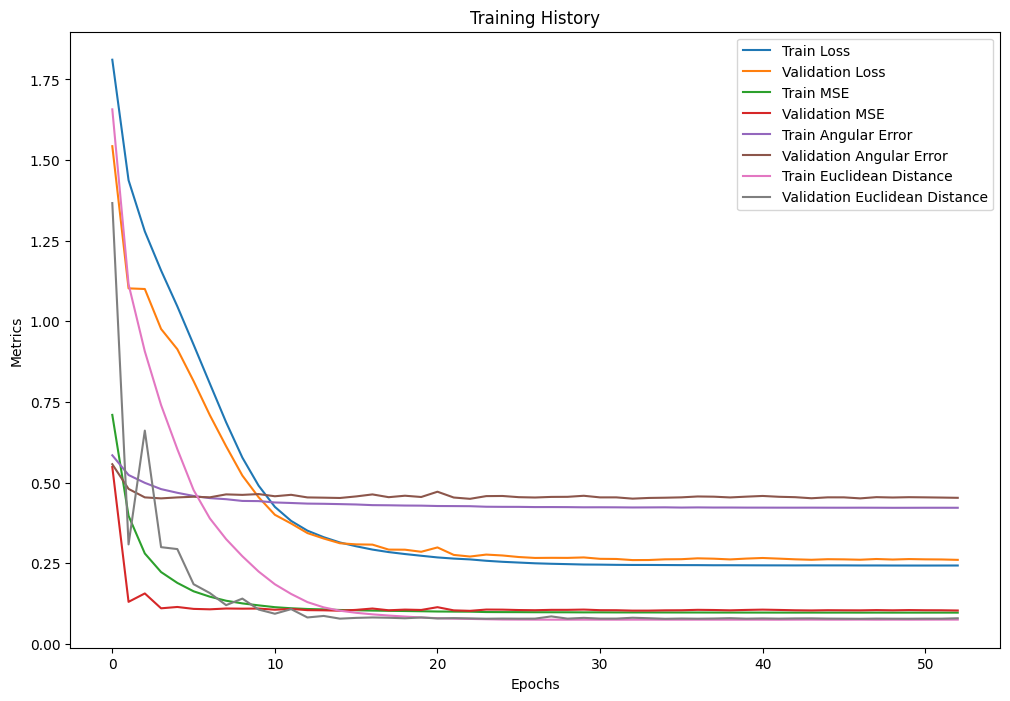

In [318]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, BatchNormalization, LeakyReLU, Dropout, Reshape, Layer, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Ensure GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# the Self-Attention with Positional Encoding Layer
class SelfAttentionWithPositionalEncoding(Layer):
    def __init__(self, units):
        super(SelfAttentionWithPositionalEncoding, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.Wq = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wk = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wv = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='random_normal',
                                  trainable=True)
        self.Wo = self.add_weight(shape=(self.units, input_shape[-1]),
                                  initializer='random_normal',
                                  trainable=True)

    def call(self, inputs):
        q = tf.matmul(inputs, self.Wq)
        k = tf.matmul(inputs, self.Wk)
        v = tf.matmul(inputs, self.Wv)

        # Ensure that the positional encoding matches the data type of q and k
        pos_encoding = tf.cast(self.positional_encoding(tf.shape(inputs)[1], tf.shape(inputs)[2]), dtype=q.dtype)

        q += pos_encoding
        k += pos_encoding

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = Softmax()(attention_scores)

        attention_output = tf.matmul(attention_scores, v)
        output = tf.matmul(attention_output, self.Wo)

        return output + inputs  # Add residual connection

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                                     tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                                     d_model)
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return pos_encoding

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return pos * angle_rates

# Custom Layer for Expanding Dimensions
class ExpandDimsLayer(Layer):
    def __init__(self, axis):
        super(ExpandDimsLayer, self).__init__()
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

# Custom Loss Function
def custom_loss(y_true, y_pred):
    coords_true = y_true[:, :6]
    coords_pred = y_pred[:, :6]
    rotations_true = y_true[:, 6:]
    rotations_pred = y_pred[:, 6:]

    coords_loss = tf.reduce_mean(tf.square(coords_true - coords_pred))
    rotations_loss = tf.reduce_mean(tf.square(tf.sin(rotations_true - rotations_pred)))

    total_loss = coords_loss + rotations_loss
    return total_loss

# Custom Metrics
def custom_angular_error(y_true, y_pred):
    rotations_true = y_true[:, 6:] 
    rotations_pred = y_pred[:, 6:]
    angular_error = tf.reduce_mean(tf.abs(tf.sin(rotations_true - rotations_pred)))
    return angular_error

def custom_euclidean_distance(y_true, y_pred):
    coords_true = y_true[:, :6] 
    coords_pred = y_pred[:, :6]
    euclidean_distance = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(coords_true - coords_pred), axis=-1)))
    return euclidean_distance

# Build the Model with 1D Convolution, Attention, and Positional Encoding
def build_model_with_conv_attention_and_positional_encoding(input_shape):
    # Input Layer
    input_layer = Input(shape=(input_shape,))
    
    # Reshape the input to apply Conv1D to each 768-dimensional feature vector separately
    reshaped_input = Reshape((3, 768))(input_layer)

    # 1D Convolutions to reduce dimensionality from 768 to 256
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(reshaped_input)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = Conv1D(filters=1, kernel_size=3, padding='same', activation='relu')(x)

    # Flatten the output back to 1D (concatenating the 256-dimensional vectors from each of the 3 original vectors)
    x = Flatten()(x)

    # Fully Connected Layers
    x = Dense(units=512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)

    # Attention Layer with expanded dimensions
    x = ExpandDimsLayer(axis=1)(x)  # Add sequence dimension using custom layer
    attention_output = SelfAttentionWithPositionalEncoding(units=512)(x)
    attention_output = Flatten()(attention_output)  # Flatten back to 1D after attention

    # Further Fully Connected Layers
    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(attention_output)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.4)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Dense(units=256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dropout(0.2)(x)

    # Output Layer
    output_layer = Dense(9)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss=custom_loss, 
                  metrics=['mse', 'mae', custom_angular_error, custom_euclidean_distance])
    return model


input_shape = X_train.shape[1]

# Build and compile the model
model = build_model_with_conv_attention_and_positional_encoding(input_shape=input_shape)

# model summary
print(model.summary())

# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                    callbacks=[reduce_lr, early_stopping], batch_size=16, verbose=1)

# Evaluate the model on the test set
test_loss, test_mse, test_mae, test_angular_error, test_euclidean_distance = model.evaluate(X_test, y_test, verbose=0)

# Print evaluation metrics
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}")
print(f"Test Angular Error: {test_angular_error}")
print(f"Test Euclidean Distance: {test_euclidean_distance}")


plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.plot(history.history['custom_angular_error'], label='Train Angular Error')
plt.plot(history.history['val_custom_angular_error'], label='Validation Angular Error')
plt.plot(history.history['custom_euclidean_distance'], label='Train Euclidean Distance')
plt.plot(history.history['val_custom_euclidean_distance'], label='Validation Euclidean Distance')
plt.legend()
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

# Save the history to a CSV file
history_df = pd.DataFrame(history.history)
history_file = os.path.join("experiments", "model_conv_attention_positional_encoding_history.csv")
history_df.to_csv(history_file, index=False)
